In [1]:
cd ..

m:\OneDrive\Projects\federated_imputation_pc1


## Loading

In [60]:
%load_ext autoreload
%autoreload
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from dython.nominal import correlation_ratio
import missingno as msno
from src.fed_imp.sub_modules.missing_simulate.missing_adder_new import simulate_nan_new
from src.modules.evaluation.imputation_quality import rmse, ws_cols, sliced_ws
from src.notebook_utils import (
    visualize_ms, correlation, run_pred, sklearn_evaluation, NN_evaluation,
    run_simulation, simulate_scenario
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
experiment_config_template = {
  "num_clients": 3,
  "data": {
    "dataset_name": "nhis_income_pca",
    "normalize": True,
  },
  "handle_imbalance": None,
  "data_partition": {
    "strategy": "sample@p=4000",
    "params": {}
  },
  "missing_simulate": {
    "mr_strategy": "fixed",
    "mf_strategy": "all",
    "mm_strategy": "mnar_lr"
  },
  "imputation": {
    "initial_strategy_num": "mean",
    "initial_strategy_cat": "mode",
    "estimator_num": "ridge_cv",
    "estimator_cat": "logistic_cv",
    "imp_evaluation_model": "logistic",
    "imp_evaluation_params": {
      "tune_params": "gridsearch"
    },
    "clip": True
  },
  "agg_strategy_imp": {
    "strategy": "fedavg-s",
    "params": {
      "ms_field": "missing_cell_pct",
      "beta": 0.7
    }
  },
  "server_type": "fedavg_pytorch",
  "server": {
    "impute_mode": "instant",
    "imp_round": 20,
    "imp_local_epochs": 0,
    "pred_round": 0,
    "pred_local_epochs": 0,
    "model_fit_mode": "one_shot"
  },
  "pred_model": {
    "model_params": {
      "model": "2nn",
      "num_hiddens": 128,
      "model_init_config": None,
      "model_other_params": None
    },
    "train_params": {
      "batch_size": 128,
      "learning_rate": 0.001,
      "weight_decay": 0.0001,
      "pred_round": 200,
      "pred_local_epochs": 3
    }
  },
  "experiment": {
    "n_rounds": 1,
    "seed": 102931466,
    "mtp": False,
    "random_seed": 50,
    "num_process": 3,
    "test_size": 0.1,
    "track": True
  },
  "tune_params": False,
  "track": False,
  "tune_params": True,
  "prediction": False,
  "save_state": False,
  "test_size": 0.1,
  "algo_params": {
    "local": {},
    "fedavg-s": {},
    "fedwavg": {
      "alpha": 0.9
    },
    "fedmechw": {
      "client_thres": 1.0,
      "alpha": 1.0,
      "beta": 0.0
    },
    "fedmechclw": {
      "client_thres": 0.2,
      "thres1": 0.2,
      "alpha": 0.5
    },
    'testavg':{
        
    },
    'testavg2':{
        
    },
    'testavg3':{
        
    },
    "scale_factor": 4
  }
}

server_config_tmpl = {
    "server_name": 'fedavg_mlp_pytorch_pred',
    "server_pred_config": {
        "model_params": {
            "model": "2nn",
            "num_hiddens": 128,
            "model_init_config": None,
            "model_other_params": None
        },
        "train_params": {
            "batch_size": 128,
            "learning_rate": 0.001,
            "weight_decay": 0.001,
            "pred_round": 1000,
            "pred_local_epochs": 5,
            'local_epoch': 5,
            'sample_pct': 1
        }
    },
    "server_config": {
        'pred_rounds': 1,
        'seed': 21
    }
}

In [4]:
trackers = {}
rets ={}
mr_strategy = 'fixed@mr=0.5'

# NHIS

## Complete Data

Shape of raw data:  (16868, 1418)
Shape of data after dropping columns only contains one value:  (14585, 1392)
Shape of data after dropping high cardinality columns:  (14585, 1390)
Shape of data remove columns with missing values:  (14585, 406)
['WTIA_HH', 'WTFA_HH', 'WTFA_FAM', 'WTIA', 'WTFA', 'WTIA_SA', 'WTFA_SA']
['INCGRP4', 'INCGRP5', 'RAT_CAT5', 'RAT_CAT4', 'BMI', 'AGE_P', 'WRKMYR', 'EDUC1', 'PRIVATE', 'HIKINDNA']
(14585, 103)
(14585, 103) (14585, 7) (14585,)
Shape of data after one-hot encoding:  (14585, 104)
Shape of data after PCA: (14585, 30)
sample-evenly {}
1
[1, 0]
[['mnar_quantile_left']]
[['mnar_quantile_left'], []]
['mnar_quantile_left@0.0']
(4376, 31)


2023-07-27 14:08:12.775 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 14:08:12.776 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-07-27 14:08:40.832 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 14:08:40.832 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-07-27 14:09:12.978 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 14:09:12.979 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-07-27 14:09:16.266 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 66.32440410018899


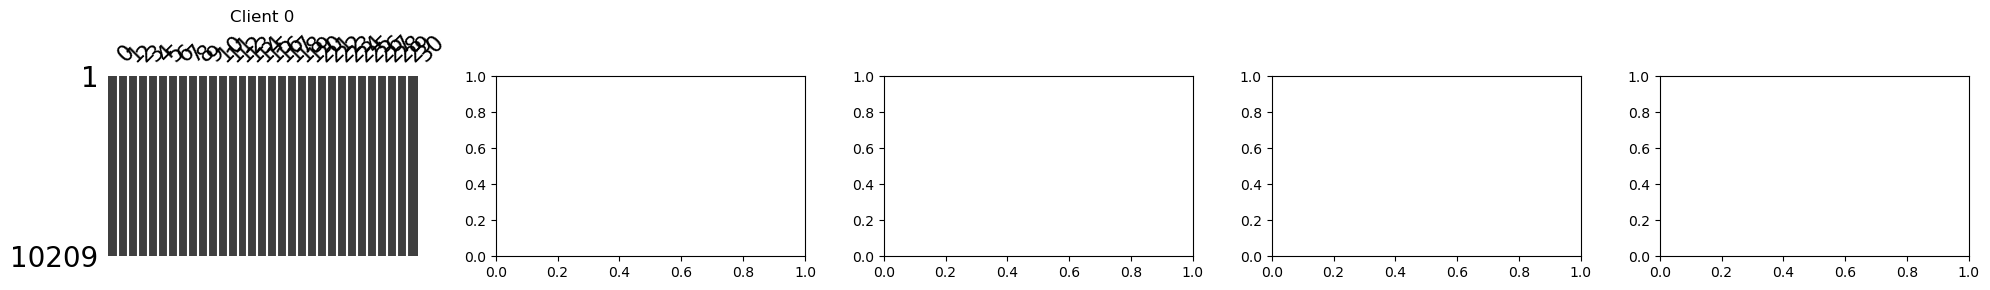

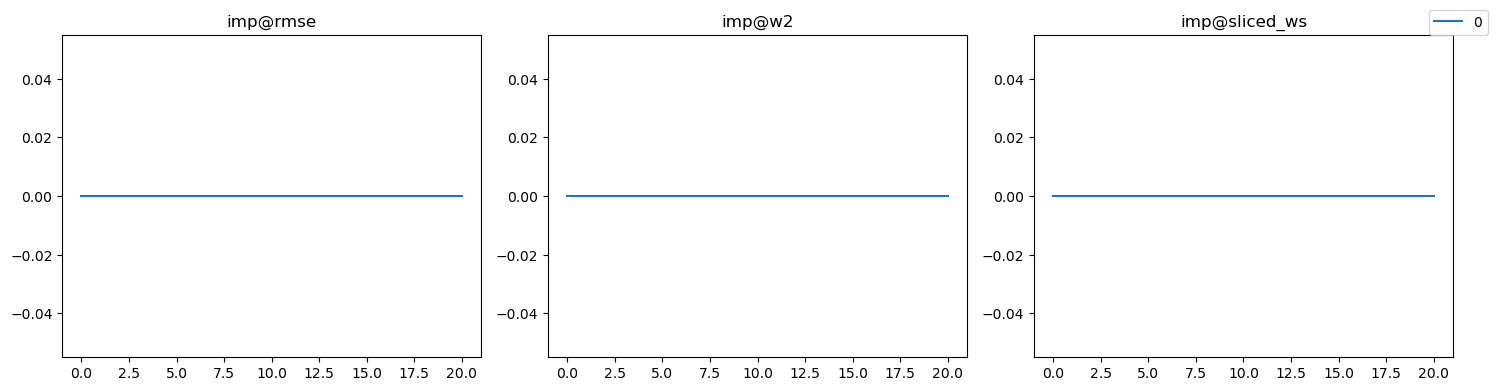

{'imp@rmse': 0.0, 'imp@ws': 0.0, 'imp@sliced_ws': 0.0}


In [17]:
name = 'complete1'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'nhis_income_pca'
config2['num_clients'] = 1
mr_strategy = 'fixed@mr=0.0'
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'local'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [51]:
pred_ret = NN_evaluation(
    rets['complete1'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

2023-07-27 16:33:57.337 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 0, test_accu: 0.6808, test_f1: 0.6362 test_auroc: 0.8565 train_loss: 0.6784 val_accu: 0.6861 val_f1: 0.6307
2023-07-27 16:34:20.027 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 100, test_accu: 0.8295, test_f1: 0.8269 test_auroc: 0.9018 train_loss: 0.3502 val_accu: 0.8394 val_f1: 0.8342
2023-07-27 16:34:43.952 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 200, test_accu: 0.8300, test_f1: 0.8284 test_auroc: 0.9021 train_loss: 0.3473 val_accu: 0.8374 val_f1: 0.8332
2023-07-27 16:35:06.864 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 300, test_accu: 0.8282, test_f1: 0.8263 test_auroc: 0.9011 train_loss: 0.3434 val_accu: 0.8355 val_f1: 0.8310
2023-07-27 16:35:29.258 | INFO     | src.fed_imp.sub_modules.server.pred_server_ce

0.8318098720292505


## All Left Central Imputation

Shape of raw data:  (16868, 1418)
Shape of data after dropping columns only contains one value:  (14585, 1392)
Shape of data after dropping high cardinality columns:  (14585, 1390)
Shape of data remove columns with missing values:  (14585, 406)
['WTIA_HH', 'WTFA_HH', 'WTFA_FAM', 'WTIA', 'WTFA', 'WTIA_SA', 'WTFA_SA']
['INCGRP4', 'INCGRP5', 'RAT_CAT5', 'RAT_CAT4', 'BMI', 'AGE_P', 'WRKMYR', 'EDUC1', 'PRIVATE', 'HIKINDNA']
(14585, 103)
(14585, 103) (14585, 7) (14585,)
Shape of data after one-hot encoding:  (14585, 104)
Shape of data after PCA: (14585, 30)
sample-evenly {}
1
[1, 0]
[['mnar_quantile_left']]
[['mnar_quantile_left'], []]
['mnar_quantile_left@0.5']
(4376, 31)


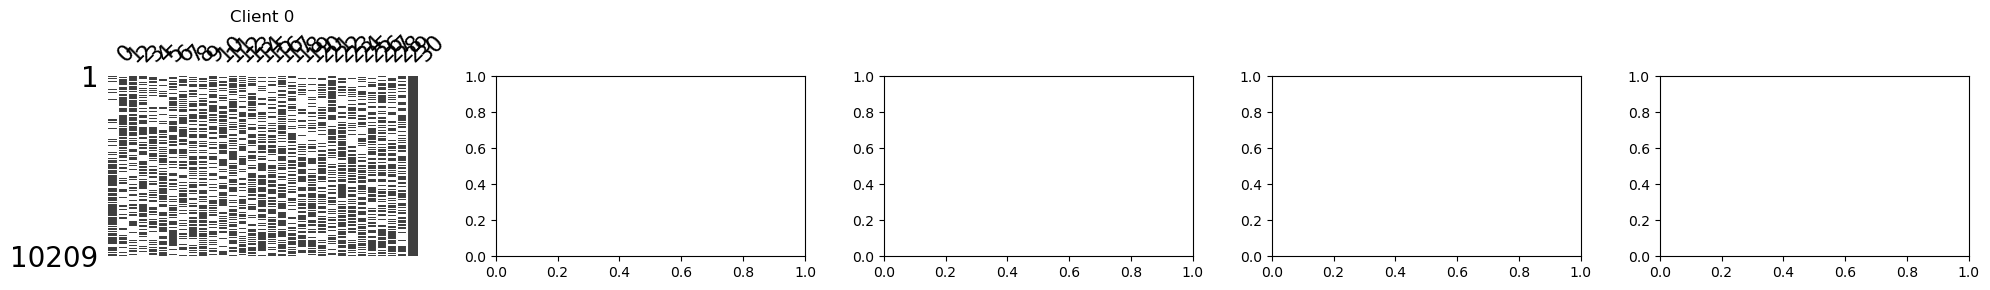

In [13]:
name = 'complete'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'nhis_income_pca'
config2['num_clients'] = 1
mr_strategy = 'fixed@mr=0.5'
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'local'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

2023-07-27 13:54:28.278 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 13:54:28.279 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-07-27 13:56:03.649 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 13:56:03.649 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-07-27 13:57:37.343 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 13:57:37.343 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-07-27 13:57:46.752 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 201.3179432998877


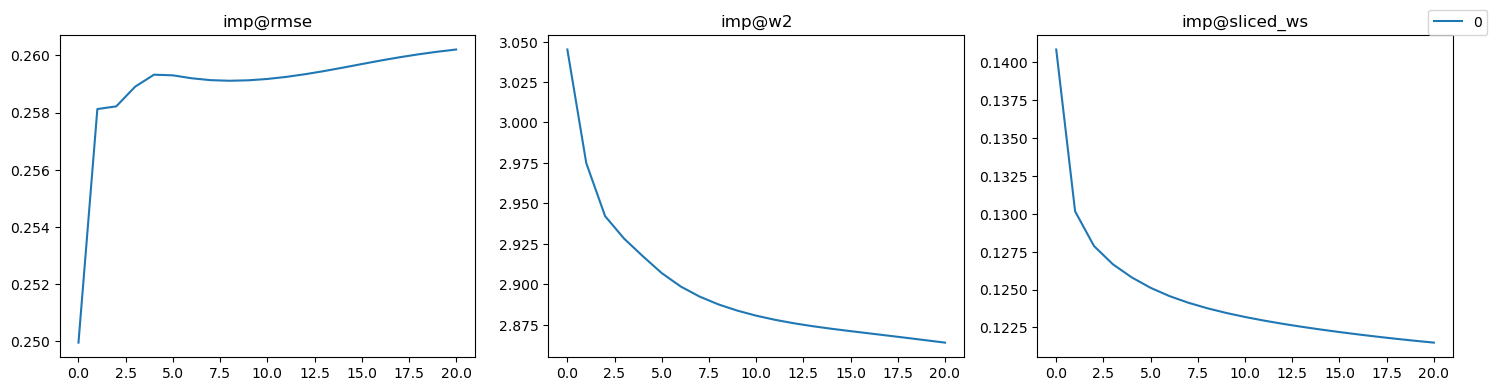

{'imp@rmse': 0.26002208659602877, 'imp@ws': 2.866816620492414, 'imp@sliced_ws': 0.12175606583459679}


In [14]:
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [15]:
pred_ret = NN_evaluation(
    rets['complete'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

2023-07-27 13:58:44.757 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5871, train_loss: 0.6793 val_accu: 0.6983 val_f1: 0.6522
2023-07-27 13:59:09.602 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.7244, train_loss: 0.4567 val_accu: 0.7914 val_f1: 0.7854
2023-07-27 13:59:35.652 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.7066, train_loss: 0.4325 val_accu: 0.7973 val_f1: 0.7884
2023-07-27 13:59:59.720 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.6853, train_loss: 0.4218 val_accu: 0.8056 val_f1: 0.8042
2023-07-27 14:00:24.118 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.6990, train_loss: 0.4170 val_accu: 0.8154 val_f1: 0.8133


0.7351462522851919


## Clients MNAR 3

### Local

Shape of raw data:  (16868, 1418)
Shape of data after dropping columns only contains one value:  (14585, 1392)
Shape of data after dropping high cardinality columns:  (14585, 1390)
Shape of data remove columns with missing values:  (14585, 406)
['WTIA_HH', 'WTFA_HH', 'WTFA_FAM', 'WTIA', 'WTFA', 'WTIA_SA', 'WTFA_SA']
['INCGRP4', 'INCGRP5', 'RAT_CAT5', 'RAT_CAT4', 'BMI', 'AGE_P', 'WRKMYR', 'EDUC1', 'PRIVATE', 'HIKINDNA']
(14585, 103)
(14585, 103) (14585, 7) (14585,)
Shape of data after one-hot encoding:  (14585, 104)
Shape of data after PCA: (14585, 30)
sample-evenly {}
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(4376, 31)


2023-07-27 12:28:41.440 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 12:28:41.440 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-07-27 12:29:47.245 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 12:29:47.246 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-07-27 12:30:49.590 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 12:30:49.590 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-07-27 12:30:55.641 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 137.11664930009283


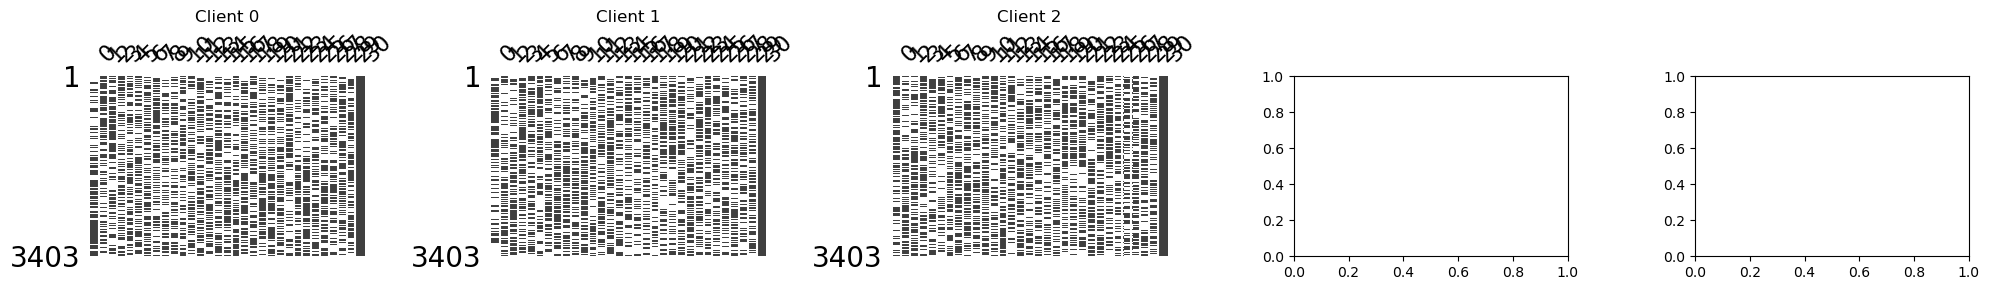

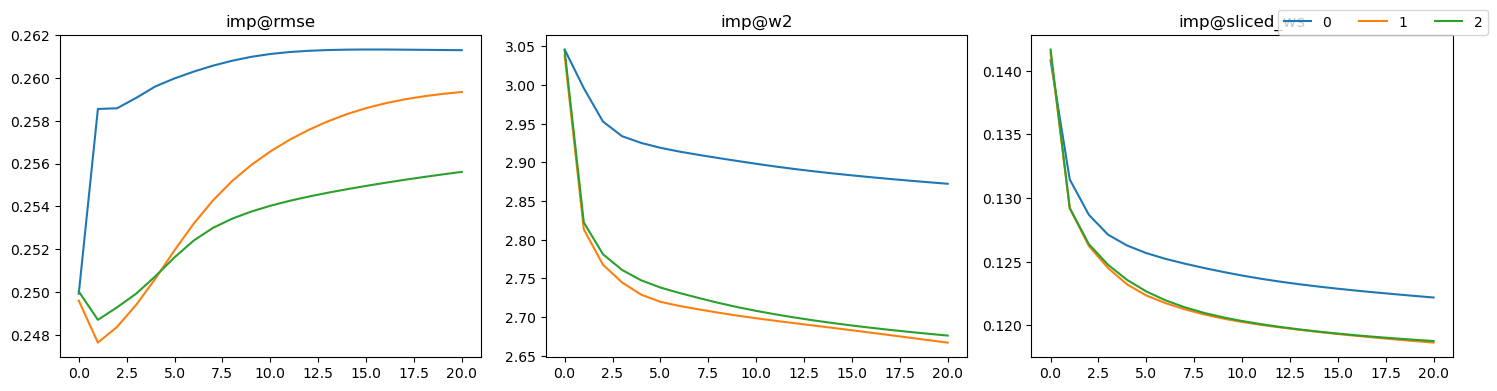

{'imp@rmse': 0.2585931801689739, 'imp@ws': 2.7435961388198455, 'imp@sliced_ws': 0.12009665757015063}


In [102]:
name = 'mnar_lr3_local'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'nhis_income_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'local'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [52]:
pred_ret = NN_evaluation(
    rets['mnar_lr3_local'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

KeyError: 'mnar_lr3_local'

### Simple Average

Shape of raw data:  (16868, 1418)
Shape of data after dropping columns only contains one value:  (14585, 1392)
Shape of data after dropping high cardinality columns:  (14585, 1390)
Shape of data remove columns with missing values:  (14585, 406)
['WTIA_HH', 'WTFA_HH', 'WTFA_FAM', 'WTIA', 'WTFA', 'WTIA_SA', 'WTFA_SA']
['INCGRP4', 'INCGRP5', 'RAT_CAT5', 'RAT_CAT4', 'BMI', 'AGE_P', 'WRKMYR', 'EDUC1', 'PRIVATE', 'HIKINDNA']
(14585, 103)
(14585, 103) (14585, 7) (14585,)
Shape of data after one-hot encoding:  (14585, 104)
Shape of data after PCA: (14585, 30)
sample-evenly {}
3
[1, 2]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(1459, 31)


2023-07-27 16:58:14.821 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 16:58:14.823 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-07-27 17:01:08.758 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 17:01:08.760 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-07-27 17:04:09.096 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 17:04:09.097 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-07-27 17:04:27.406 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 376.3343988000415


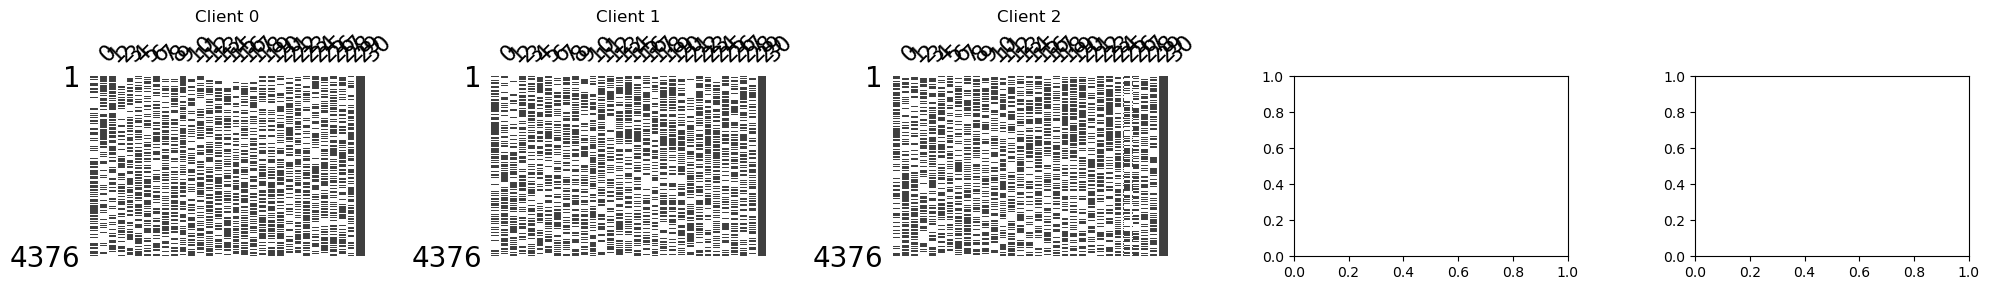

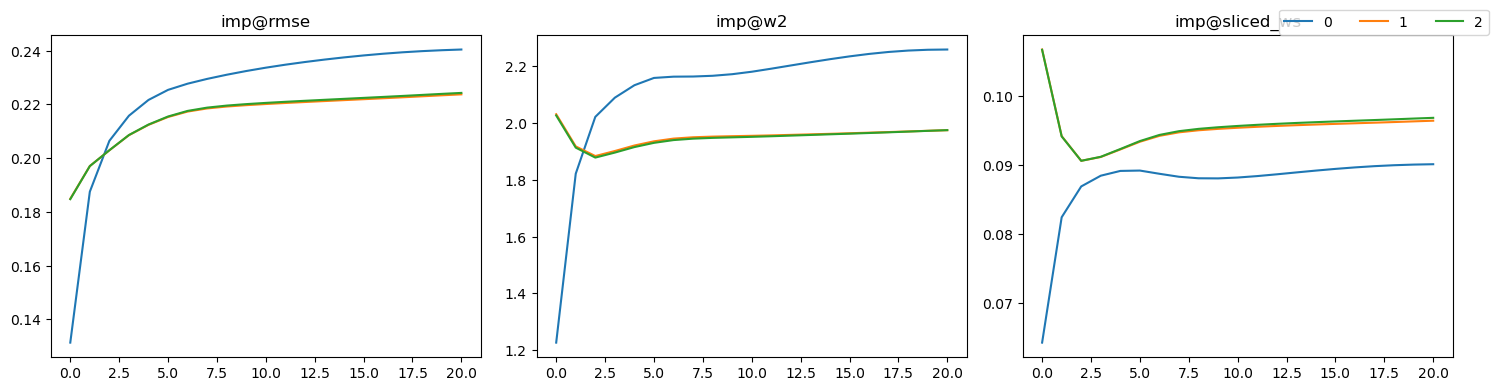

{'imp@rmse': 0.22875259908985554, 'imp@ws': 2.063425061887071, 'imp@sliced_ws': 0.09421856127063362}


In [54]:
name = 'mnar_lr3_fedavg-s'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'nhis_income_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [55]:
pred_ret = NN_evaluation(
    rets['mnar_lr3_fedavg-s'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

2023-07-27 17:04:29.130 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 0, test_accu: 0.5428, test_f1: 0.3820 test_auroc: 0.8065 train_loss: 0.6885 val_accu: 0.5422 val_f1: 0.3516
2023-07-27 17:04:56.216 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 100, test_accu: 0.7978, test_f1: 0.7975 test_auroc: 0.8659 train_loss: 0.4262 val_accu: 0.8094 val_f1: 0.8065
2023-07-27 17:05:23.216 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 200, test_accu: 0.7971, test_f1: 0.7933 test_auroc: 0.8630 train_loss: 0.4099 val_accu: 0.7565 val_f1: 0.7391
2023-07-27 17:05:50.751 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 300, test_accu: 0.7944, test_f1: 0.7931 test_auroc: 0.8618 train_loss: 0.3980 val_accu: 0.8071 val_f1: 0.8020
2023-07-27 17:06:18.487 | INFO     | src.fed_imp.sub_modules.server.pred_server_ce

0.818368745716244


Shape of raw data:  (16868, 1418)
Shape of data after dropping columns only contains one value:  (14585, 1392)
Shape of data after dropping high cardinality columns:  (14585, 1390)
Shape of data remove columns with missing values:  (14585, 406)
['WTIA_HH', 'WTFA_HH', 'WTFA_FAM', 'WTIA', 'WTFA', 'WTIA_SA', 'WTFA_SA']
['INCGRP4', 'INCGRP5', 'RAT_CAT5', 'RAT_CAT4', 'BMI', 'AGE_P', 'WRKMYR', 'EDUC1', 'PRIVATE', 'HIKINDNA']
(14585, 103)
(14585, 103) (14585, 7) (14585,)
Shape of data after one-hot encoding:  (14585, 104)
Shape of data after PCA: (14585, 30)
sample-evenly {}
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5']
(1459, 31)


2023-07-27 17:15:22.560 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 17:15:22.560 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-07-27 17:18:03.940 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 17:18:03.941 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-07-27 17:21:02.020 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 17:21:02.021 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-07-27 17:21:20.090 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 360.92908839997835


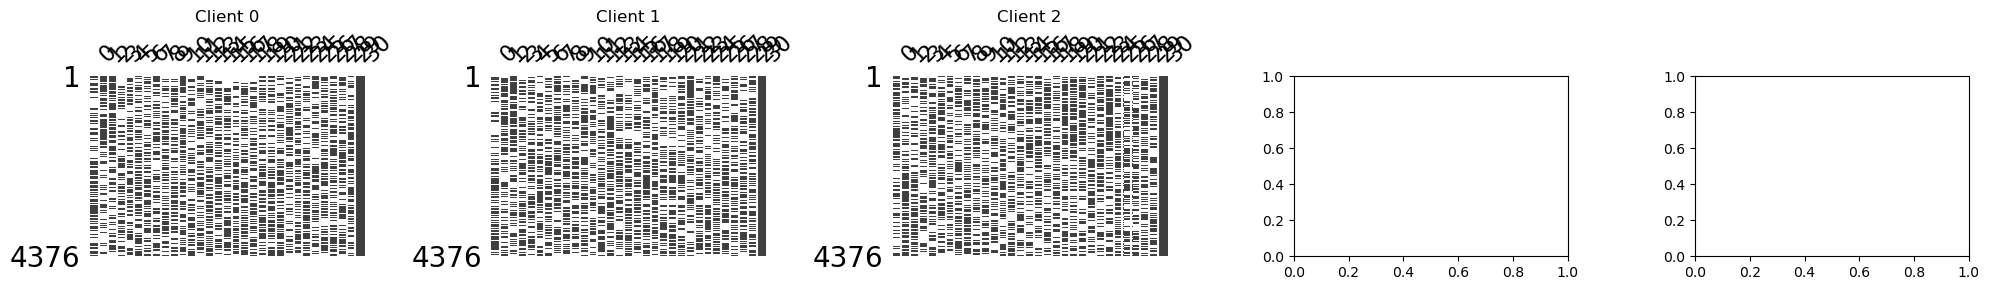

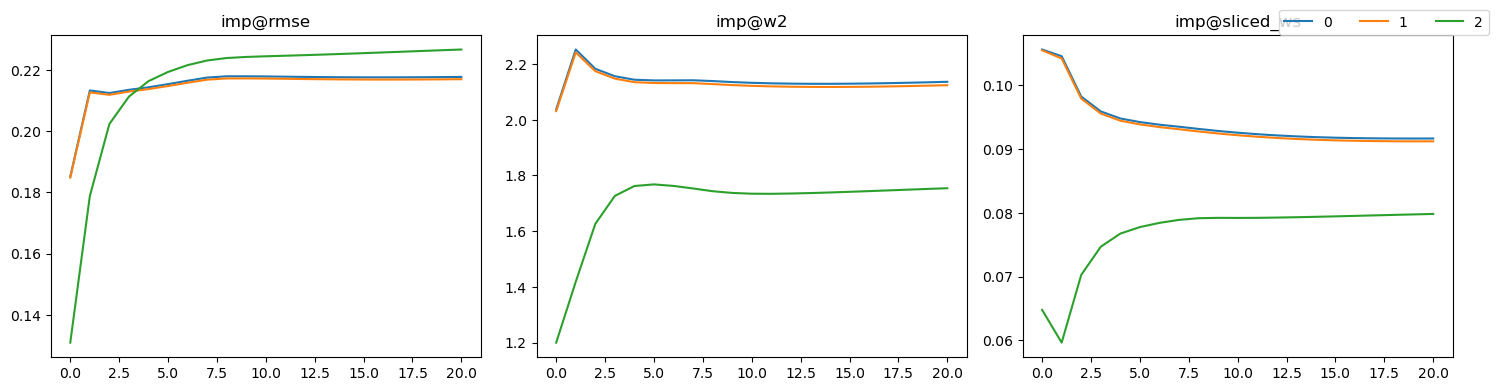

{'imp@rmse': 0.22027939678317135, 'imp@ws': 2.0008224316212546, 'imp@sliced_ws': 0.08751137852673645}


In [58]:
name = 'mnar_rl3_fedavg-s'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'nhis_income_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremer1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [59]:
pred_ret = NN_evaluation(
    rets['mnar_rl3_fedavg-s'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

2023-07-27 17:21:21.770 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 0, test_accu: 0.6546, test_f1: 0.6173 test_auroc: 0.7534 train_loss: 0.6813 val_accu: 0.6549 val_f1: 0.6089
2023-07-27 17:21:47.808 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 100, test_accu: 0.7958, test_f1: 0.7947 test_auroc: 0.8775 train_loss: 0.4027 val_accu: 0.8147 val_f1: 0.8115
2023-07-27 17:22:13.772 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 200, test_accu: 0.7964, test_f1: 0.7938 test_auroc: 0.8707 train_loss: 0.3882 val_accu: 0.8116 val_f1: 0.8046
2023-07-27 17:22:39.845 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 300, test_accu: 0.7896, test_f1: 0.7883 test_auroc: 0.8666 train_loss: 0.3789 val_accu: 0.8154 val_f1: 0.8103
2023-07-27 17:23:06.180 | INFO     | src.fed_imp.sub_modules.server.pred_server_ce

0.8060315284441398


### Our

Shape of raw data:  (16868, 1418)
Shape of data after dropping columns only contains one value:  (14585, 1392)
Shape of data after dropping high cardinality columns:  (14585, 1390)
Shape of data remove columns with missing values:  (14585, 406)
['WTIA_HH', 'WTFA_HH', 'WTFA_FAM', 'WTIA', 'WTFA', 'WTIA_SA', 'WTFA_SA']
['INCGRP4', 'INCGRP5', 'RAT_CAT5', 'RAT_CAT4', 'BMI', 'AGE_P', 'WRKMYR', 'EDUC1', 'PRIVATE', 'HIKINDNA']
(14585, 103)
(14585, 103) (14585, 7) (14585,)
Shape of data after one-hot encoding:  (14585, 104)
Shape of data after PCA: (14585, 30)
sample-evenly {}
3
[1, 2]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(1459, 31)


2023-07-27 17:06:57.209 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 17:06:57.209 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-07-27 17:09:39.768 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 17:09:39.769 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-07-27 17:12:38.254 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 17:12:38.255 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-07-27 17:12:56.312 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 362.58855700003915


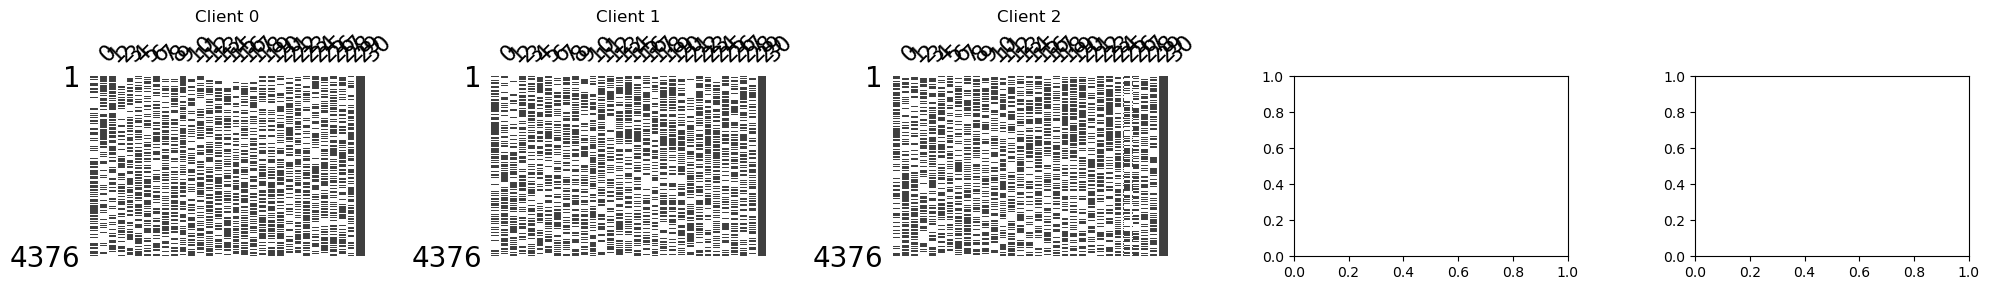

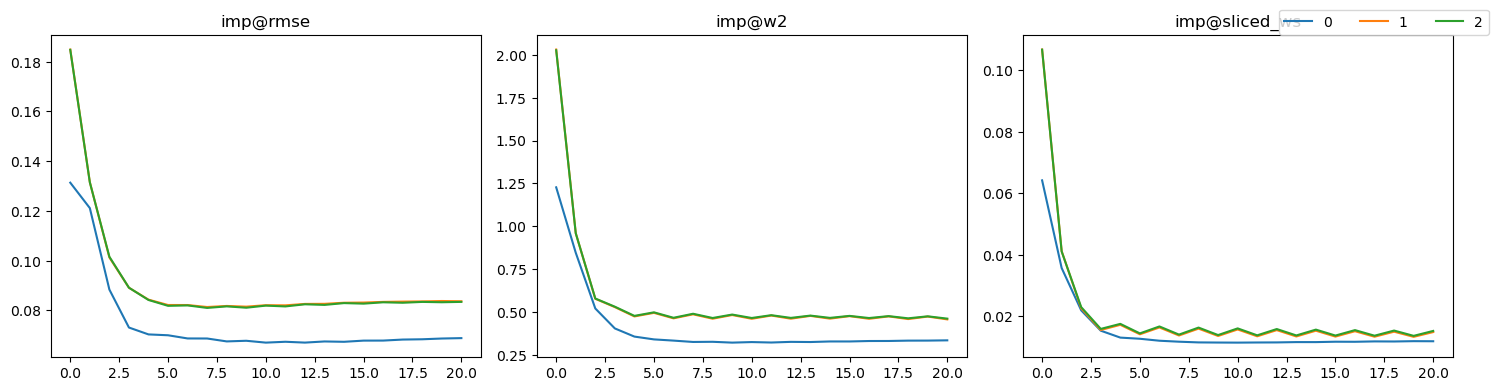

{'imp@rmse': 0.0784276082778521, 'imp@ws': 0.42309150993011235, 'imp@sliced_ws': 0.013664383496899869}


In [56]:
name = 'mnar_lr3_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'nhis_income_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [57]:
pred_ret = NN_evaluation(
    rets['mnar_lr3_fedmechw'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

2023-07-27 17:12:58.007 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 0, test_accu: 0.7951, test_f1: 0.7905 test_auroc: 0.8598 train_loss: 0.6752 val_accu: 0.7926 val_f1: 0.7834
2023-07-27 17:13:24.832 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 100, test_accu: 0.8232, test_f1: 0.8203 test_auroc: 0.8925 train_loss: 0.3674 val_accu: 0.8246 val_f1: 0.8205
2023-07-27 17:13:51.570 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 200, test_accu: 0.8239, test_f1: 0.8208 test_auroc: 0.8928 train_loss: 0.3582 val_accu: 0.8276 val_f1: 0.8230
2023-07-27 17:14:18.456 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 300, test_accu: 0.8245, test_f1: 0.8223 test_auroc: 0.8926 train_loss: 0.3512 val_accu: 0.8272 val_f1: 0.8236
2023-07-27 17:14:45.149 | INFO     | src.fed_imp.sub_modules.server.pred_server_ce

0.8348183687457162


Shape of raw data:  (16868, 1418)
Shape of data after dropping columns only contains one value:  (14585, 1392)
Shape of data after dropping high cardinality columns:  (14585, 1390)
Shape of data remove columns with missing values:  (14585, 406)
['WTIA_HH', 'WTFA_HH', 'WTFA_FAM', 'WTIA', 'WTFA', 'WTIA_SA', 'WTFA_SA']
['INCGRP4', 'INCGRP5', 'RAT_CAT5', 'RAT_CAT4', 'BMI', 'AGE_P', 'WRKMYR', 'EDUC1', 'PRIVATE', 'HIKINDNA']
(14585, 103)
(14585, 103) (14585, 7) (14585,)
Shape of data after one-hot encoding:  (14585, 104)
Shape of data after PCA: (14585, 30)
sample-evenly {}
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5']
(1459, 31)


2023-07-27 17:23:43.039 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 17:23:43.040 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-07-27 17:26:25.526 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 17:26:25.526 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-07-27 17:29:25.284 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 17:29:25.285 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-07-27 17:29:43.668 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 364.0298663000576


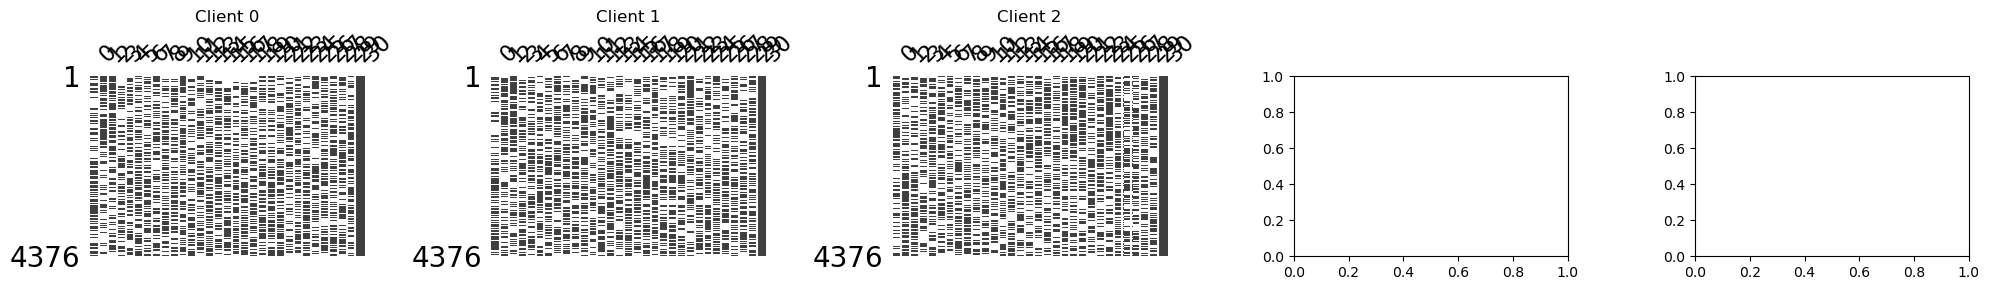

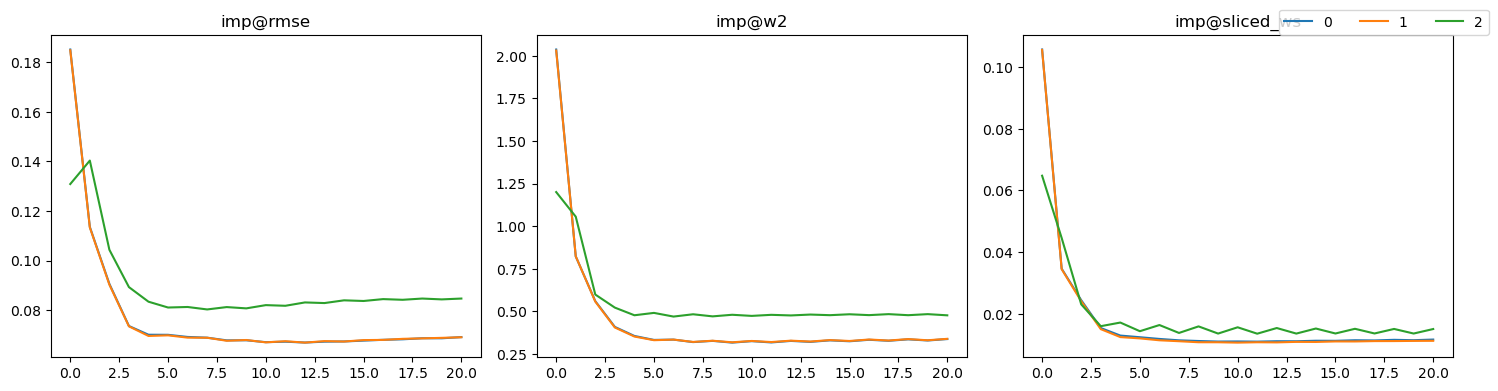

{'imp@rmse': 0.07382978804499865, 'imp@ws': 0.38123267274487266, 'imp@sliced_ws': 0.012532972942614665}


In [60]:
name = 'mnar_rl3_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'nhis_income_pca'
config2['num_clients'] = 3
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremer1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [61]:
pred_ret = NN_evaluation(
    rets['mnar_rl3_fedmechw'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

2023-07-27 17:29:45.684 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 0, test_accu: 0.7875, test_f1: 0.7810 test_auroc: 0.8614 train_loss: 0.6749 val_accu: 0.7888 val_f1: 0.7772
2023-07-27 17:30:11.527 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 100, test_accu: 0.8252, test_f1: 0.8226 test_auroc: 0.8959 train_loss: 0.3672 val_accu: 0.8295 val_f1: 0.8260
2023-07-27 17:30:37.650 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 200, test_accu: 0.8259, test_f1: 0.8226 test_auroc: 0.8966 train_loss: 0.3587 val_accu: 0.8257 val_f1: 0.8208
2023-07-27 17:31:03.798 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 300, test_accu: 0.8266, test_f1: 0.8253 test_auroc: 0.8953 train_loss: 0.3575 val_accu: 0.8295 val_f1: 0.8272
2023-07-27 17:31:29.669 | INFO     | src.fed_imp.sub_modules.server.pred_server_ce

0.8361891706648389


## Client MNAR 5

### Simple Averaging

Shape of raw data:  (16868, 1418)
Shape of data after dropping columns only contains one value:  (14585, 1392)
Shape of data after dropping high cardinality columns:  (14585, 1390)
Shape of data remove columns with missing values:  (14585, 406)
['WTIA_HH', 'WTFA_HH', 'WTFA_FAM', 'WTIA', 'WTFA', 'WTIA_SA', 'WTFA_SA']
['INCGRP4', 'INCGRP5', 'RAT_CAT5', 'RAT_CAT4', 'BMI', 'AGE_P', 'WRKMYR', 'EDUC1', 'PRIVATE', 'HIKINDNA']
(14585, 103)
(14585, 103) (14585, 7) (14585,)
Shape of data after one-hot encoding:  (14585, 104)
Shape of data after PCA: (14585, 30)
sample-evenly {}
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(4376, 31)


2023-07-27 12:35:32.942 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 12:35:32.943 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-07-27 12:36:30.435 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 12:36:30.436 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-07-27 12:37:34.607 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 12:37:34.608 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-07-27 12:37:41.302 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 130.90348510001786


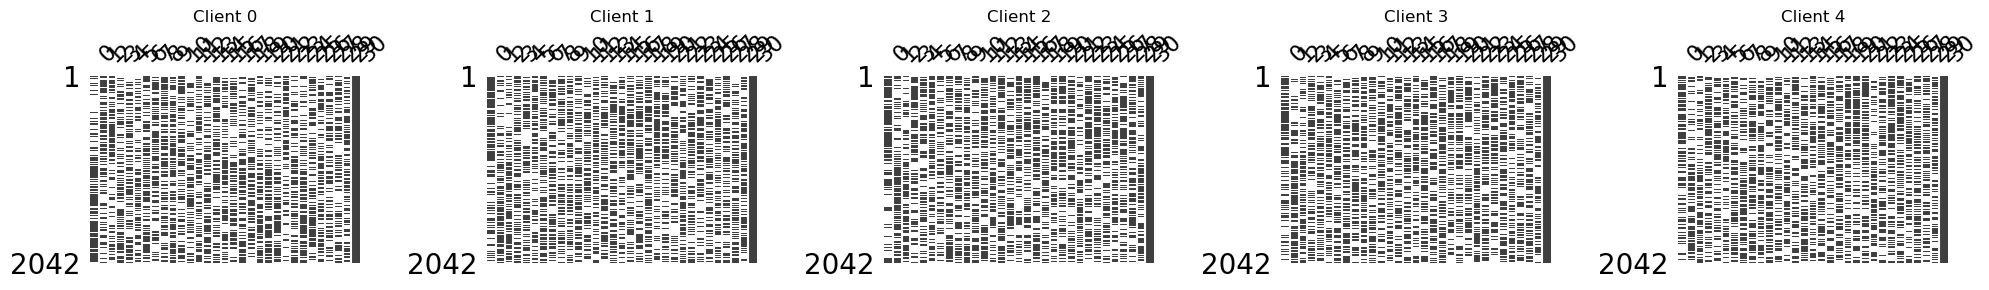

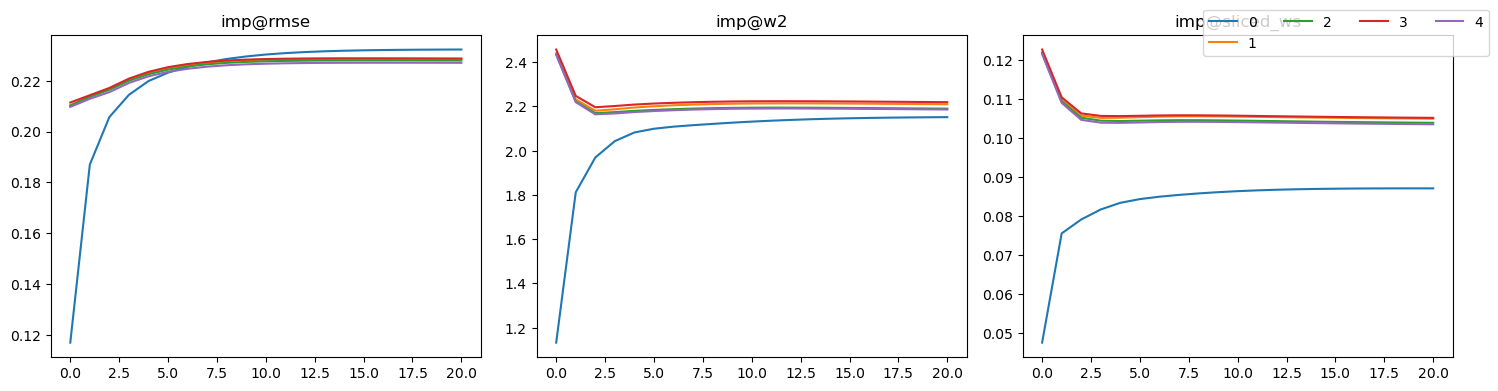

{'imp@rmse': 0.22892697697703754, 'imp@ws': 2.1919856940699542, 'imp@sliced_ws': 0.10101125729149338}


In [105]:
name = 'mnar_lr5_fedavg-s'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'nhis_income_pca'
config2['num_clients'] = 5
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [112]:
pred_ret = NN_evaluation(
    rets['mnar_lr5_fedavg-s'], type='fedavg', n_rounds=500, server_config_tmpl = server_config_tmpl
)

2023-07-27 13:23:35.475 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.8019, test_f1: 0.7951, val_loss: 0.5129, val_accu: 0.7599, val_f1: 0.7547
2023-07-27 13:24:29.732 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.8069, test_f1: 0.8005, val_loss: 0.5054, val_accu: 0.7741, val_f1: 0.7711
2023-07-27 13:25:23.526 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.8062, test_f1: 0.7994, val_loss: 0.4958, val_accu: 0.7858, val_f1: 0.7821
2023-07-27 13:26:18.116 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.8069, test_f1: 0.7999, val_loss: 0.4870, val_accu: 0.7936, val_f1: 0.7893
2023-07-27 13:27:12.154 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.8071, test_f1: 0.800

0.80827239488117


### Our

Shape of raw data:  (16868, 1418)
Shape of data after dropping columns only contains one value:  (14585, 1392)
Shape of data after dropping high cardinality columns:  (14585, 1390)
Shape of data remove columns with missing values:  (14585, 406)
['WTIA_HH', 'WTFA_HH', 'WTFA_FAM', 'WTIA', 'WTFA', 'WTIA_SA', 'WTFA_SA']
['INCGRP4', 'INCGRP5', 'RAT_CAT5', 'RAT_CAT4', 'BMI', 'AGE_P', 'WRKMYR', 'EDUC1', 'PRIVATE', 'HIKINDNA']
(14585, 103)
(14585, 103) (14585, 7) (14585,)
Shape of data after one-hot encoding:  (14585, 104)
Shape of data after PCA: (14585, 30)
sample-evenly {}
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(4376, 31)


2023-07-27 12:37:53.957 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 12:37:53.958 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-07-27 12:38:55.371 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 12:38:55.372 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-07-27 12:40:03.700 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 12:40:03.701 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-07-27 12:40:10.910 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 139.61908819992095


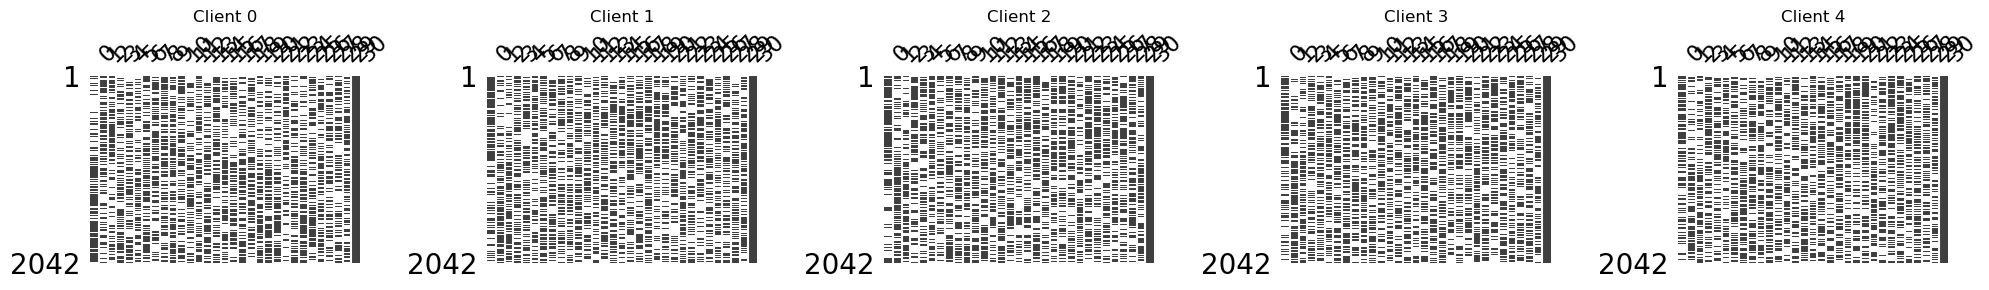

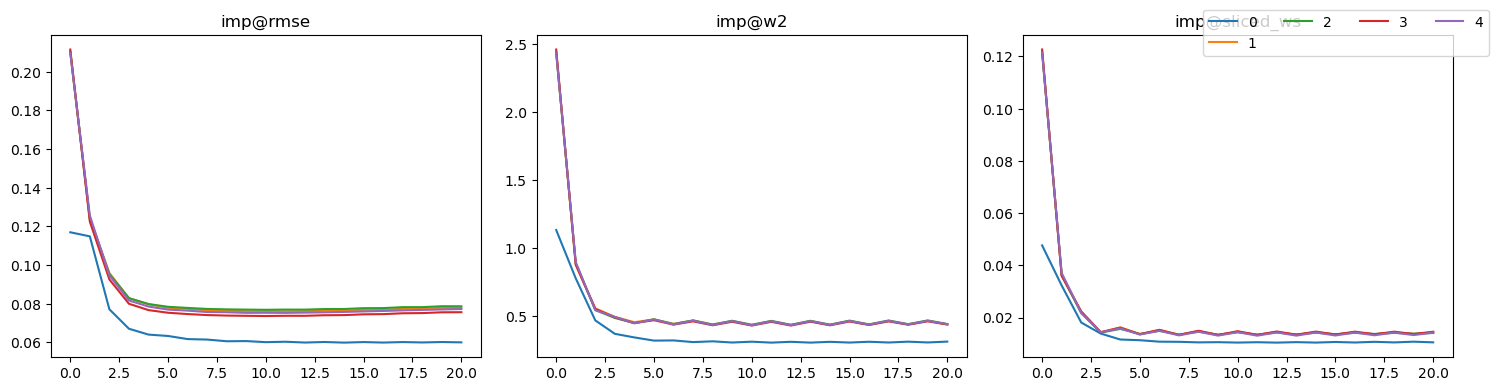

{'imp@rmse': 0.07349945074765572, 'imp@ws': 0.4216534296578763, 'imp@sliced_ws': 0.013328574479522261}


In [106]:
name = 'mnar_lr5_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'nhis_income_pca'
config2['num_clients'] = 5
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [113]:
pred_ret = NN_evaluation(
    rets['mnar_lr5_fedmechw'], type='fedavg', n_rounds=500, server_config_tmpl = server_config_tmpl
)

2023-07-27 13:32:37.297 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.8252, test_f1: 0.8216, val_loss: 0.3714, val_accu: 0.8323, val_f1: 0.8298
2023-07-27 13:33:31.624 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.8256, test_f1: 0.8224, val_loss: 0.3633, val_accu: 0.8372, val_f1: 0.8350
2023-07-27 13:34:25.812 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.8263, test_f1: 0.8236, val_loss: 0.3623, val_accu: 0.8381, val_f1: 0.8362
2023-07-27 13:35:20.009 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.8234, test_f1: 0.8207, val_loss: 0.3621, val_accu: 0.8406, val_f1: 0.8387
2023-07-27 13:36:13.980 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.8234, test_f1: 0.820

0.8279250457038391


## Clients MNAR 7

### Simple Averaging

Shape of raw data:  (16868, 1418)
Shape of data after dropping columns only contains one value:  (14585, 1392)
Shape of data after dropping high cardinality columns:  (14585, 1390)
Shape of data remove columns with missing values:  (14585, 406)
['WTIA_HH', 'WTFA_HH', 'WTFA_FAM', 'WTIA', 'WTFA', 'WTIA_SA', 'WTFA_SA']
['INCGRP4', 'INCGRP5', 'RAT_CAT5', 'RAT_CAT4', 'BMI', 'AGE_P', 'WRKMYR', 'EDUC1', 'PRIVATE', 'HIKINDNA']
(14585, 103)
(14585, 103) (14585, 7) (14585,)
Shape of data after one-hot encoding:  (14585, 104)
Shape of data after PCA: (14585, 30)
sample-evenly {}
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(4376, 31)


2023-07-27 12:40:24.522 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 12:40:24.523 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-07-27 12:41:28.827 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 12:41:28.828 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-07-27 12:42:39.452 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 12:42:39.453 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-07-27 12:42:46.895 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 144.9328344000969


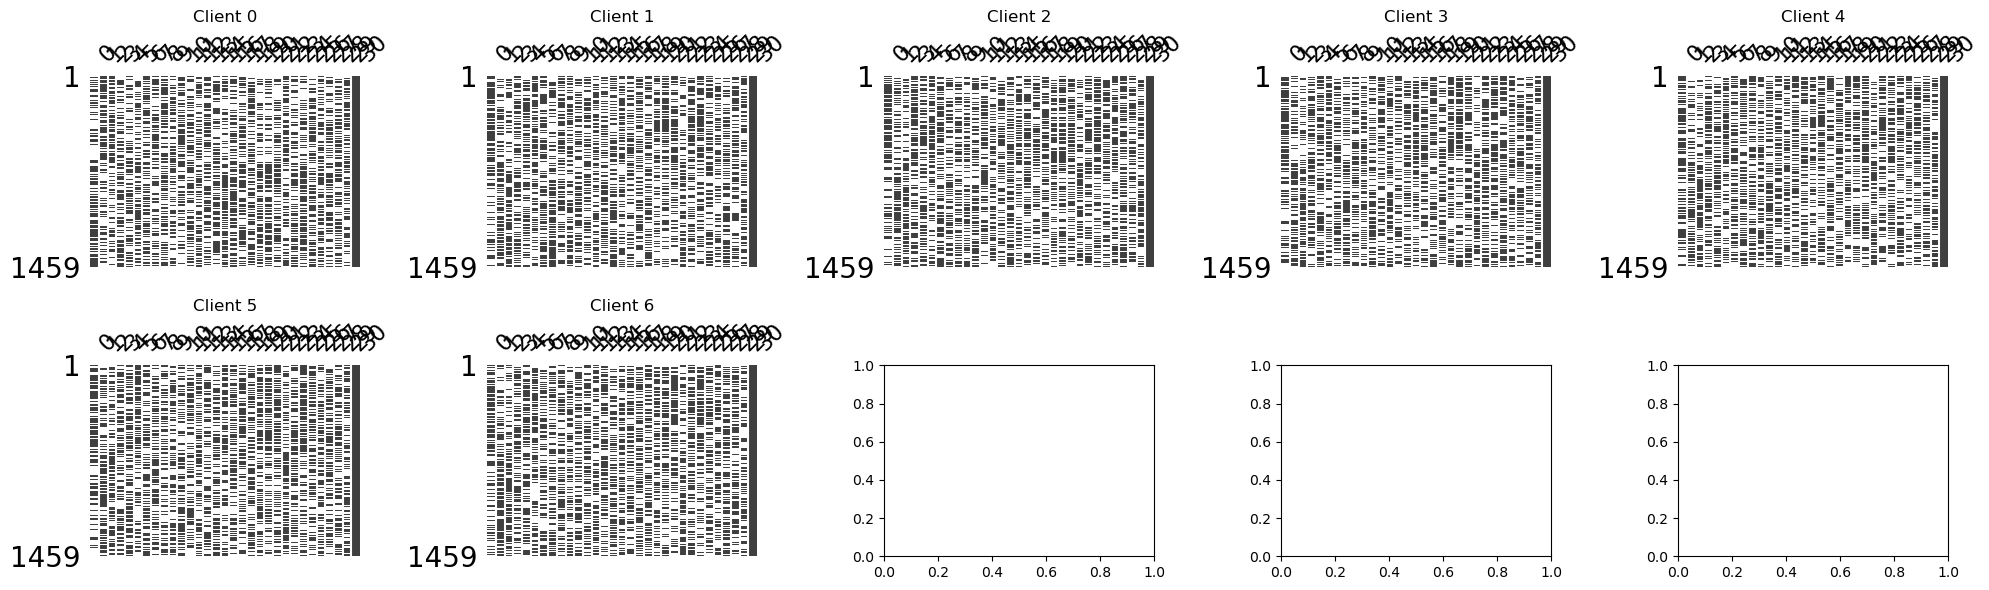

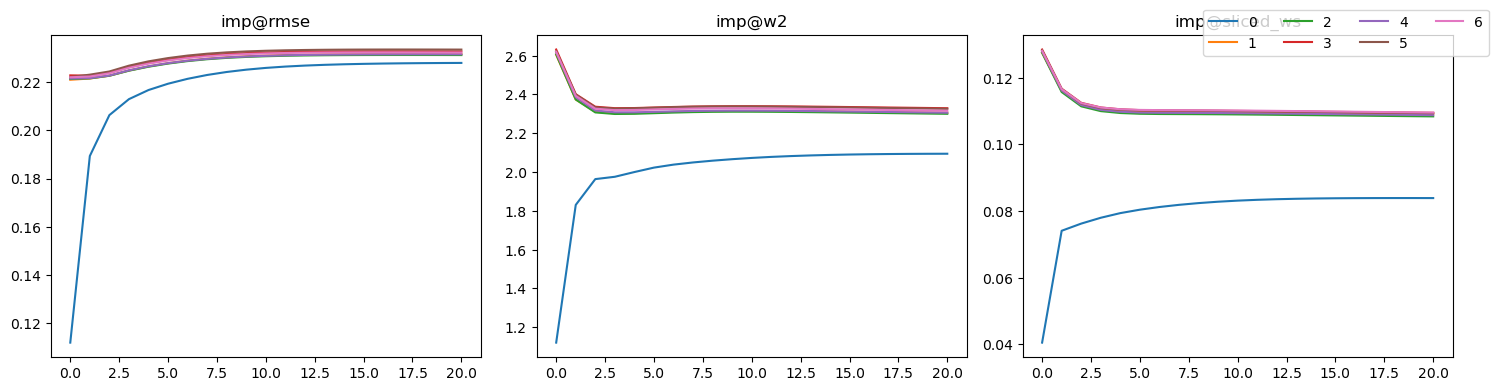

{'imp@rmse': 0.23148285999080298, 'imp@ws': 2.2843679481720724, 'imp@sliced_ws': 0.1056557330784811}


In [107]:
name = 'mnar_lr7_fedavg-s'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'nhis_income_pca'
config2['num_clients'] = 7
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [114]:
pred_ret = NN_evaluation(
    rets['mnar_lr7_fedavg-s'], type='fedavg', n_rounds=500, server_config_tmpl = server_config_tmpl
)

KeyboardInterrupt: 

### Our

Shape of raw data:  (16868, 1418)
Shape of data after dropping columns only contains one value:  (14585, 1392)
Shape of data after dropping high cardinality columns:  (14585, 1390)
Shape of data remove columns with missing values:  (14585, 406)
['WTIA_HH', 'WTFA_HH', 'WTFA_FAM', 'WTIA', 'WTFA', 'WTIA_SA', 'WTFA_SA']
['INCGRP4', 'INCGRP5', 'RAT_CAT5', 'RAT_CAT4', 'BMI', 'AGE_P', 'WRKMYR', 'EDUC1', 'PRIVATE', 'HIKINDNA']
(14585, 103)
(14585, 103) (14585, 7) (14585,)
Shape of data after one-hot encoding:  (14585, 104)
Shape of data after PCA: (14585, 30)
sample-evenly {}
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(4376, 31)


2023-07-27 12:43:00.637 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 12:43:00.638 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-07-27 12:44:10.856 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 12:44:10.857 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-07-27 12:45:27.291 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 12:45:27.292 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-07-27 12:45:35.120 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 157.17218280001543


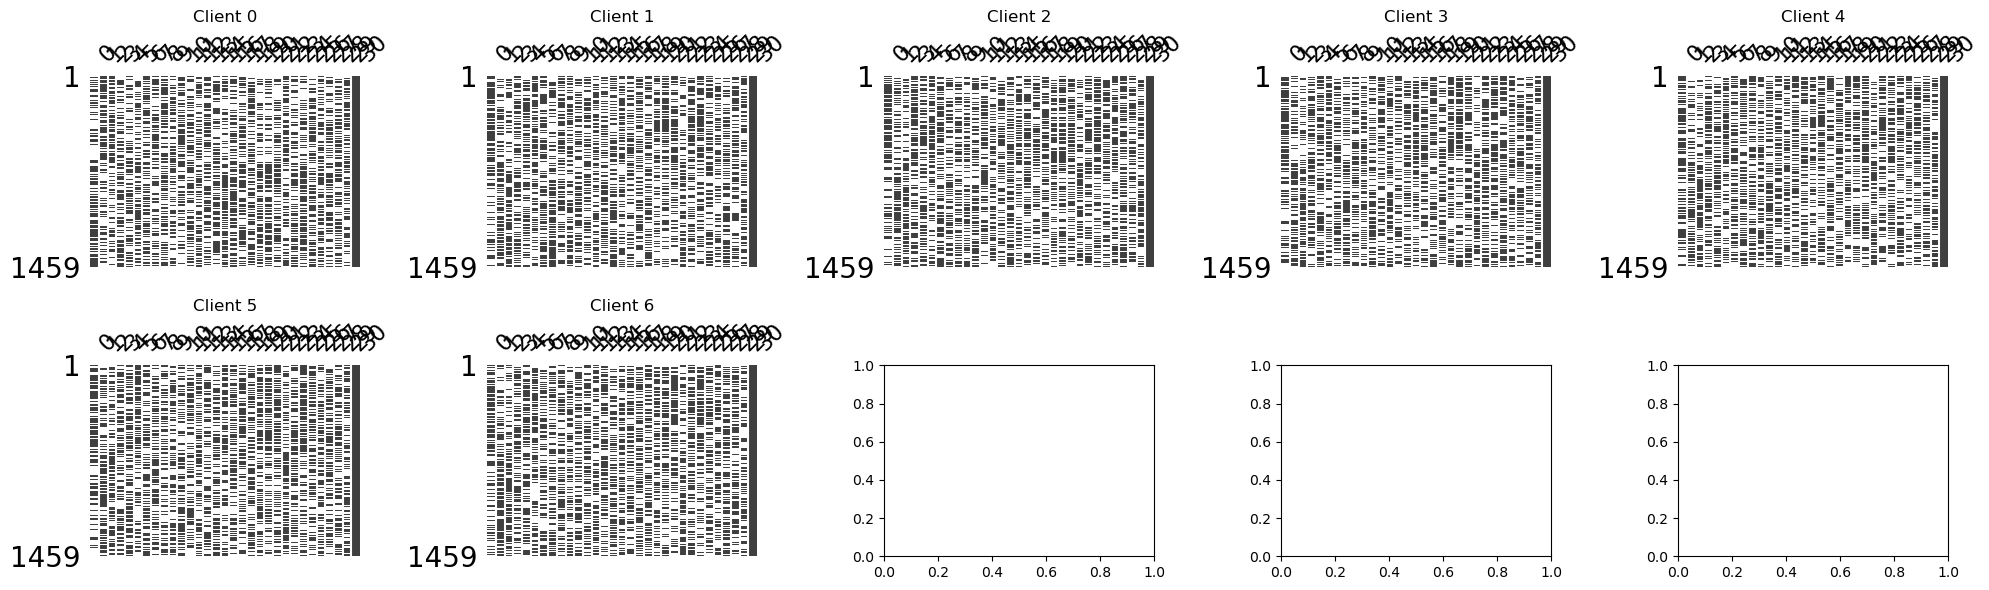

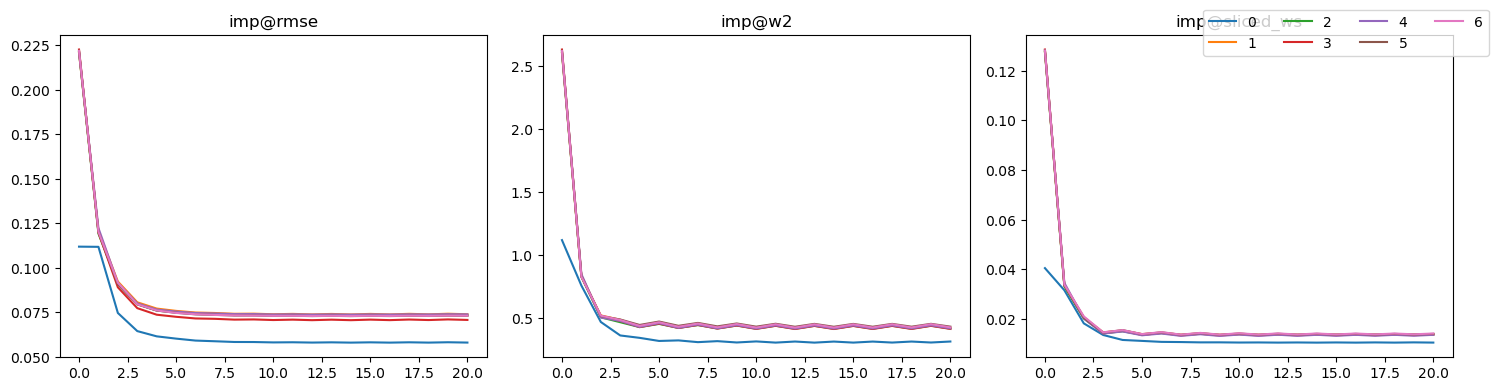

{'imp@rmse': 0.07096448895288479, 'imp@ws': 0.4171949365670016, 'imp@sliced_ws': 0.013313847038716976}


In [108]:
name = 'mnar_lr7_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'nhis_income_pca'
config2['num_clients'] = 7
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [ ]:
pred_ret = NN_evaluation(
    rets['mnar_lr7_fedmechw'], type='fedavg', n_rounds=500, server_config_tmpl = server_config_tmpl
)

## Clients MNAR 11

### Simple Averaging

Shape of raw data:  (16868, 1418)
Shape of data after dropping columns only contains one value:  (14585, 1392)
Shape of data after dropping high cardinality columns:  (14585, 1390)
Shape of data remove columns with missing values:  (14585, 406)
['WTIA_HH', 'WTFA_HH', 'WTFA_FAM', 'WTIA', 'WTFA', 'WTIA_SA', 'WTFA_SA']
['INCGRP4', 'INCGRP5', 'RAT_CAT5', 'RAT_CAT4', 'BMI', 'AGE_P', 'WRKMYR', 'EDUC1', 'PRIVATE', 'HIKINDNA']
(14585, 103)
(14585, 103) (14585, 7) (14585,)
Shape of data after one-hot encoding:  (14585, 104)
Shape of data after PCA: (14585, 30)
sample-evenly {}
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(4376, 31)


2023-07-27 11:30:46.931 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 11:30:46.932 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-07-27 11:32:06.409 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 11:32:06.410 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-07-27 11:33:31.626 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 11:33:31.627 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-07-27 11:33:40.098 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 175.45430510002188


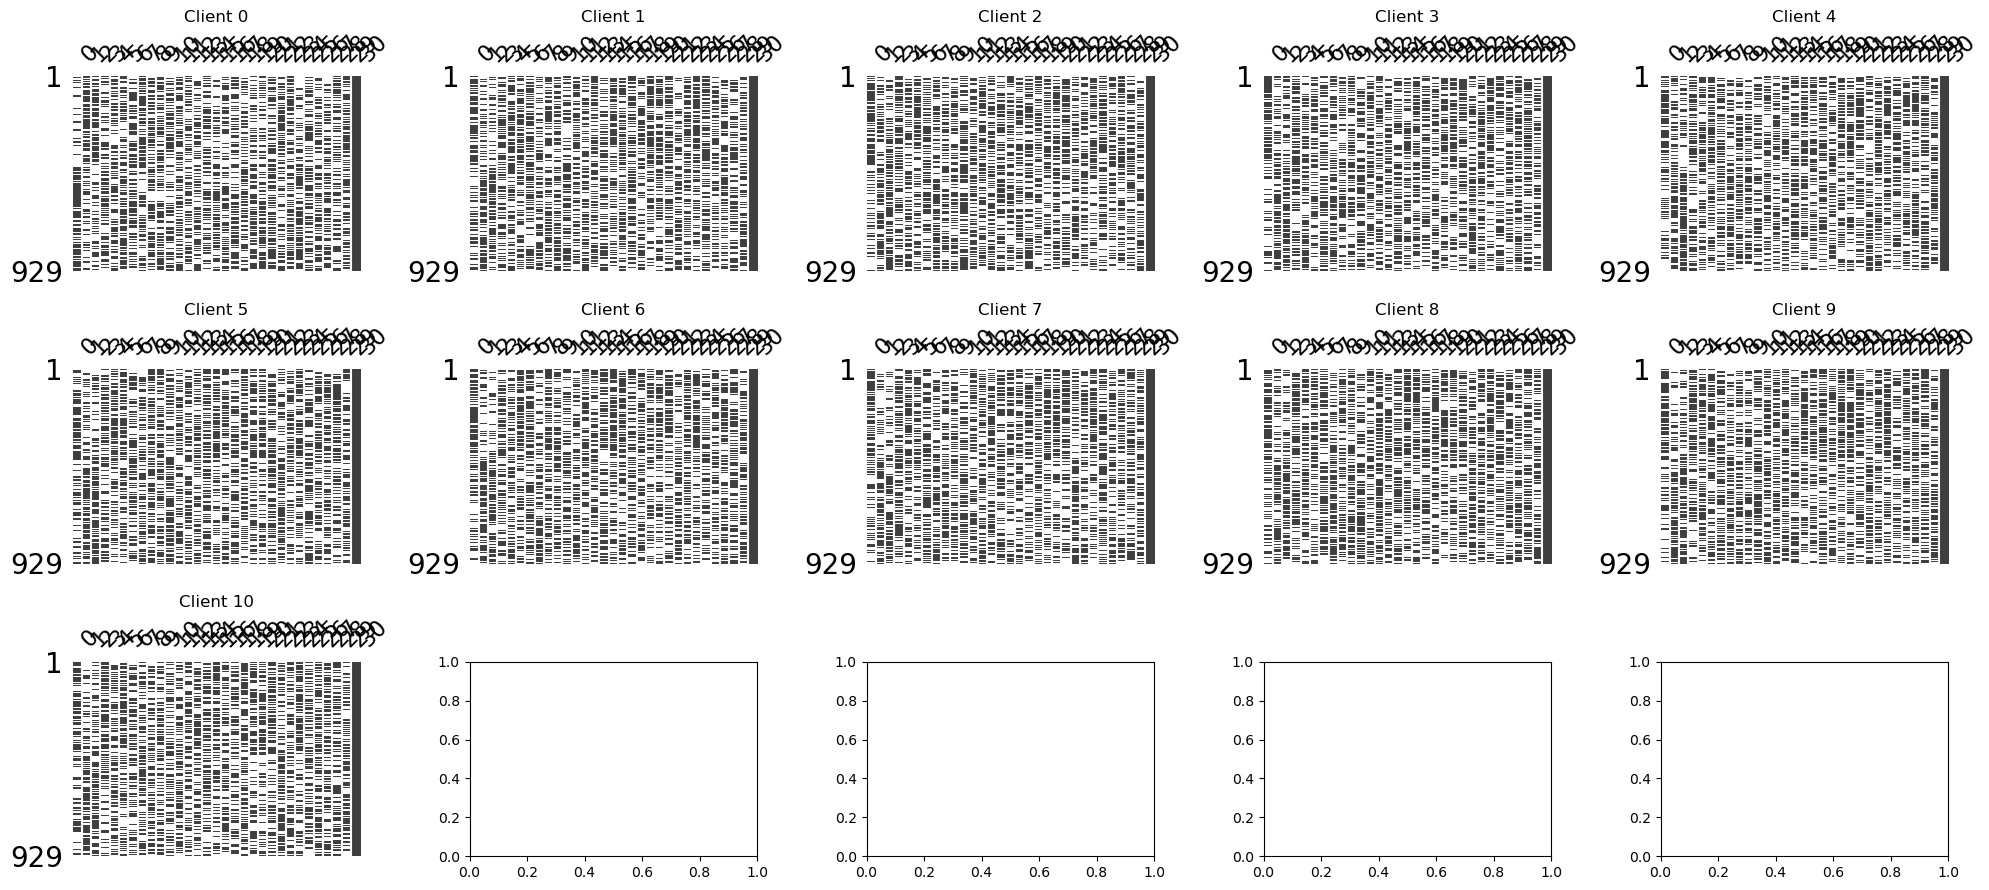

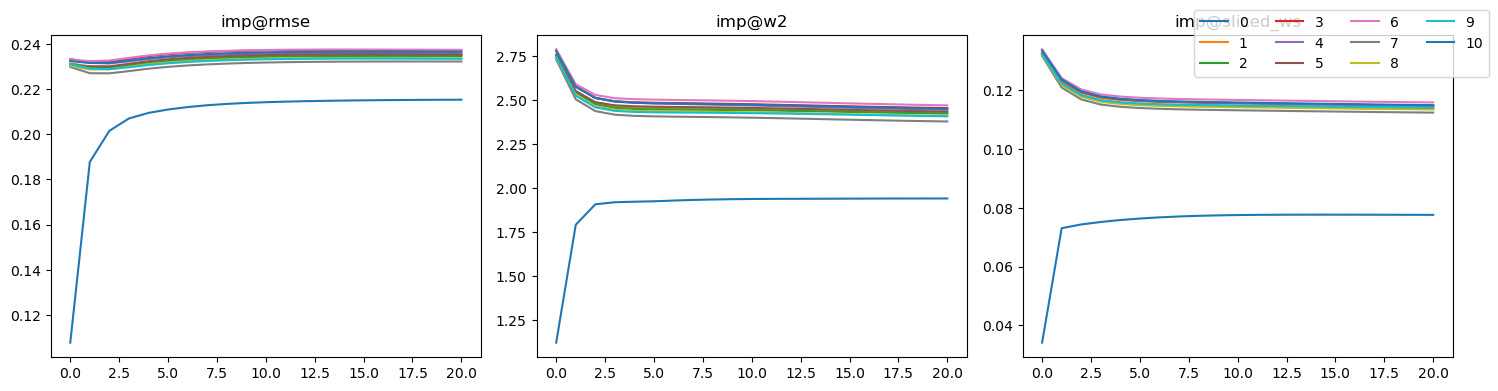

{'imp@rmse': 0.2332638568605701, 'imp@ws': 2.3895616619092963, 'imp@sliced_ws': 0.11109971904894629}


In [ ]:
name = 'mnar_lr12_fedavg-s'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'nhis_income_pca'
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

### Ours

Shape of raw data:  (16868, 1418)
Shape of data after dropping columns only contains one value:  (14585, 1392)
Shape of data after dropping high cardinality columns:  (14585, 1390)
Shape of data remove columns with missing values:  (14585, 406)
['WTIA_HH', 'WTFA_HH', 'WTFA_FAM', 'WTIA', 'WTFA', 'WTIA_SA', 'WTFA_SA']
['INCGRP4', 'INCGRP5', 'RAT_CAT5', 'RAT_CAT4', 'BMI', 'AGE_P', 'WRKMYR', 'EDUC1', 'PRIVATE', 'HIKINDNA']
(14585, 103)
(14585, 103) (14585, 7) (14585,)
Shape of data after one-hot encoding:  (14585, 104)
Shape of data after PCA: (14585, 30)
sample-evenly {}
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(4376, 31)


2023-07-27 11:44:39.071 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 11:44:39.072 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-07-27 11:46:03.329 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 11:46:03.330 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-07-27 11:47:38.116 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 11:47:38.117 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-07-27 11:47:47.579 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 190.71637169993483


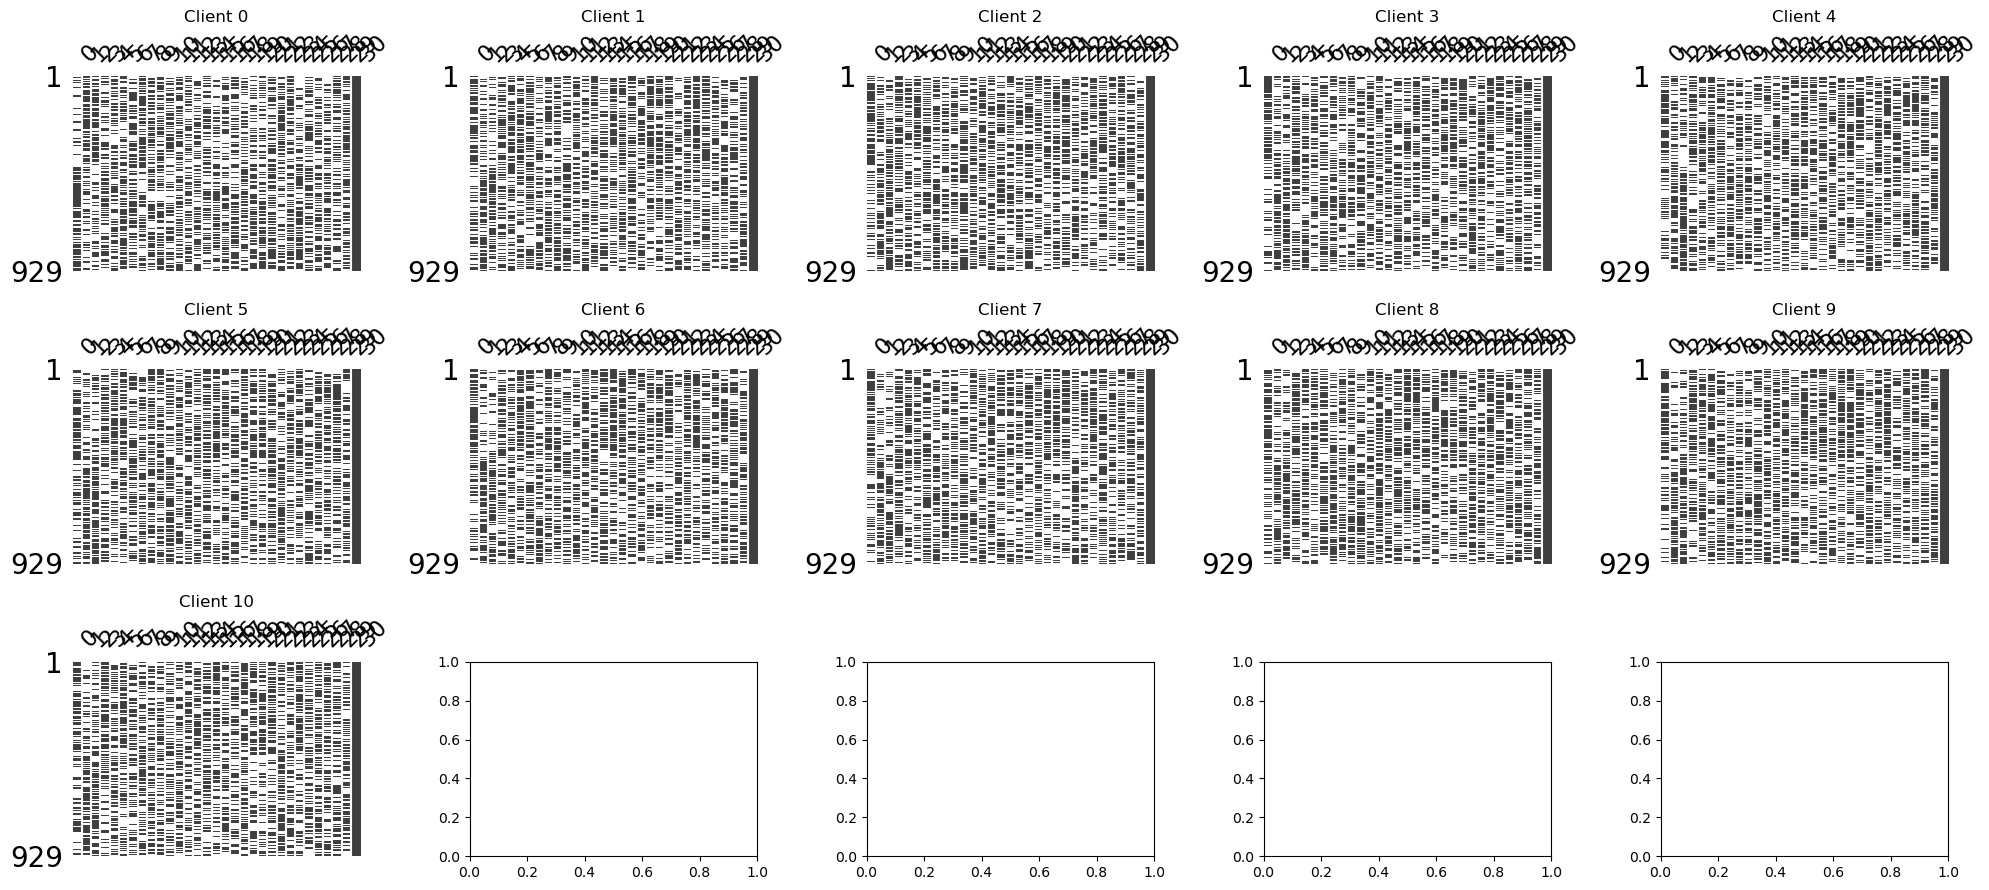

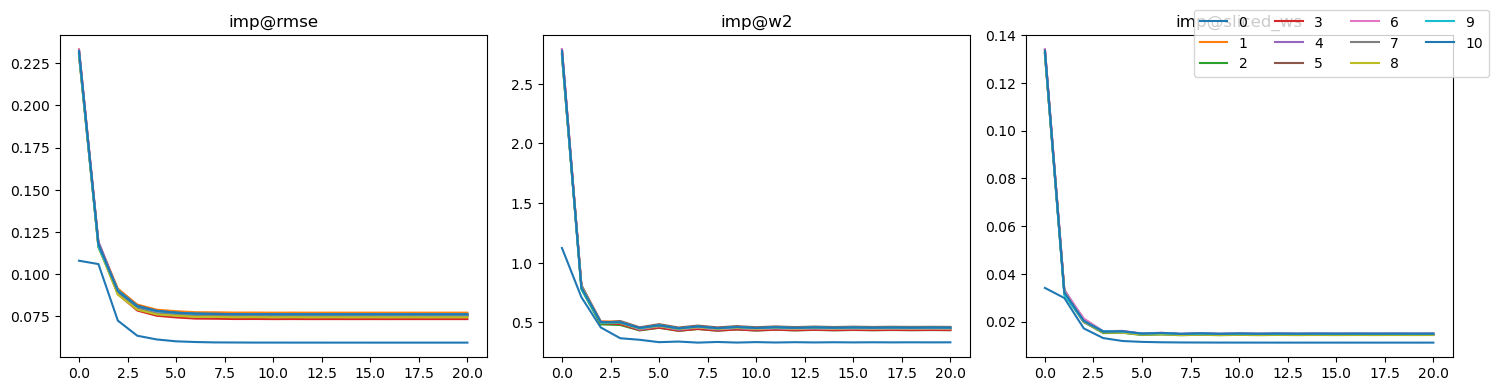

{'imp@rmse': 0.07382535977693794, 'imp@ws': 0.4402253081299912, 'imp@sliced_ws': 0.014403076528537749}


In [ ]:
name = 'mnar_lr12_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'nhis_income_pca'
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

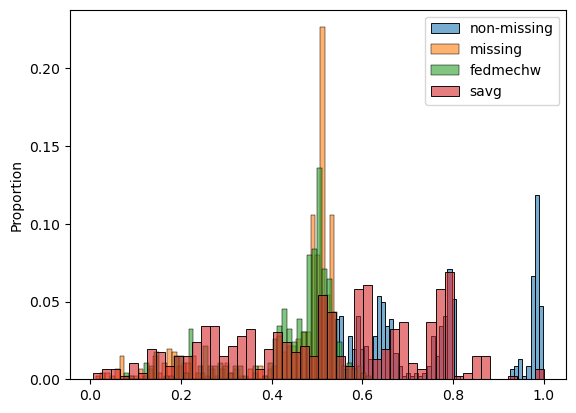

In [100]:
client_id = 0
feature_idx = 2
experiment = 'mnar_lr12'
clients_origin_data = rets['{}_fedmechw'.format(experiment)]['data']['origin_data']
clients_imp_data = rets['{}_fedmechw'.format(experiment)]['data']['imputed_data']
clients_msk = rets['{}_fedmechw'.format(experiment)]['data']['missing_mask']
#client_imp_data_local = rets['{}_local'.format(experiment)]['data']['imputed_data'][client_id, ...]
clients_imp_data_savg = rets['{}_fedavg-s'.format(experiment)]['data']['imputed_data']
split_indices = rets['{}_fedmechw'.format(experiment)]['data']['split_indices']

client_origin_data = np.split(clients_origin_data, split_indices)[client_id]
client_imp_data = np.split(clients_imp_data, split_indices)[client_id]
client_msk = np.split(clients_msk, split_indices)[client_id]
#client_imp_data_local = np.split(clients_imp_data_local, split_indices)[client_id, ...]
client_imp_data_savg = np.split(clients_imp_data_savg, split_indices)[client_id]

alpha = 0.6
bins = 50
stat = 'proportion'
sns.histplot(client_origin_data[:, feature_idx][~client_msk[:, feature_idx]], bins = bins, label = 'non-missing', stat=stat, alpha = alpha)
sns.histplot(client_origin_data[:, feature_idx][client_msk[:, feature_idx]], bins = bins, label = 'missing', stat=stat, alpha = alpha)
sns.histplot(client_imp_data[:, feature_idx][client_msk[:, feature_idx]], bins = bins, label = 'fedmechw', stat=stat, alpha = alpha)
#sns.histplot(client_imp_data_local[:, feature_idx][client_msk[:, feature_idx]], bins = bins, label = 'local', stat=stat, alpha = alpha)
sns.histplot(client_imp_data_savg[:, feature_idx][client_msk[:, feature_idx]], bins = bins, label = 'savg', stat=stat, alpha = alpha)
plt.legend()

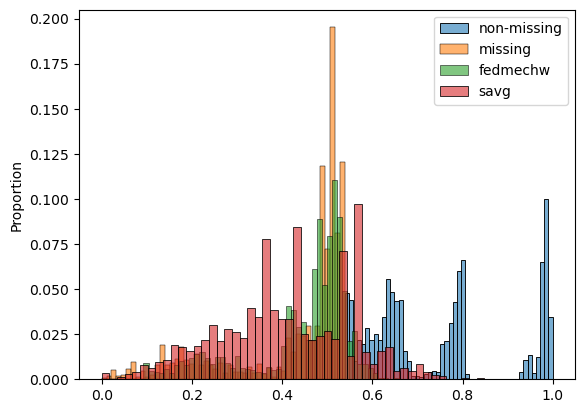

In [101]:
client_id = 0
feature_idx = 2
experiment = 'mnar_lr121'
clients_origin_data = rets['{}_fedmechw'.format(experiment)]['data']['origin_data']
clients_imp_data = rets['{}_fedmechw'.format(experiment)]['data']['imputed_data']
clients_msk = rets['{}_fedmechw'.format(experiment)]['data']['missing_mask']
#client_imp_data_local = rets['{}_local'.format(experiment)]['data']['imputed_data'][client_id, ...]
clients_imp_data_savg = rets['{}_fedavg-s'.format(experiment)]['data']['imputed_data']
split_indices = rets['{}_fedmechw'.format(experiment)]['data']['split_indices']

client_origin_data = np.split(clients_origin_data, split_indices)[client_id]
client_imp_data = np.split(clients_imp_data, split_indices)[client_id]
client_msk = np.split(clients_msk, split_indices)[client_id]
#client_imp_data_local = np.split(clients_imp_data_local, split_indices)[client_id, ...]
client_imp_data_savg = np.split(clients_imp_data_savg, split_indices)[client_id]

alpha = 0.6
bins = 50
stat = 'proportion'
sns.histplot(client_origin_data[:, feature_idx][~client_msk[:, feature_idx]], bins = bins, label = 'non-missing', stat=stat, alpha = alpha)
sns.histplot(client_origin_data[:, feature_idx][client_msk[:, feature_idx]], bins = bins, label = 'missing', stat=stat, alpha = alpha)
sns.histplot(client_imp_data[:, feature_idx][client_msk[:, feature_idx]], bins = bins, label = 'fedmechw', stat=stat, alpha = alpha)
#sns.histplot(client_imp_data_local[:, feature_idx][client_msk[:, feature_idx]], bins = bins, label = 'local', stat=stat, alpha = alpha)
sns.histplot(client_imp_data_savg[:, feature_idx][client_msk[:, feature_idx]], bins = bins, label = 'savg', stat=stat, alpha = alpha)
plt.legend()

## Clients MNAR 20

Shape of raw data:  (16868, 1418)
Shape of data after dropping columns only contains one value:  (14585, 1392)
Shape of data after dropping high cardinality columns:  (14585, 1390)
Shape of data remove columns with missing values:  (14585, 406)
['WTIA_HH', 'WTFA_HH', 'WTFA_FAM', 'WTIA', 'WTFA', 'WTIA_SA', 'WTFA_SA']
['INCGRP4', 'INCGRP5', 'RAT_CAT5', 'RAT_CAT4', 'BMI', 'AGE_P', 'WRKMYR', 'EDUC1', 'PRIVATE', 'HIKINDNA']
(14585, 103)
(14585, 103) (14585, 7) (14585,)
Shape of data after one-hot encoding:  (14585, 104)
Shape of data after PCA: (14585, 30)
sample-evenly {}
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_qu

2023-07-27 16:17:11.576 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 16:17:11.577 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-07-27 16:19:39.053 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 16:19:39.054 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-07-27 16:22:20.655 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 16:22:20.655 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-07-27 16:22:38.251 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 330.2190932999365


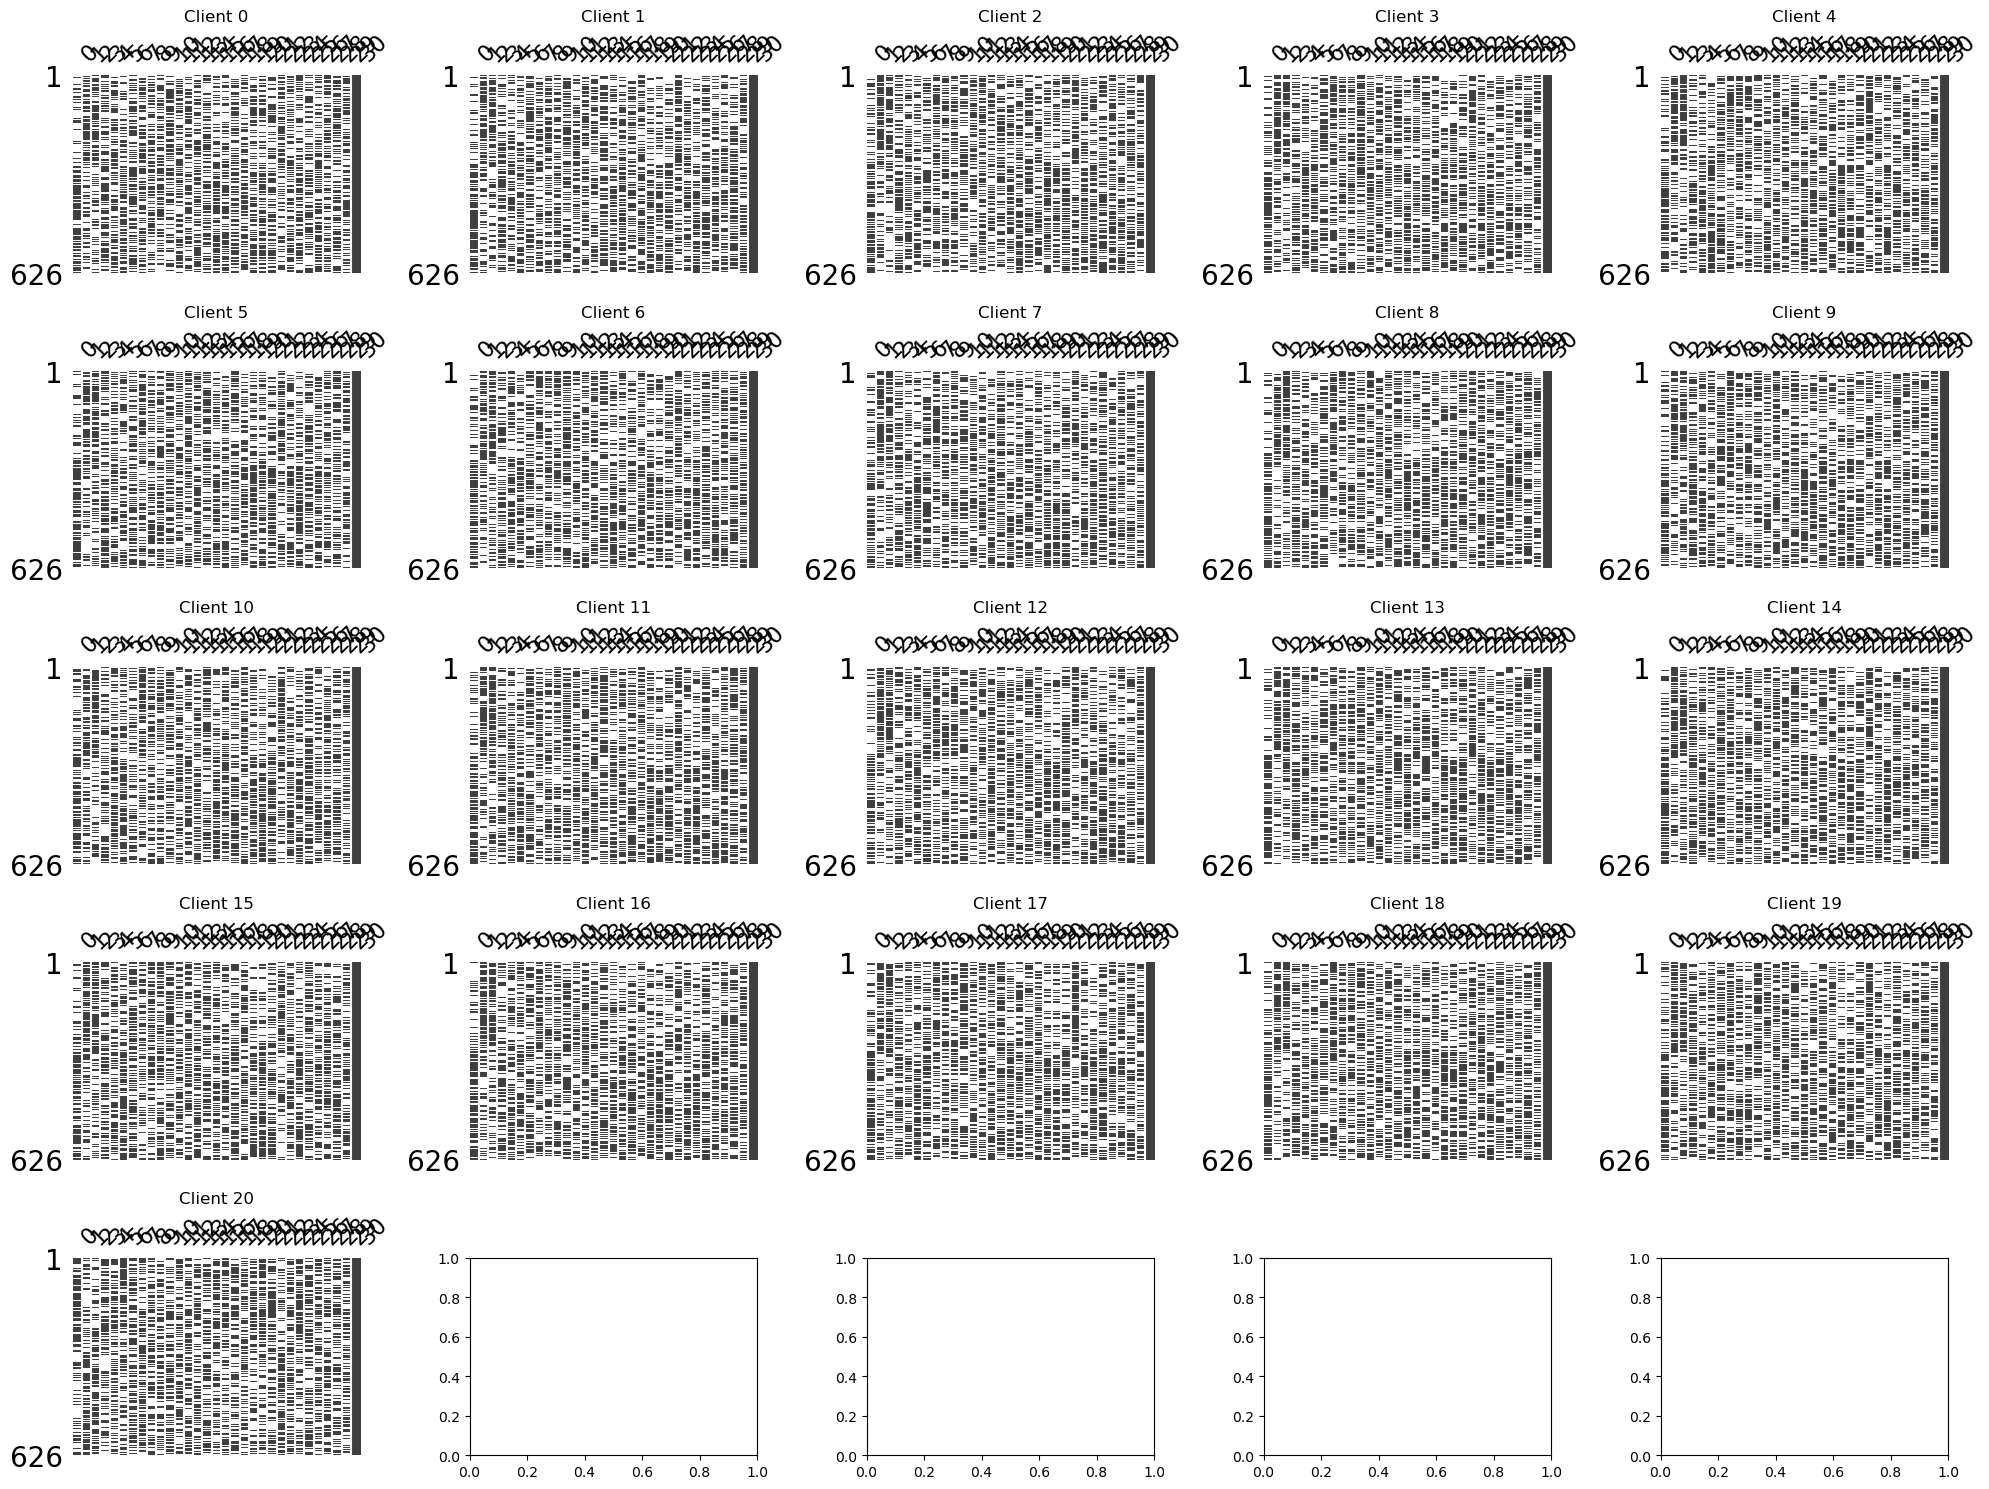

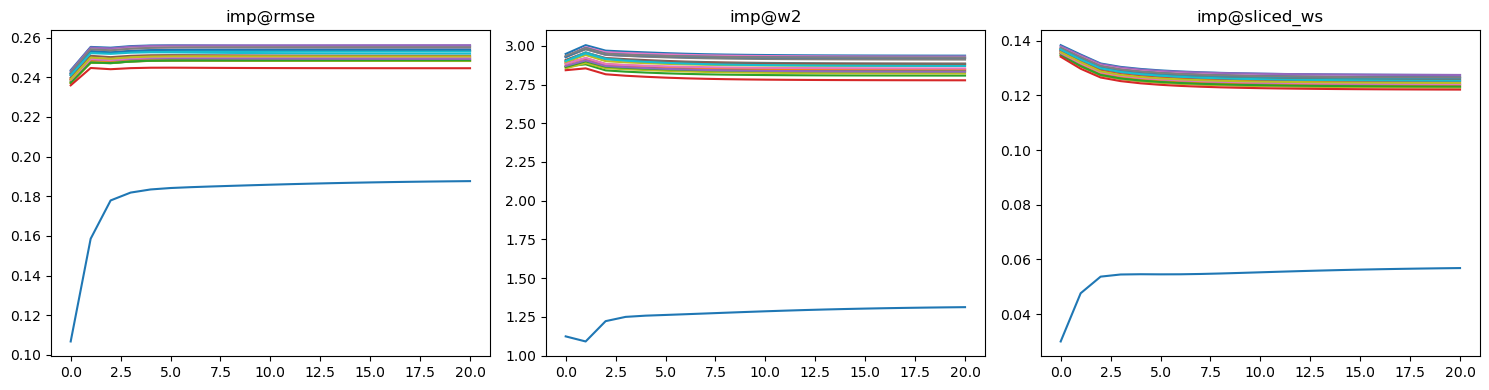

{'imp@rmse': 0.24827542933344932, 'imp@ws': 2.795582344990844, 'imp@sliced_ws': 0.12180314299253706}


In [47]:
name = 'mnar_rl21_fedavg-s'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'nhis_income_pca'
config2['num_clients'] = 21
mr_strategy = 'fixed@mr=0.5'
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremer1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [48]:
pred_ret = NN_evaluation(
    rets['mnar_rl21_fedavg-s'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

2023-07-27 16:22:45.925 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 0, test_accu: 0.6141, test_f1: 0.5744 test_auroc: 0.7037 train_loss: 0.6736 val_accu: 0.6867 val_f1: 0.6391
2023-07-27 16:23:16.869 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 100, test_accu: 0.7896, test_f1: 0.7884 test_auroc: 0.8490 train_loss: 0.4412 val_accu: 0.8012 val_f1: 0.7993
2023-07-27 16:23:46.825 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 200, test_accu: 0.7252, test_f1: 0.7256 test_auroc: 0.8327 train_loss: 0.4217 val_accu: 0.7797 val_f1: 0.7794
2023-07-27 16:24:16.605 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 300, test_accu: 0.7601, test_f1: 0.7589 test_auroc: 0.8394 train_loss: 0.4052 val_accu: 0.8137 val_f1: 0.8071
2023-07-27 16:24:47.084 | INFO     | src.fed_imp.sub_modules.server.pred_server_ce

0.7909527073337903


Shape of raw data:  (16868, 1418)
Shape of data after dropping columns only contains one value:  (14585, 1392)
Shape of data after dropping high cardinality columns:  (14585, 1390)
Shape of data remove columns with missing values:  (14585, 406)
['WTIA_HH', 'WTFA_HH', 'WTFA_FAM', 'WTIA', 'WTFA', 'WTIA_SA', 'WTFA_SA']
['INCGRP4', 'INCGRP5', 'RAT_CAT5', 'RAT_CAT4', 'BMI', 'AGE_P', 'WRKMYR', 'EDUC1', 'PRIVATE', 'HIKINDNA']
(14585, 103)
(14585, 103) (14585, 7) (14585,)
Shape of data after one-hot encoding:  (14585, 104)
Shape of data after PCA: (14585, 30)
sample-evenly {}
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_qu

2023-07-27 16:25:32.047 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 16:25:32.048 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-07-27 16:28:11.990 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 16:28:11.991 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-07-27 16:30:48.743 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 16:30:48.744 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-07-27 16:31:03.993 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 335.62448060000315


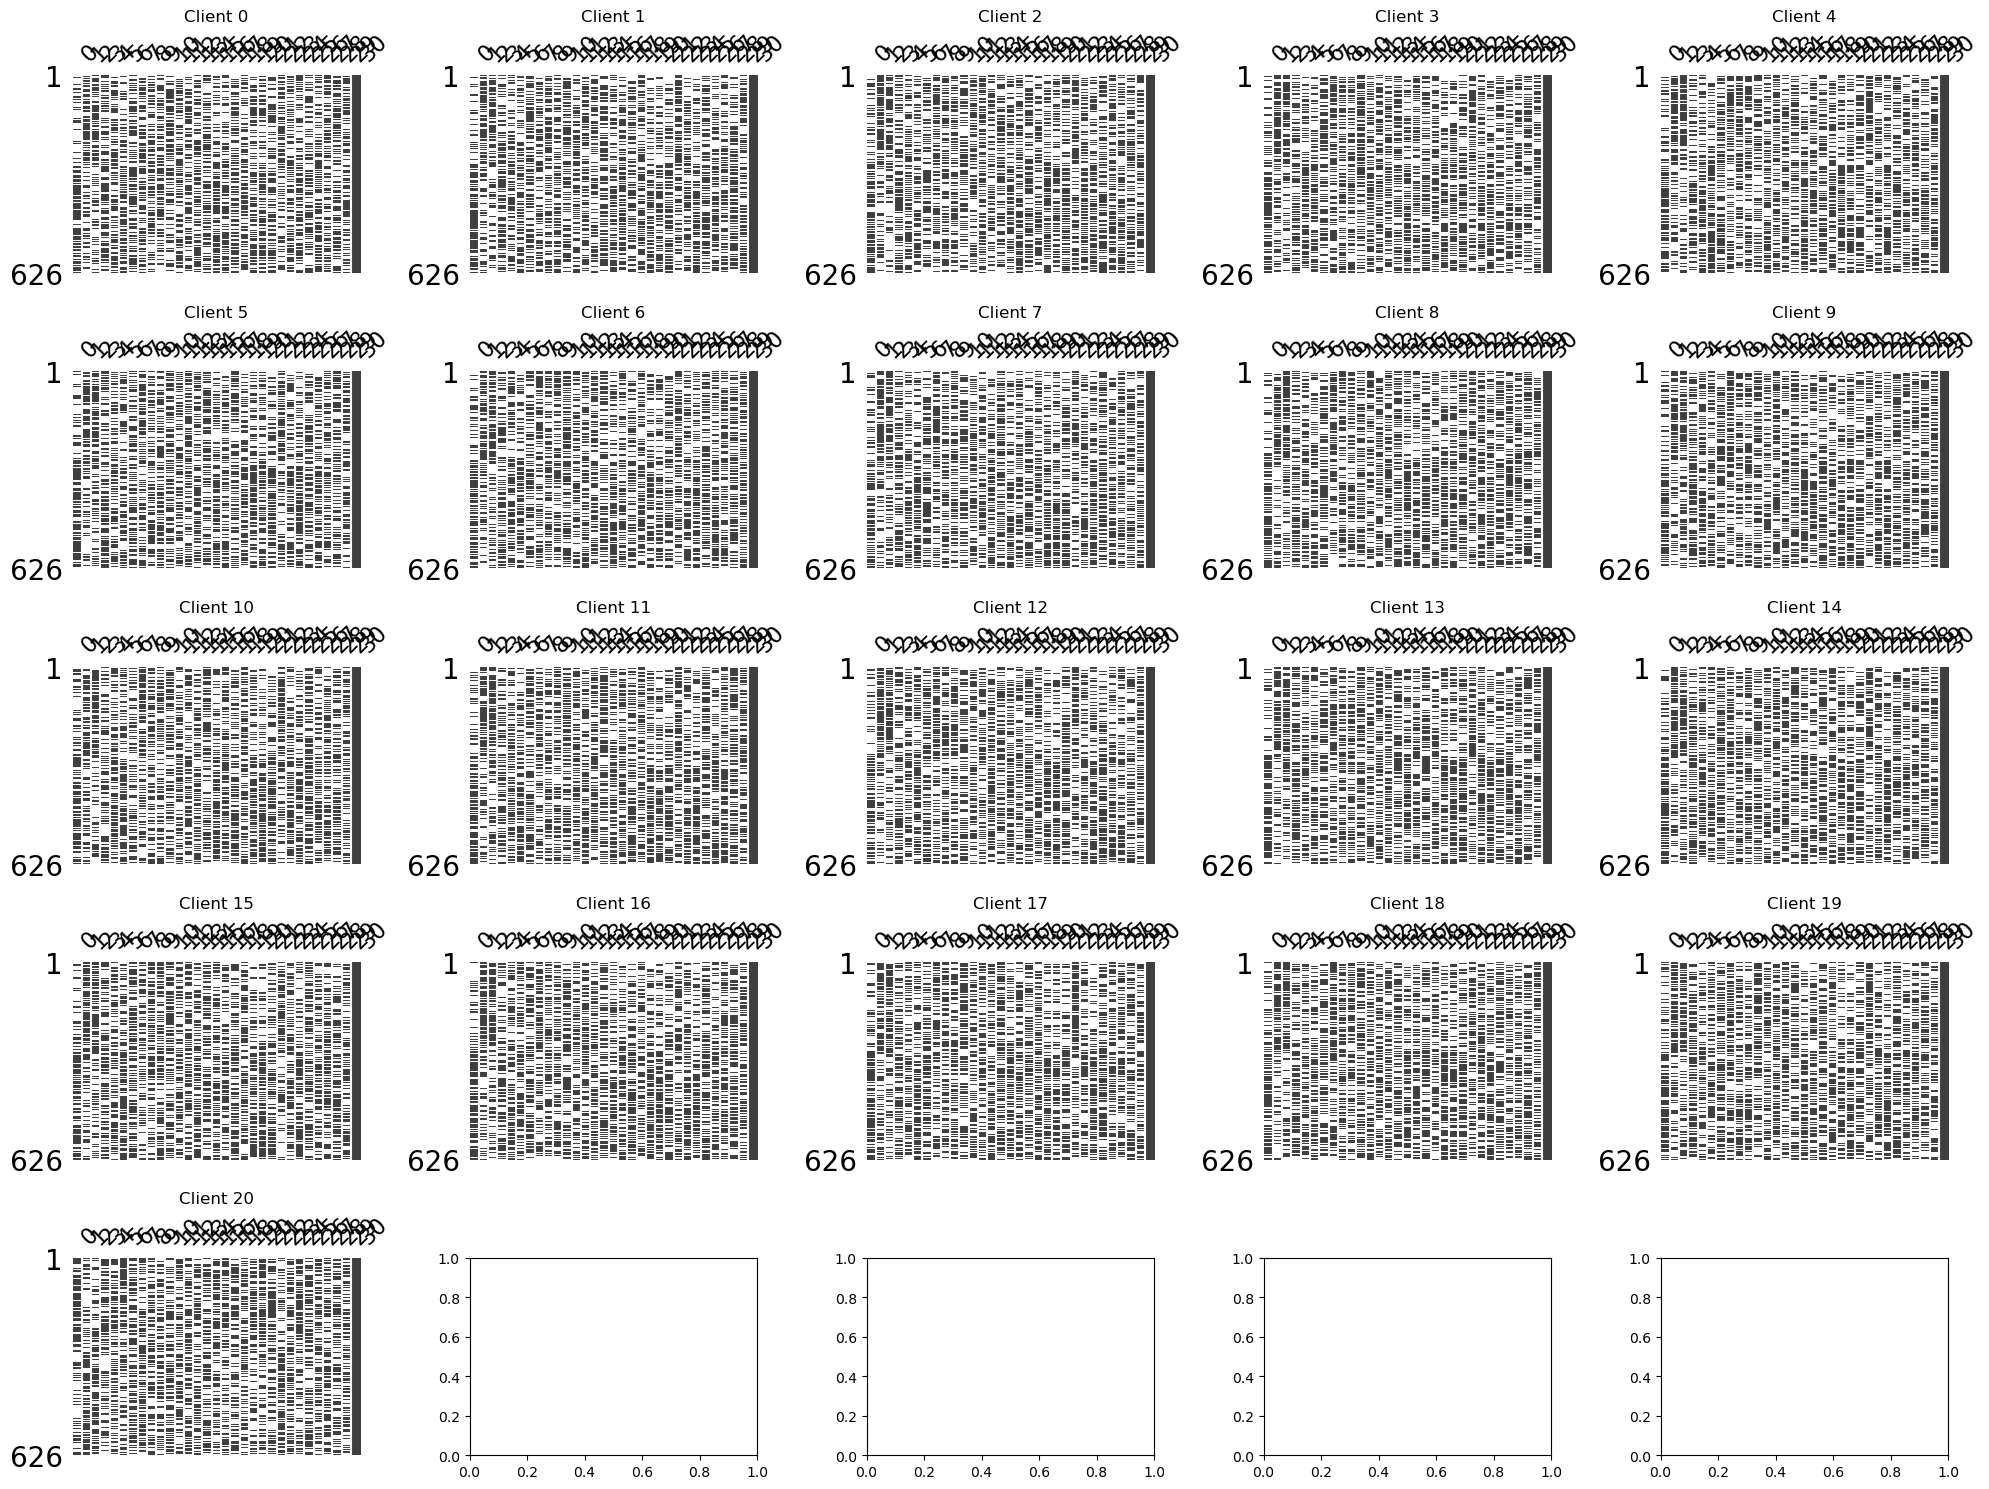

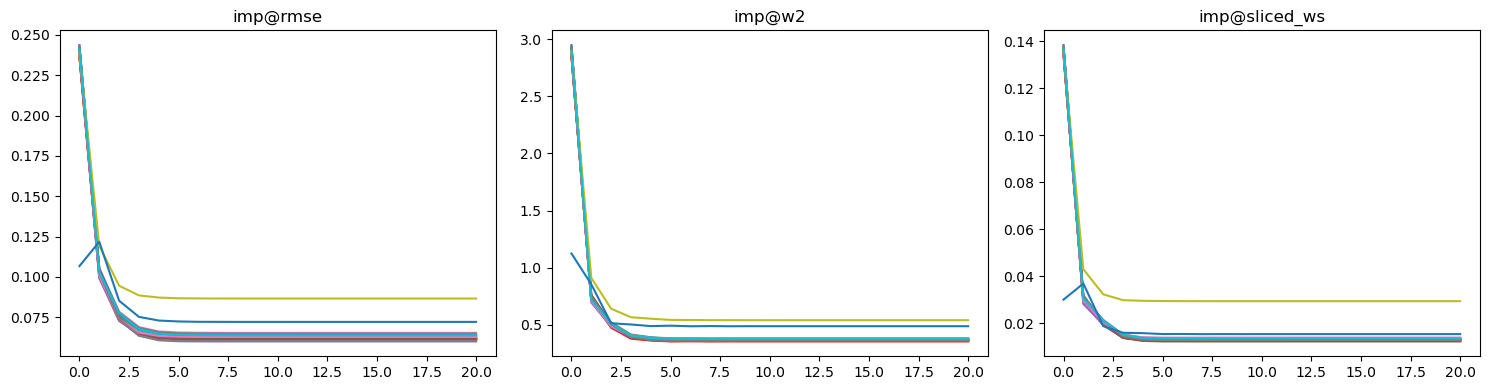

{'imp@rmse': 0.06410623520381417, 'imp@ws': 0.38160492302978843, 'imp@sliced_ws': 0.013834209522756666}


In [49]:
name = 'mnar_rl21_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'nhis_income_pca'
config2['num_clients'] = 21
mr_strategy = 'fixed@mr=0.5'
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremer1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [50]:
pred_ret = NN_evaluation(
    rets['mnar_rl21_fedmechw'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

2023-07-27 16:31:10.065 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 0, test_accu: 0.6799, test_f1: 0.6345 test_auroc: 0.8646 train_loss: 0.6730 val_accu: 0.6640 val_f1: 0.5967
2023-07-27 16:31:36.905 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 100, test_accu: 0.8252, test_f1: 0.8243 test_auroc: 0.8962 train_loss: 0.3588 val_accu: 0.8375 val_f1: 0.8355
2023-07-27 16:32:05.407 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 200, test_accu: 0.8225, test_f1: 0.8222 test_auroc: 0.8957 train_loss: 0.3555 val_accu: 0.8348 val_f1: 0.8336
2023-07-27 16:32:33.294 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 300, test_accu: 0.8307, test_f1: 0.8291 test_auroc: 0.8945 train_loss: 0.3446 val_accu: 0.8398 val_f1: 0.8368
2023-07-27 16:33:01.139 | INFO     | src.fed_imp.sub_modules.server.pred_server_ce

0.8361891706648389


Shape of raw data:  (16868, 1418)
Shape of data after dropping columns only contains one value:  (14585, 1392)
Shape of data after dropping high cardinality columns:  (14585, 1390)
Shape of data remove columns with missing values:  (14585, 406)
['WTIA_HH', 'WTFA_HH', 'WTFA_FAM', 'WTIA', 'WTFA', 'WTIA_SA', 'WTFA_SA']
['INCGRP4', 'INCGRP5', 'RAT_CAT5', 'RAT_CAT4', 'BMI', 'AGE_P', 'WRKMYR', 'EDUC1', 'PRIVATE', 'HIKINDNA']
(14585, 103)
(14585, 103) (14585, 7) (14585,)
Shape of data after one-hot encoding:  (14585, 104)
Shape of data after PCA: (14585, 30)
sample-evenly {}
21
[1, 20]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_rig

2023-07-27 14:16:51.862 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 14:16:51.863 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-07-27 14:18:53.740 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 14:18:53.741 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-07-27 14:21:02.525 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 14:21:02.526 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-07-27 14:21:15.469 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 265.82502430002205


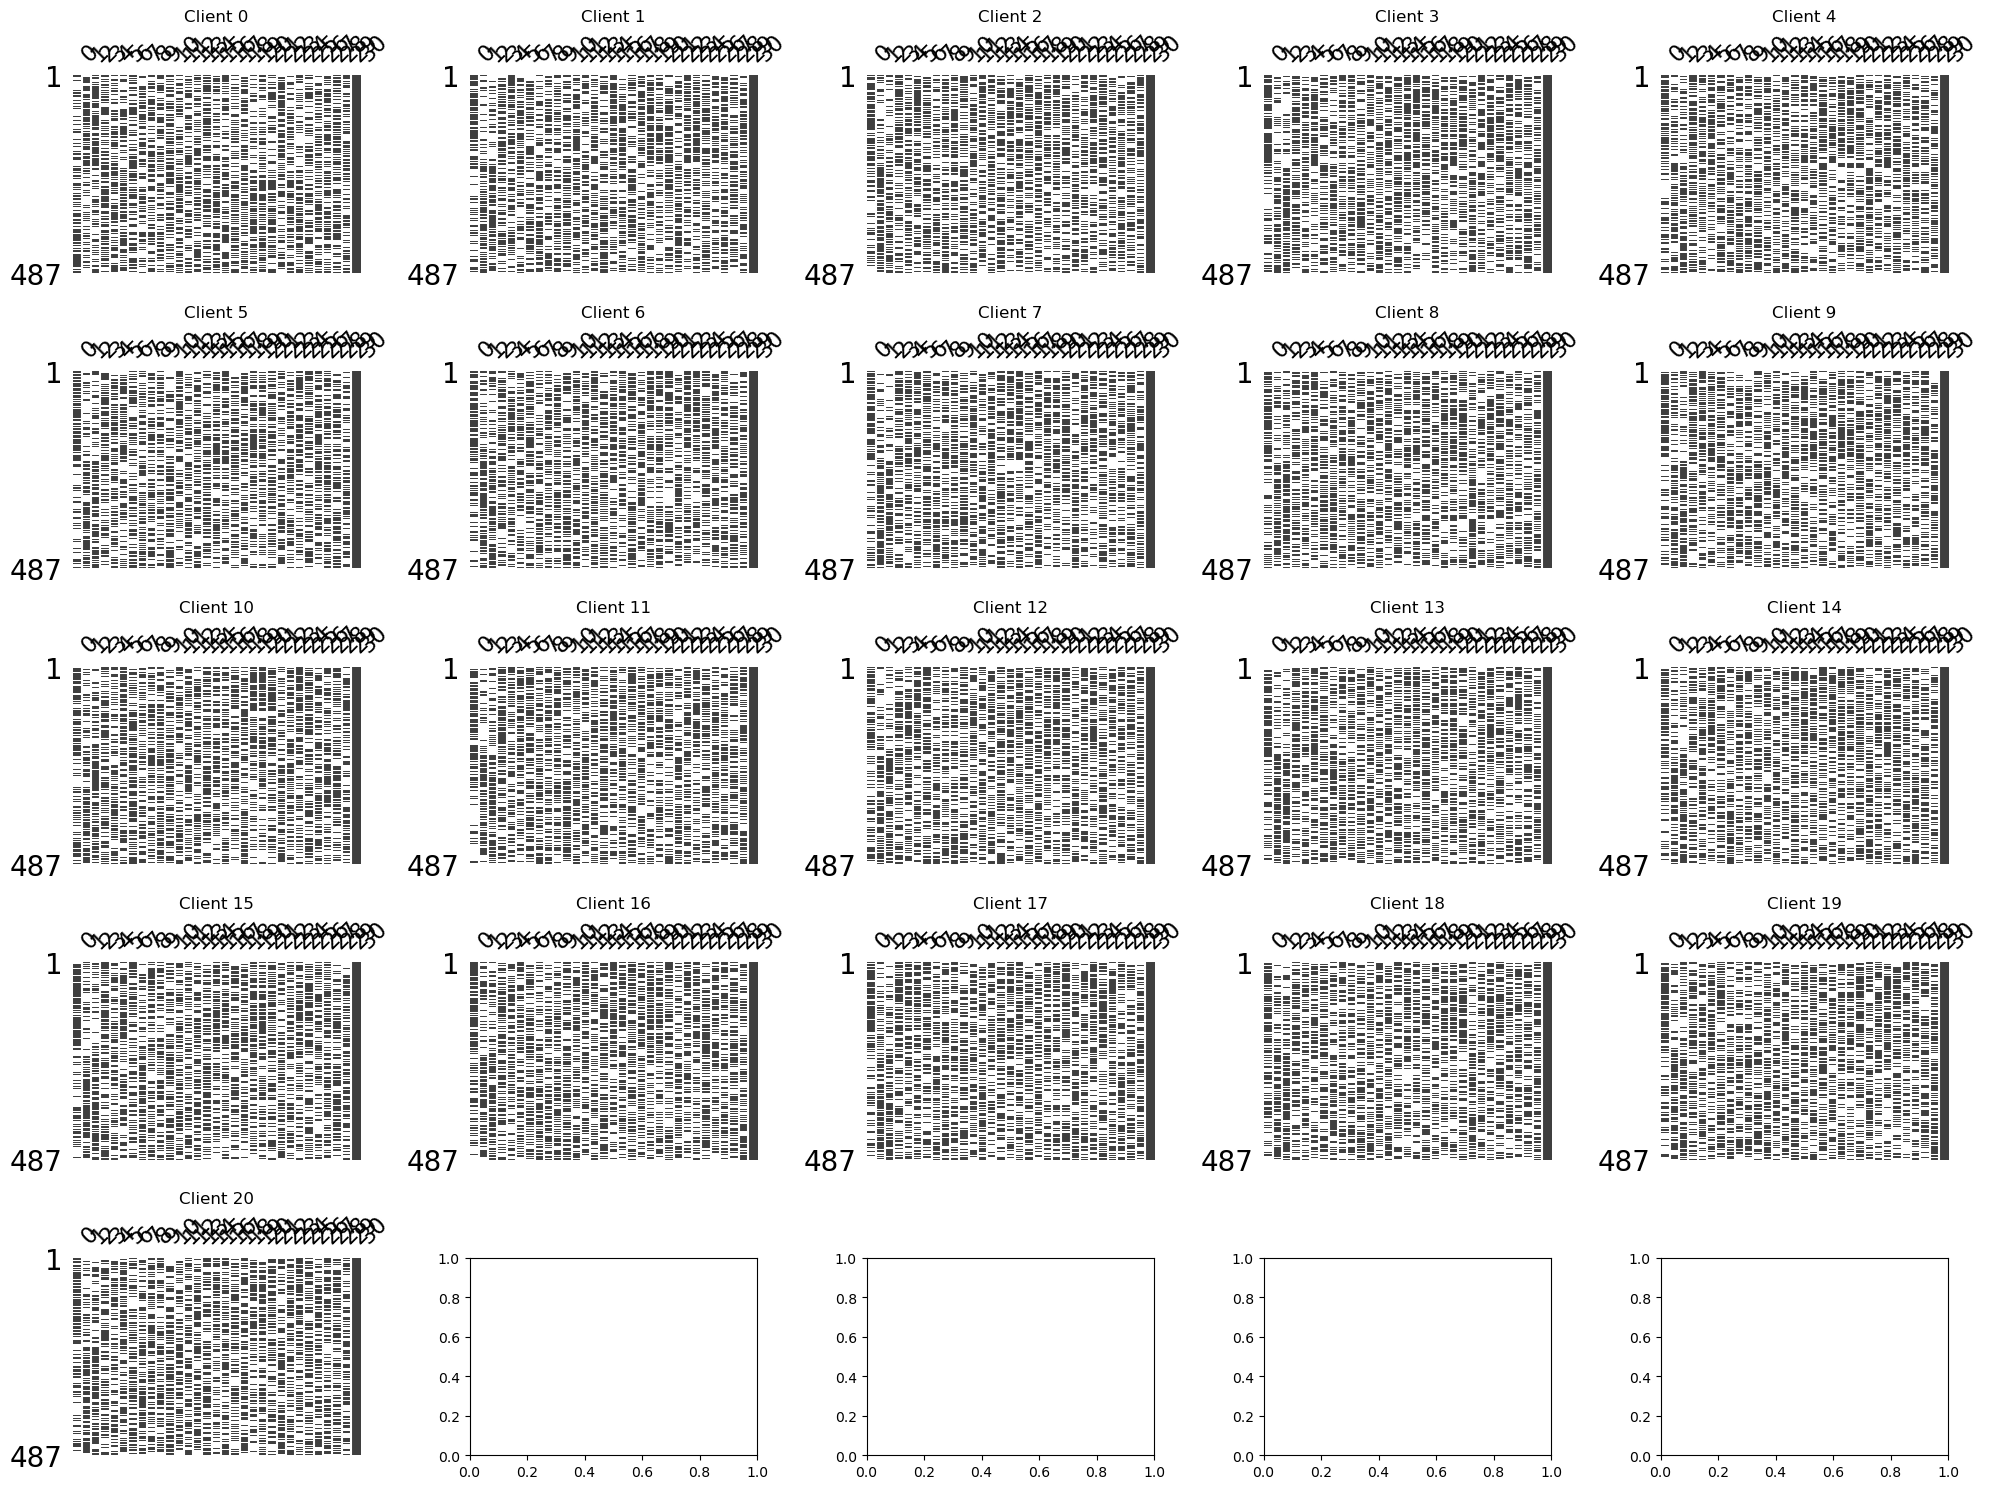

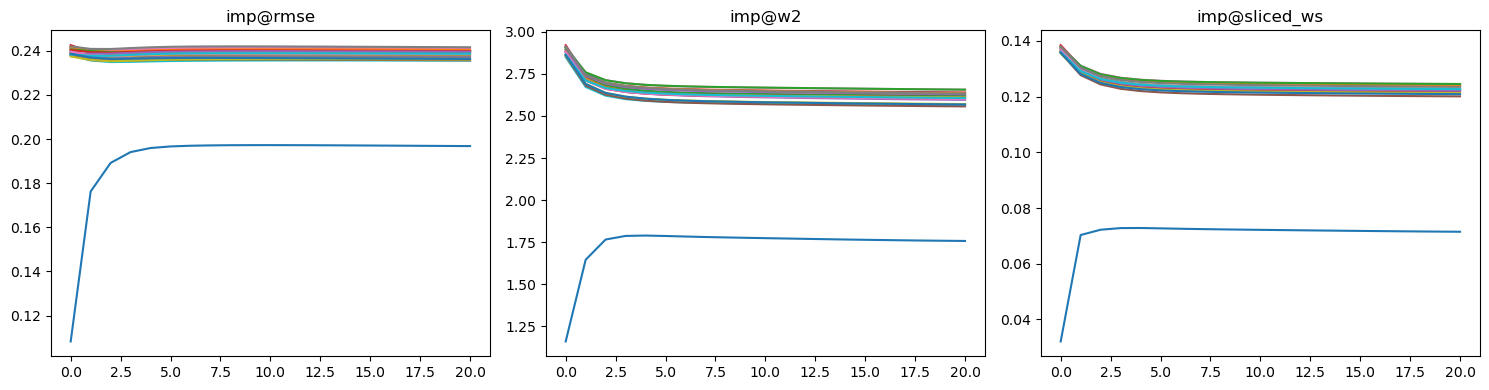

{'imp@rmse': 0.2366340876297738, 'imp@ws': 2.570662498091854, 'imp@sliced_ws': 0.12033136114426052}


In [21]:
name = 'mnar_lr21_fedavg-s'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'nhis_income_pca'
config2['num_clients'] = 21
mr_strategy = 'fixed@mr=0.5'
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [43]:
pred_ret = NN_evaluation(
    rets['mnar_lr21_fedavg-s'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

2023-07-27 16:05:05.897 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 0, test_accu: 0.5427, test_f1: 0.3819 test_auroc: 0.6539 train_loss: 0.6871 val_accu: 0.5408 val_f1: 0.3510
2023-07-27 16:05:29.119 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 100, test_accu: 0.7822, test_f1: 0.7797 test_auroc: 0.8553 train_loss: 0.4553 val_accu: 0.7823 val_f1: 0.7782
2023-07-27 16:05:54.127 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 200, test_accu: 0.7950, test_f1: 0.7937 test_auroc: 0.8649 train_loss: 0.4439 val_accu: 0.7886 val_f1: 0.7851
2023-07-27 16:06:18.931 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 300, test_accu: 0.7952, test_f1: 0.7944 test_auroc: 0.8680 train_loss: 0.4278 val_accu: 0.7891 val_f1: 0.7857
2023-07-27 16:06:43.296 | INFO     | src.fed_imp.sub_modules.server.pred_server_ce

0.803473491773309


Shape of raw data:  (16868, 1418)
Shape of data after dropping columns only contains one value:  (14585, 1392)
Shape of data after dropping high cardinality columns:  (14585, 1390)
Shape of data remove columns with missing values:  (14585, 406)
['WTIA_HH', 'WTFA_HH', 'WTFA_FAM', 'WTIA', 'WTFA', 'WTIA_SA', 'WTFA_SA']
['INCGRP4', 'INCGRP5', 'RAT_CAT5', 'RAT_CAT4', 'BMI', 'AGE_P', 'WRKMYR', 'EDUC1', 'PRIVATE', 'HIKINDNA']
(14585, 103)
(14585, 103) (14585, 7) (14585,)
Shape of data after one-hot encoding:  (14585, 104)
Shape of data after PCA: (14585, 30)
sample-evenly {}
21
[1, 20]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_rig

2023-07-27 16:07:23.029 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 16:07:23.030 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-07-27 16:09:48.191 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 16:09:48.192 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-07-27 16:12:23.887 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-07-27 16:12:23.888 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-07-27 16:12:40.162 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 320.50958100007847


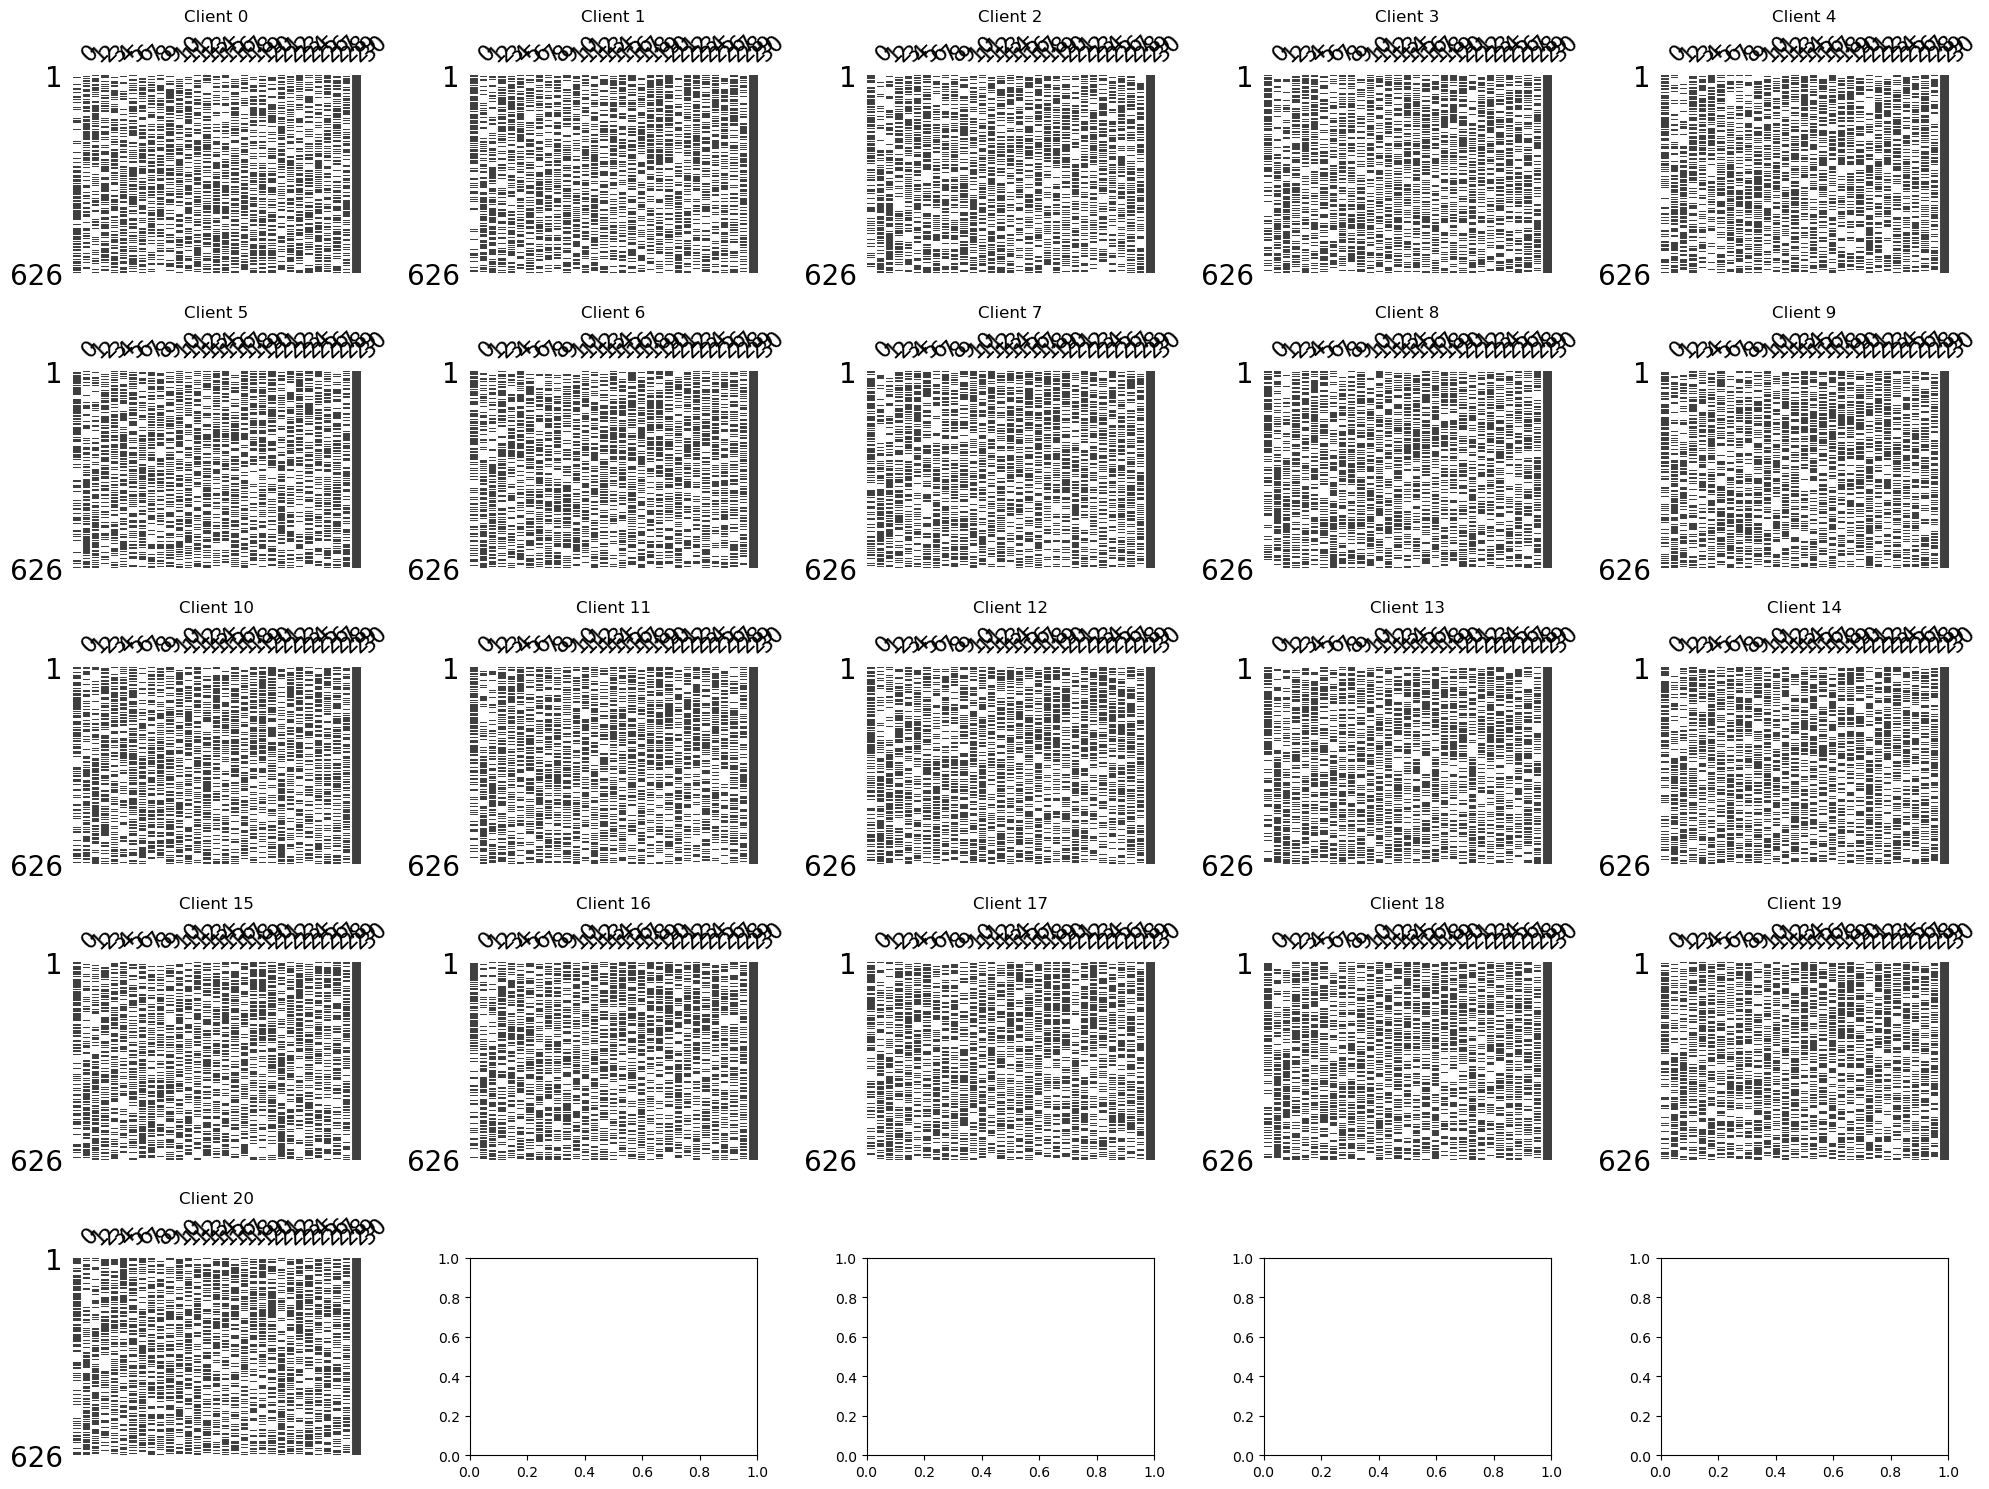

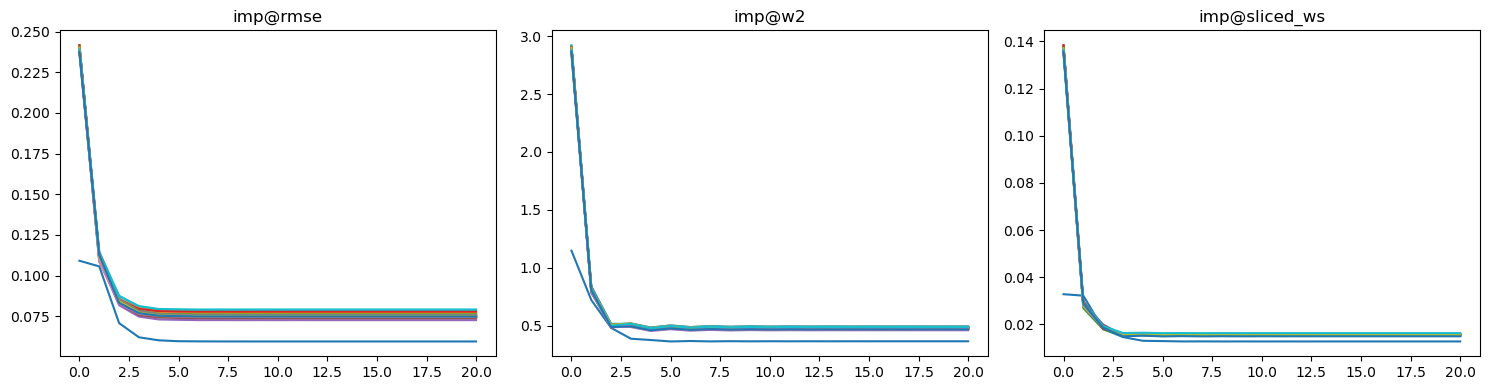

{'imp@rmse': 0.07473739430885001, 'imp@ws': 0.4733449542955336, 'imp@sliced_ws': 0.015504903588336191}


In [44]:
name = 'mnar_lr21_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'nhis_income_pca'
config2['num_clients'] = 21
mr_strategy = 'fixed@mr=0.5'
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [45]:
pred_ret = NN_evaluation(
    rets['mnar_lr21_fedmechw'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

2023-07-27 16:12:50.843 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 0, test_accu: 0.6957, test_f1: 0.6577 test_auroc: 0.8546 train_loss: 0.6711 val_accu: 0.6814 val_f1: 0.6306
2023-07-27 16:13:20.073 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 100, test_accu: 0.8197, test_f1: 0.8184 test_auroc: 0.8890 train_loss: 0.3624 val_accu: 0.8367 val_f1: 0.8340
2023-07-27 16:13:49.513 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 200, test_accu: 0.7992, test_f1: 0.7993 test_auroc: 0.8887 train_loss: 0.3618 val_accu: 0.8371 val_f1: 0.8357
2023-07-27 16:14:18.749 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 300, test_accu: 0.8143, test_f1: 0.8132 test_auroc: 0.8908 train_loss: 0.3510 val_accu: 0.8394 val_f1: 0.8369
2023-07-27 16:14:48.260 | INFO     | src.fed_imp.sub_modules.server.pred_server_ce

0.8259081562714188


# Heart

In [10]:
trackers = {}
rets ={}
mr_strategy = 'fixed@mr=0.5'

## Clients MNAR LR - Balanced

### Simple Averaging

['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']
(319795, 25)
(319795, 25)
(54746, 25)
(54746, 25)
(50000, 25)
(45000, 25)
sample-evenly {}
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(5000, 25)


2023-08-01 18:12:48.036 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-01 18:12:48.037 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-01 18:16:31.555 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-01 18:16:31.555 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-01 18:20:13.913 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-01 18:20:13.914 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-01 18:20:36.233 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 482.8791132000042


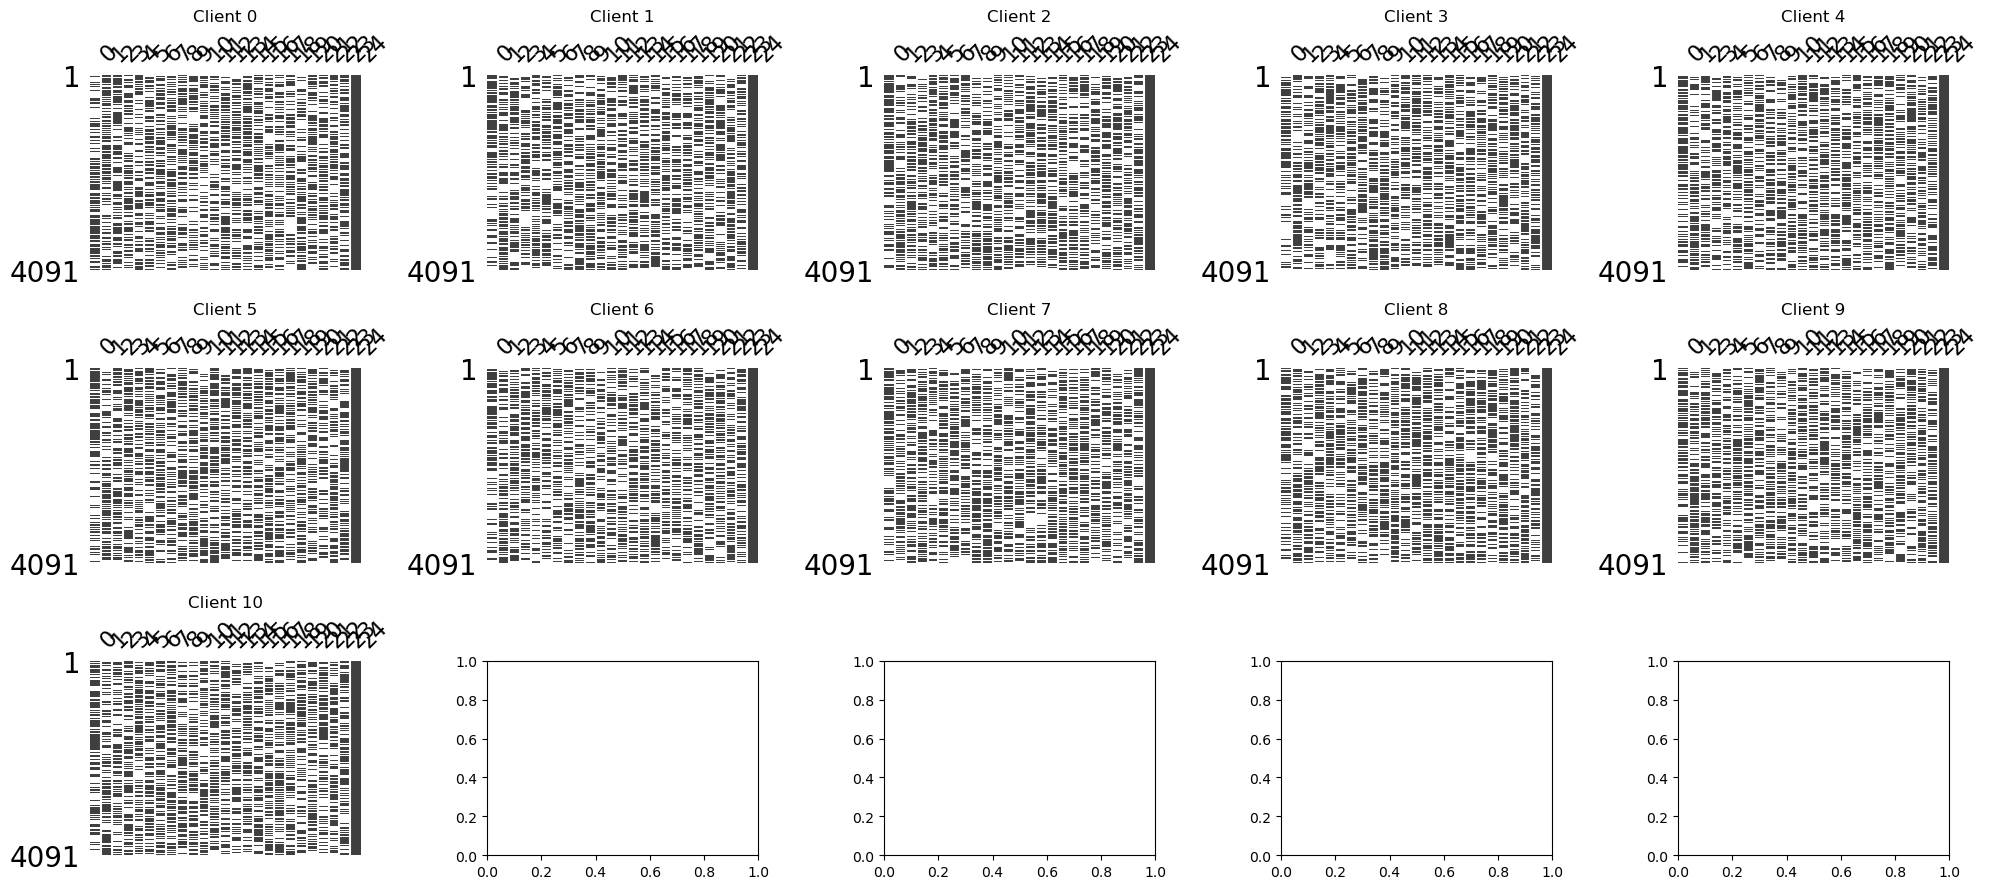

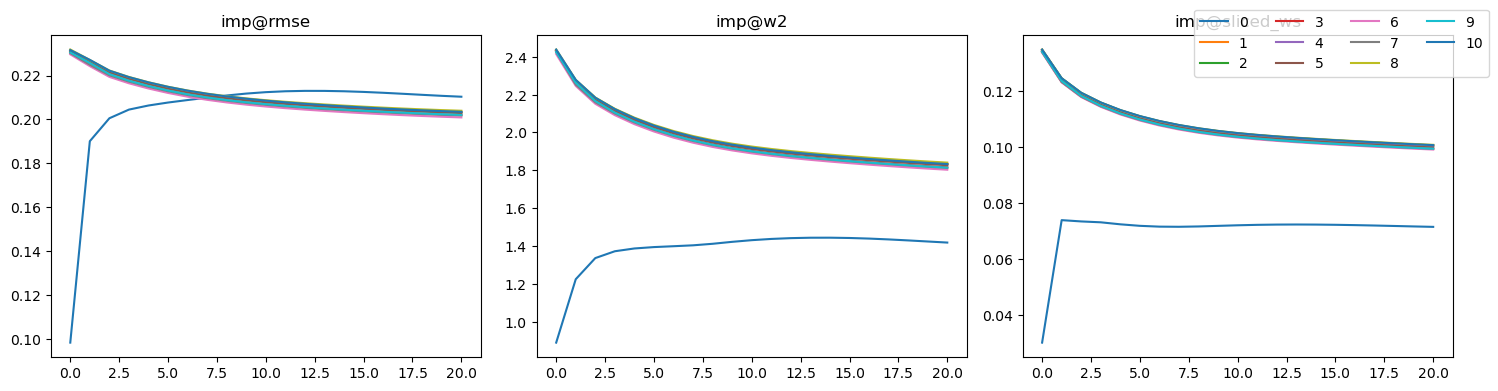

{'imp@rmse': 0.20412941892393086, 'imp@ws': 1.8002466479764994, 'imp@sliced_ws': 0.09795533779121592}


2023-08-01 18:20:58.517 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 0, test_accu: 0.7102, test_f1: 0.7077 test_auroc: 0.7886 train_loss: 0.6439 val_accu: 0.6720 val_f1: 0.6676
2023-08-01 18:22:21.843 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 100, test_accu: 0.7258, test_f1: 0.7246 test_auroc: 0.7965 train_loss: 0.5443 val_accu: 0.7315 val_f1: 0.7306
2023-08-01 18:23:45.213 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 200, test_accu: 0.7246, test_f1: 0.7242 test_auroc: 0.7907 train_loss: 0.5379 val_accu: 0.7312 val_f1: 0.7312
2023-08-01 18:25:09.513 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 300, test_accu: 0.7254, test_f1: 0.7251 test_auroc: 0.7929 train_loss: 0.5363 val_accu: 0.7287 val_f1: 0.7287
2023-08-01 18:26:33.683 | INFO     | src.fed_imp.sub_modules.server.pred_server_ce

0.7358


In [12]:
name = 'mnar_lr_heart_fedavg-s'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'heart_balanced'
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

pred_ret = NN_evaluation(
    rets[name], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

### Ours

['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']
(319795, 25)
(319795, 25)
(54746, 25)
(54746, 25)
(50000, 25)
(45000, 25)
sample-evenly {}
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(5000, 25)


2023-08-01 18:28:24.304 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-01 18:28:24.304 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-01 18:31:47.297 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-01 18:31:47.298 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-01 18:35:26.401 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-01 18:35:26.402 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-01 18:35:49.123 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 456.90139559999807


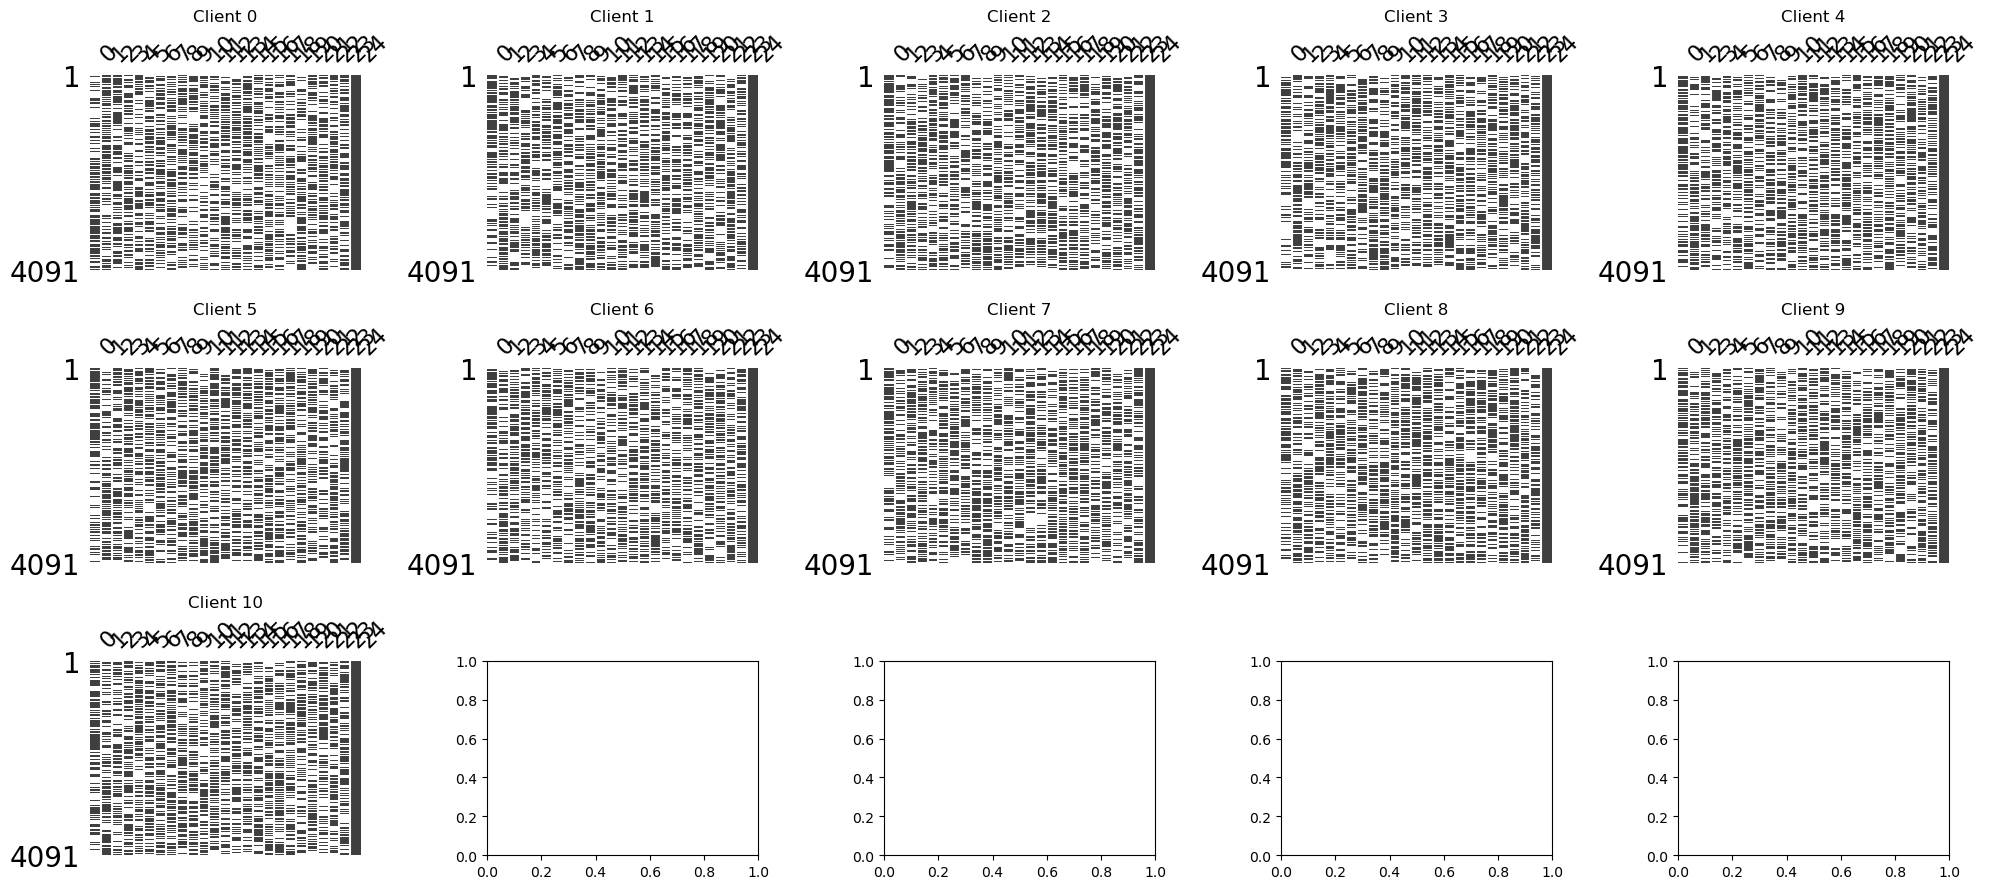

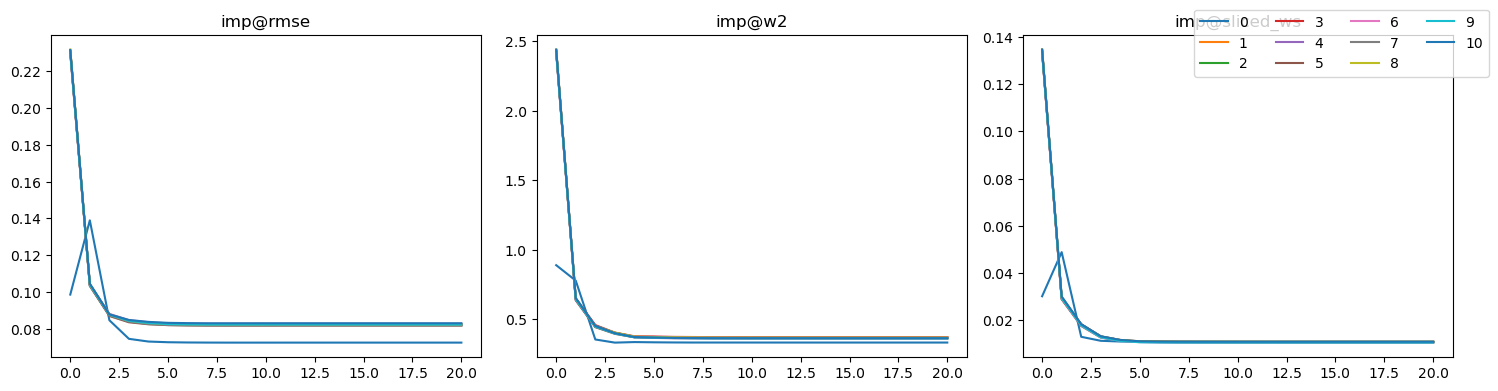

{'imp@rmse': 0.08133575939077997, 'imp@ws': 0.3641586239671035, 'imp@sliced_ws': 0.010839195949395478}


2023-08-01 18:35:53.133 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 0, test_accu: 0.7276, test_f1: 0.7255 test_auroc: 0.8159 train_loss: 0.6064 val_accu: 0.7258 val_f1: 0.7237
2023-08-01 18:37:14.579 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 100, test_accu: 0.7562, test_f1: 0.7558 test_auroc: 0.8326 train_loss: 0.5094 val_accu: 0.7562 val_f1: 0.7560
2023-08-01 18:38:35.789 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 200, test_accu: 0.7528, test_f1: 0.7523 test_auroc: 0.8312 train_loss: 0.5059 val_accu: 0.7562 val_f1: 0.7560
2023-08-01 18:39:57.182 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 300, test_accu: 0.7558, test_f1: 0.7542 test_auroc: 0.8324 train_loss: 0.5061 val_accu: 0.7547 val_f1: 0.7532
2023-08-01 18:41:17.758 | INFO     | src.fed_imp.sub_modules.server.pred_server_ce

0.7582


In [13]:
name = 'mnar_lr_heart_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'heart_balanced'
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

pred_ret = NN_evaluation(
    rets['mnar_lr_heart_fedmechw'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

## Client MNAR LR - Raw

### Simple Avg

['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']
(319795, 25)
(50000, 25)
(45000, 25)
sample-evenly {}
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(5000, 25)


2023-08-01 18:43:05.572 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-01 18:43:05.573 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-01 18:46:13.267 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-01 18:46:13.268 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-01 18:49:40.806 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-01 18:49:40.807 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-01 18:50:02.143 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 428.71156939998036


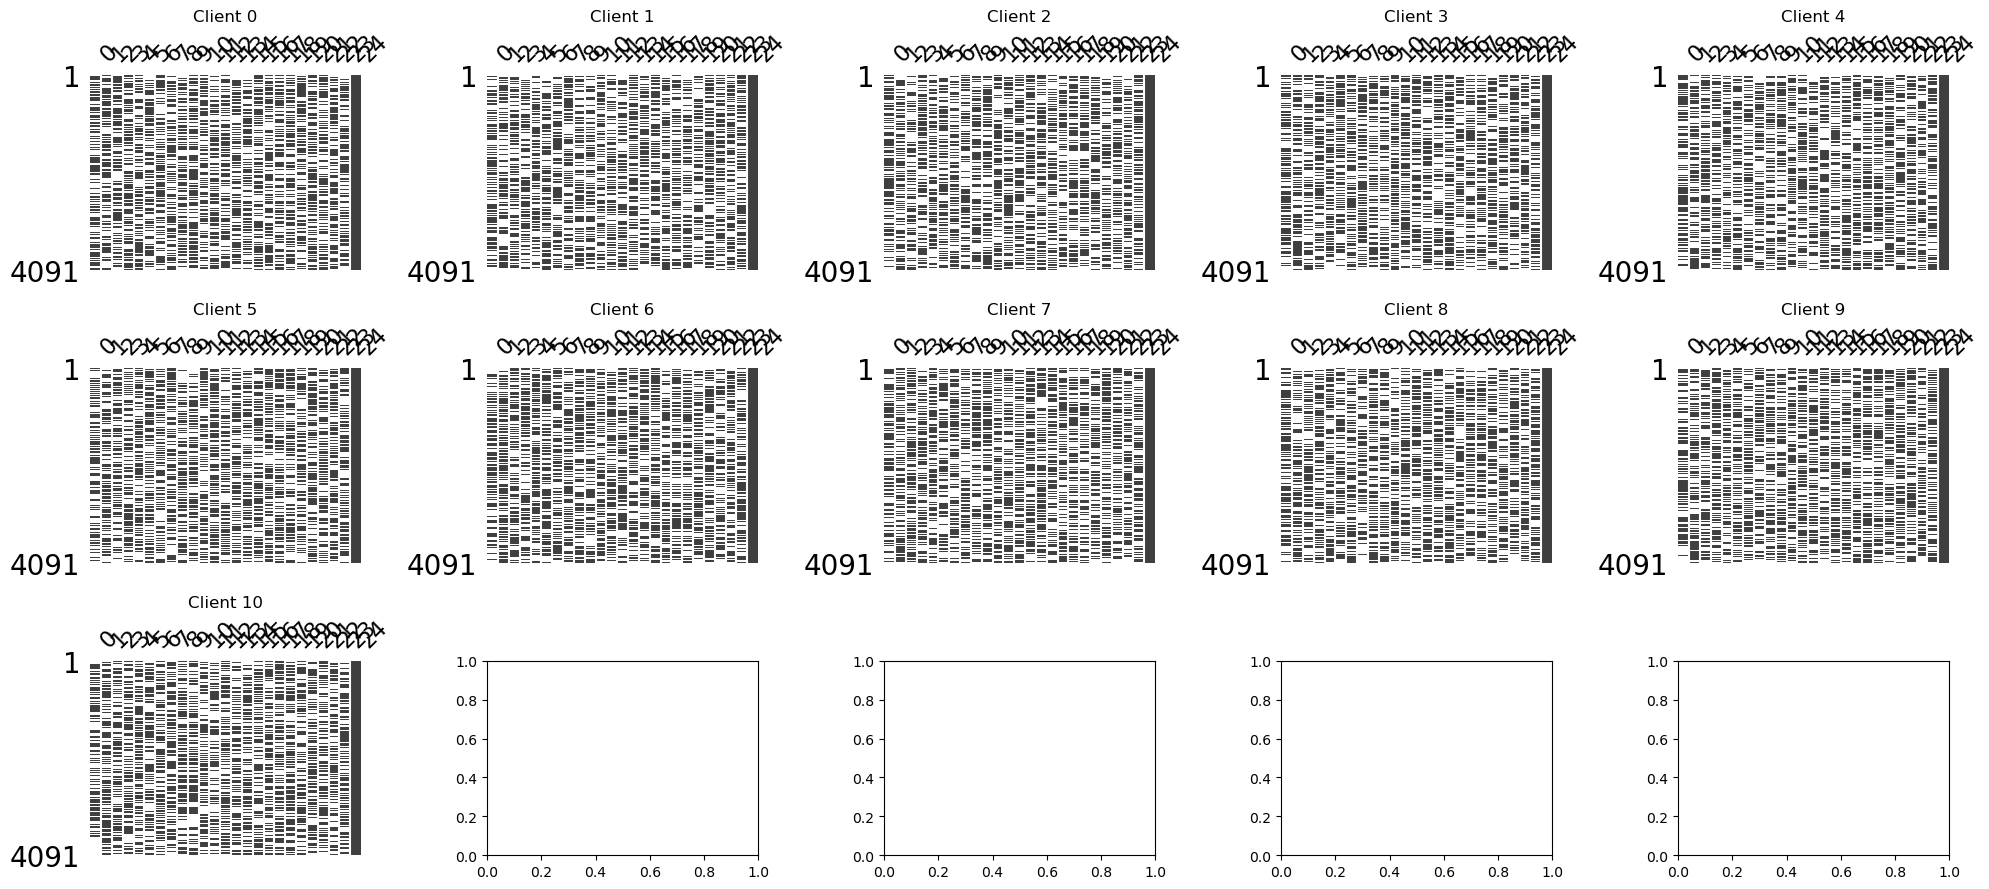

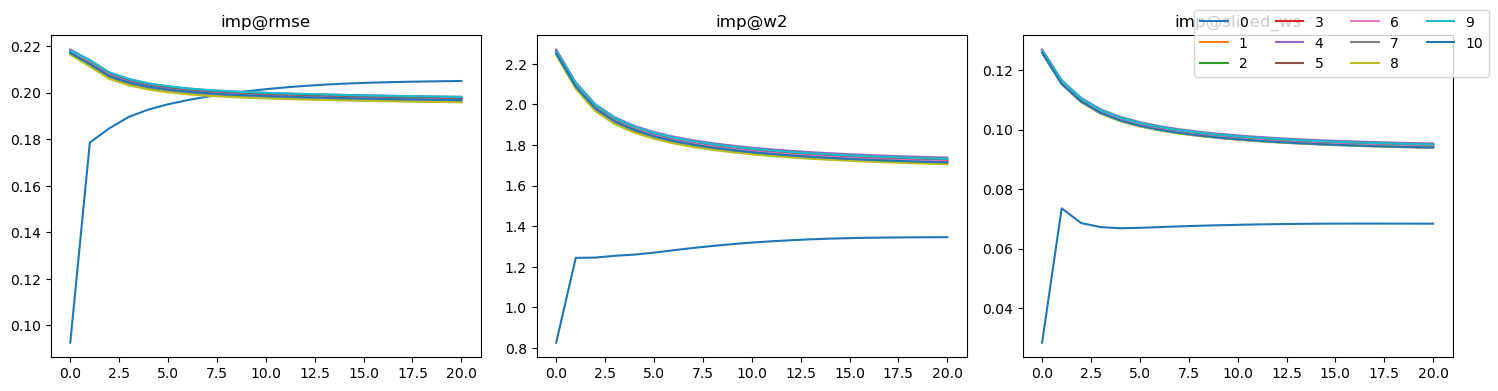

{'imp@rmse': 0.19801340163941497, 'imp@ws': 1.6923895062734227, 'imp@sliced_ws': 0.09241283634345057}


2023-08-01 18:50:06.200 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 0, test_accu: 0.9120, test_f1: 0.8700 test_auroc: 0.7555 train_loss: 0.3223 val_accu: 0.9121 val_f1: 0.4770
2023-08-01 18:51:26.245 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 100, test_accu: 0.9120, test_f1: 0.8700 test_auroc: 0.7942 train_loss: 0.2620 val_accu: 0.9121 val_f1: 0.4770
2023-08-01 18:52:44.882 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 200, test_accu: 0.9120, test_f1: 0.8700 test_auroc: 0.7982 train_loss: 0.2584 val_accu: 0.9121 val_f1: 0.4770
2023-08-01 18:54:05.262 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 300, test_accu: 0.9120, test_f1: 0.8700 test_auroc: 0.8010 train_loss: 0.2575 val_accu: 0.9121 val_f1: 0.4770
2023-08-01 18:55:25.436 | INFO     | src.fed_imp.sub_modules.server.pred_server_ce

0.912


In [14]:
name = 'mnar_lr_heart_fedavg-s'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'heart'
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

pred_ret = NN_evaluation(
    rets[name], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

### Ours

['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']
(319795, 25)
(50000, 25)
(45000, 25)
sample-evenly {}
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(5000, 25)


2023-08-01 18:57:13.840 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-01 18:57:13.841 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-01 19:00:27.842 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-01 19:00:27.843 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-01 19:03:59.988 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-01 19:03:59.989 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-01 19:04:21.887 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 440.1862257999601


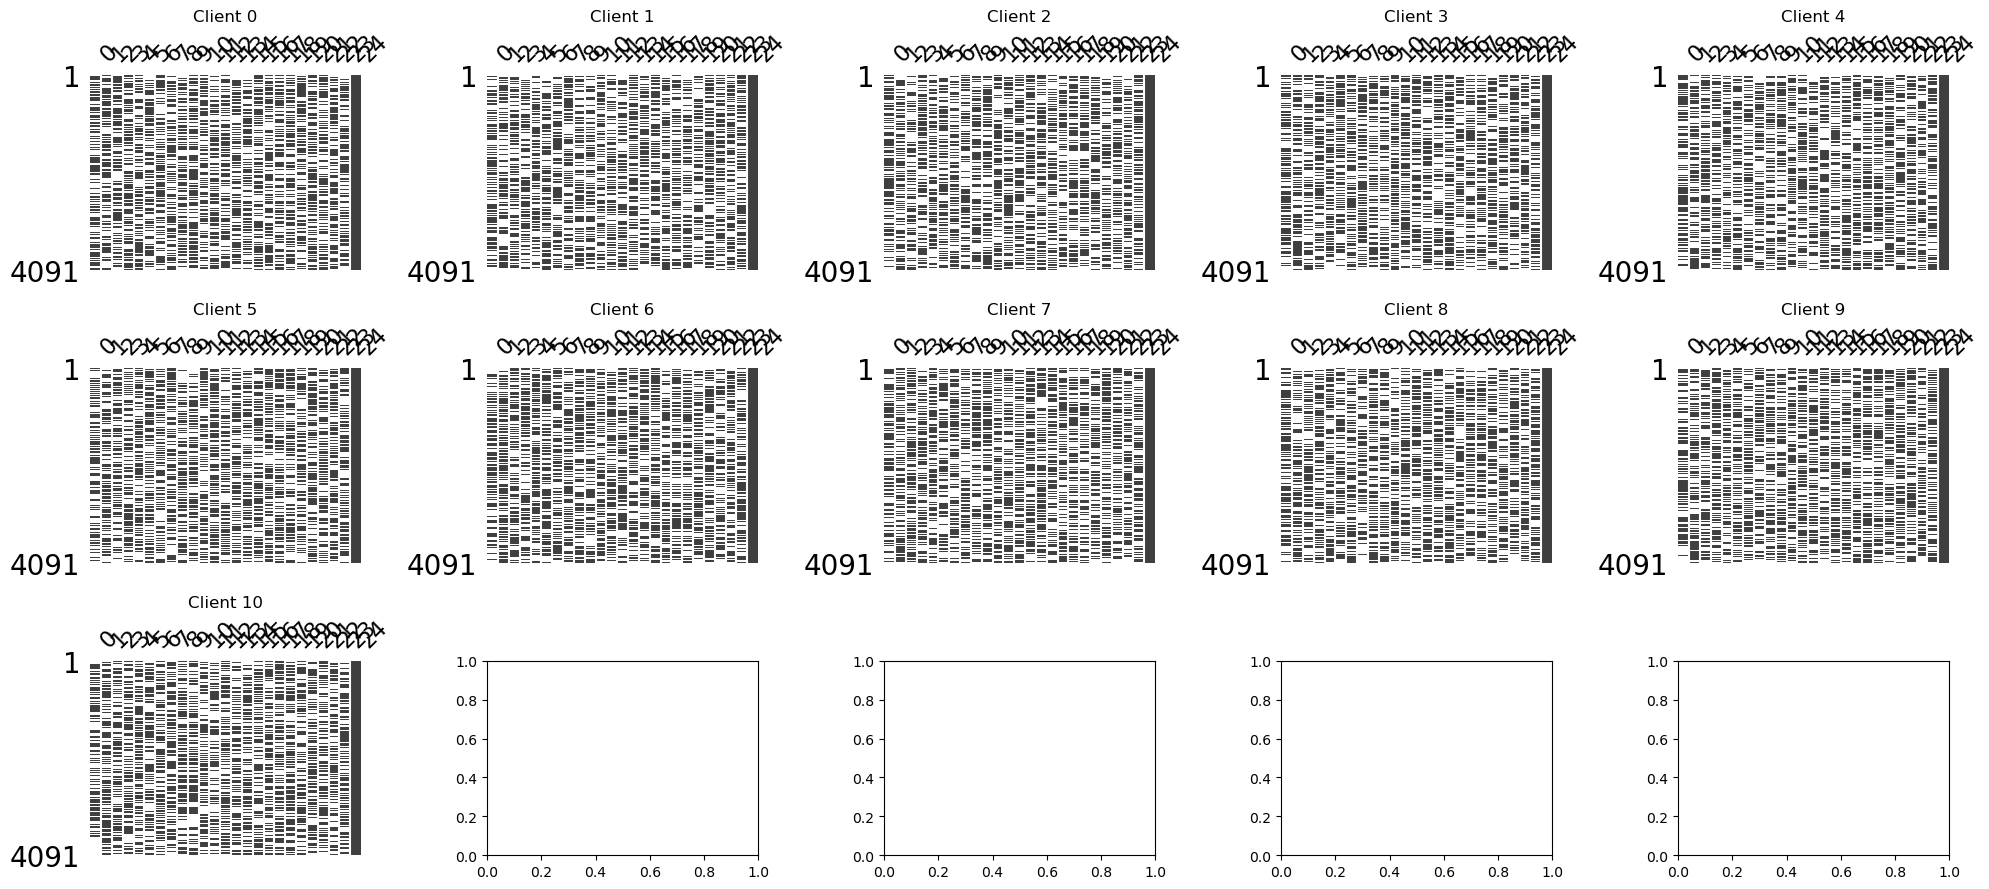

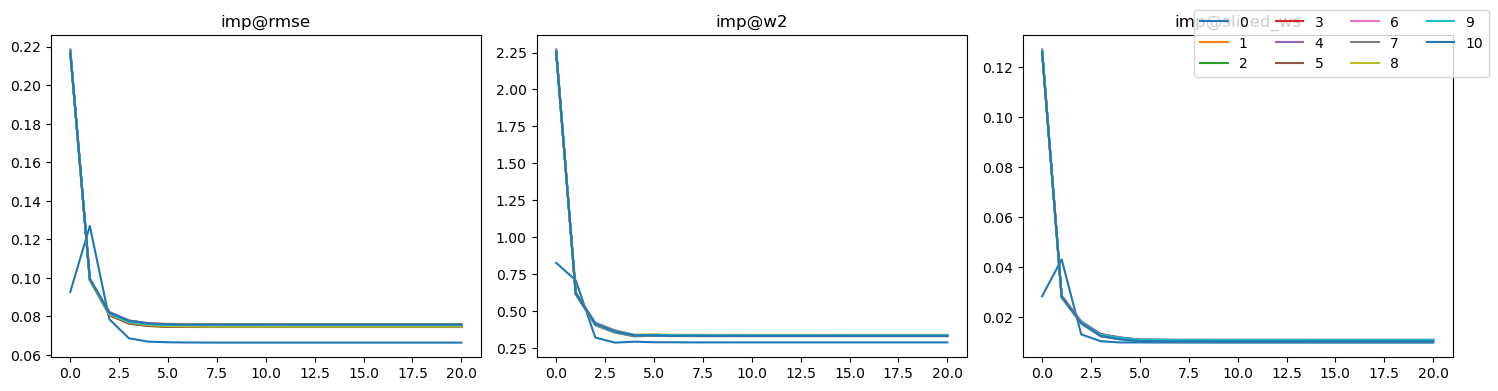

{'imp@rmse': 0.0743902782825569, 'imp@ws': 0.328249800600834, 'imp@sliced_ws': 0.01063680990220248}


2023-08-01 19:04:25.917 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 0, test_accu: 0.9120, test_f1: 0.8700 test_auroc: 0.7797 train_loss: 0.3200 val_accu: 0.9121 val_f1: 0.4770
2023-08-01 19:05:48.468 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 100, test_accu: 0.9120, test_f1: 0.8700 test_auroc: 0.8250 train_loss: 0.2457 val_accu: 0.9121 val_f1: 0.4770
2023-08-01 19:07:10.470 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 200, test_accu: 0.9120, test_f1: 0.8700 test_auroc: 0.8276 train_loss: 0.2440 val_accu: 0.9121 val_f1: 0.4770
2023-08-01 19:08:32.771 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 300, test_accu: 0.9132, test_f1: 0.8751 test_auroc: 0.8283 train_loss: 0.2429 val_accu: 0.9126 val_f1: 0.5001
2023-08-01 19:09:55.323 | INFO     | src.fed_imp.sub_modules.server.pred_server_ce

0.9144


In [15]:
name = 'mnar_lr_heart_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'heart'
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

pred_ret = NN_evaluation(
    rets['mnar_lr_heart_fedmechw'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

# CodRNA

In [24]:
trackers = {}
rets ={}
mr_strategy = 'fixed@mr=0.5'

### Clients MNAR LR - Raw

d:\E\miniconda\envs\fed_imp\lib\site-packages\dython\nominal.py:298: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9)
sample-evenly {}
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(2000, 9)


2023-08-01 23:01:40.863 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-01 23:01:40.864 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-01 23:02:52.035 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-01 23:02:52.035 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-01 23:03:56.920 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-01 23:03:56.921 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-01 23:04:03.161 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 146.77019060001476


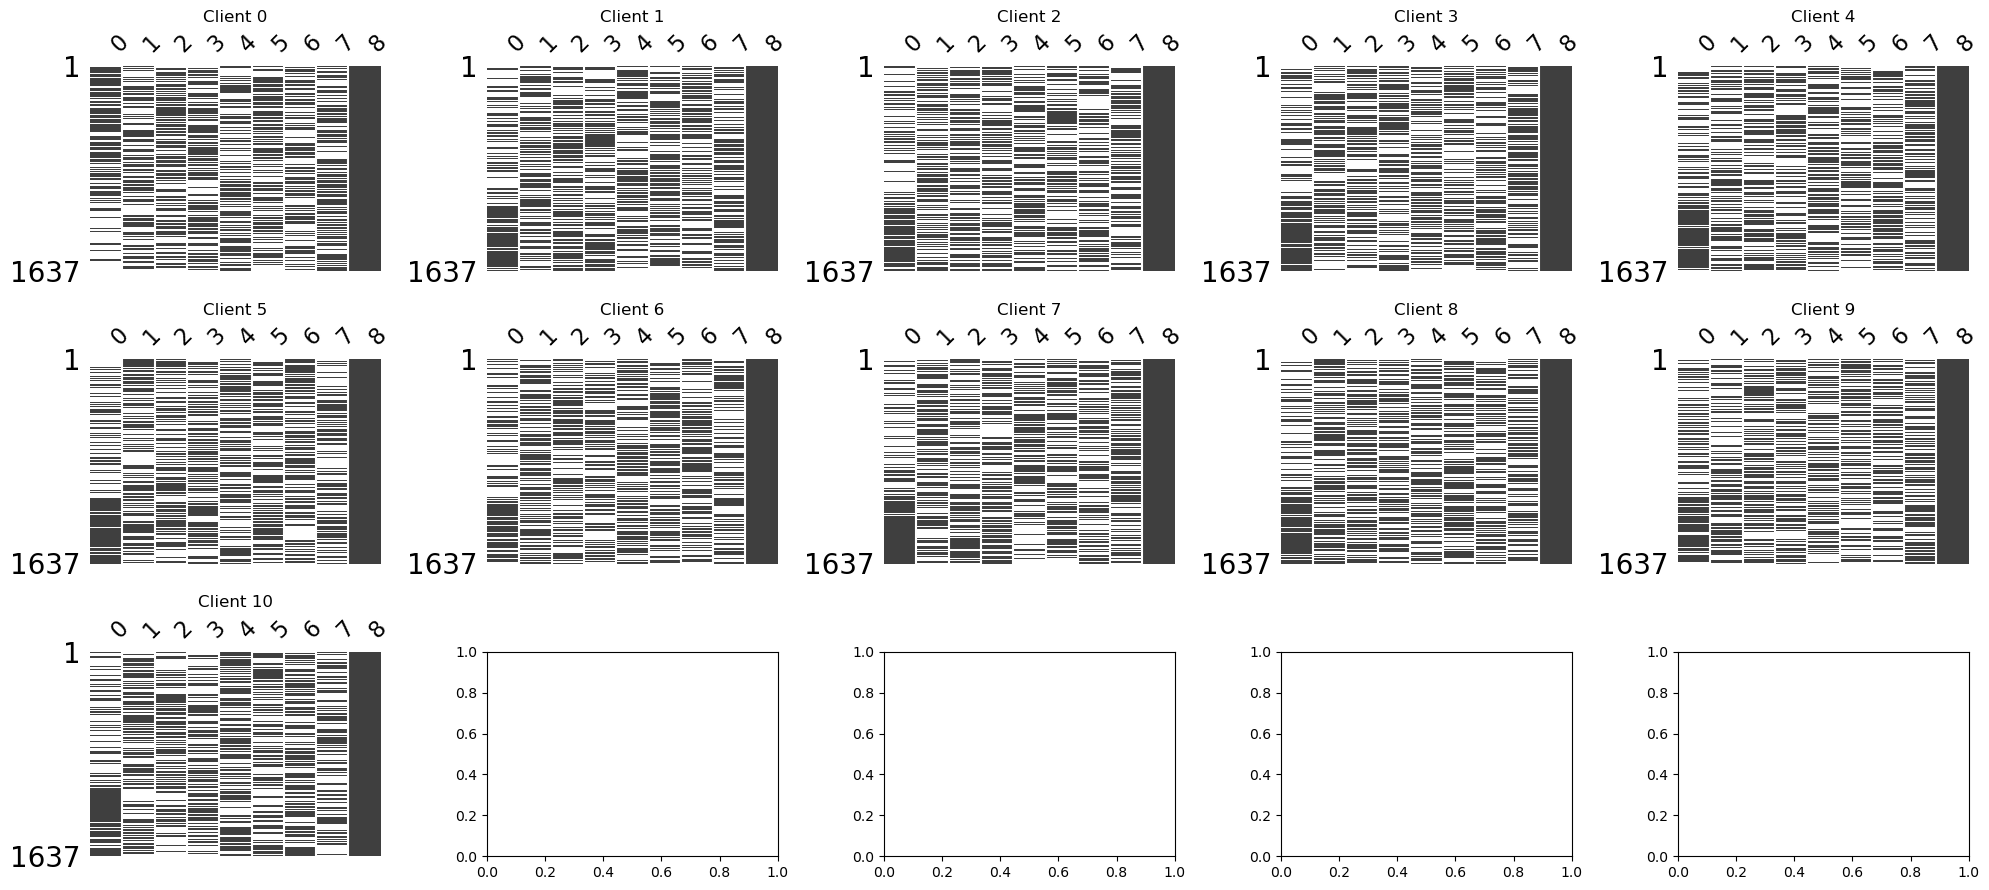

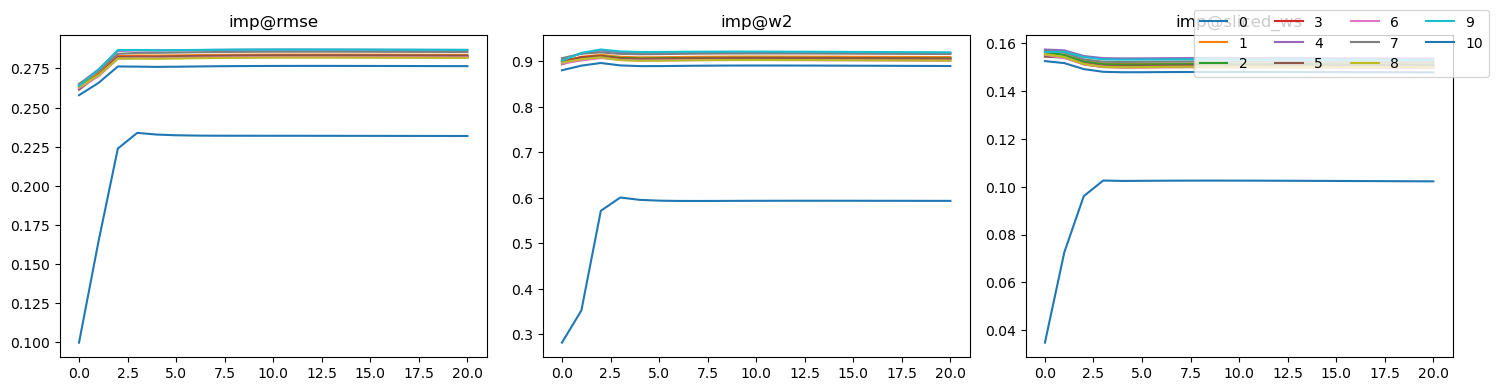

{'imp@rmse': 0.2785519656761988, 'imp@ws': 0.879445240163924, 'imp@sliced_ws': 0.14641462584120704}


2023-08-01 23:04:06.041 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 0, test_accu: 0.6685, test_f1: 0.5357 test_auroc: 0.6691 train_loss: 0.6442 val_accu: 0.6677 val_f1: 0.4004
2023-08-01 23:04:36.870 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 100, test_accu: 0.7275, test_f1: 0.6876 test_auroc: 0.7211 train_loss: 0.5014 val_accu: 0.7722 val_f1: 0.6895
2023-08-01 23:05:11.326 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 200, test_accu: 0.7460, test_f1: 0.7099 test_auroc: 0.6843 train_loss: 0.4865 val_accu: 0.7788 val_f1: 0.7049
2023-08-01 23:05:43.448 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 300, test_accu: 0.7555, test_f1: 0.7206 test_auroc: 0.6862 train_loss: 0.4840 val_accu: 0.7849 val_f1: 0.7130
2023-08-01 23:06:15.908 | INFO     | src.fed_imp.sub_modules.server.pred_server_ce

0.7705 0.8719810114944085 0.7425047933884297


In [26]:
name = 'mnar_lr_codrna_fedavg-s'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'codrna'
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

pred_ret = NN_evaluation(
    rets[name], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

d:\E\miniconda\envs\fed_imp\lib\site-packages\dython\nominal.py:298: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9)
sample-evenly {}
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(2000, 9)


2023-08-01 23:07:12.427 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-01 23:07:12.429 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-01 23:08:12.930 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-01 23:08:12.931 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-01 23:09:19.322 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-01 23:09:19.323 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-01 23:09:26.246 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 138.40663330000825


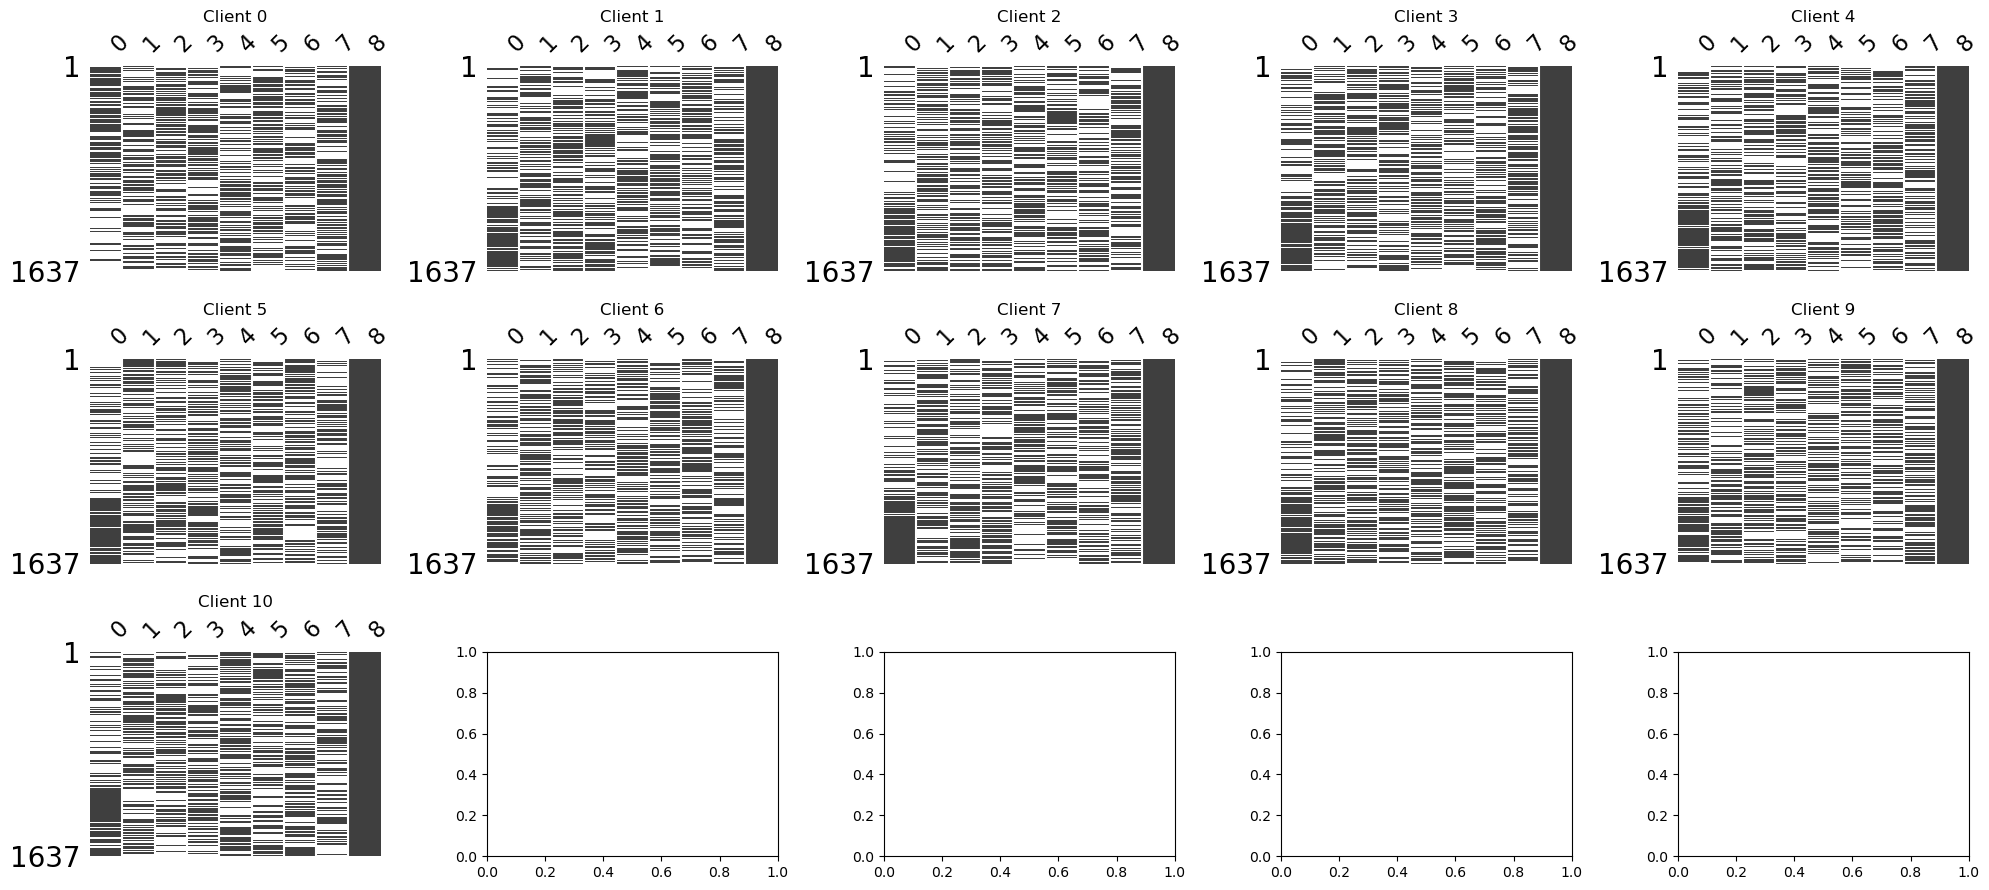

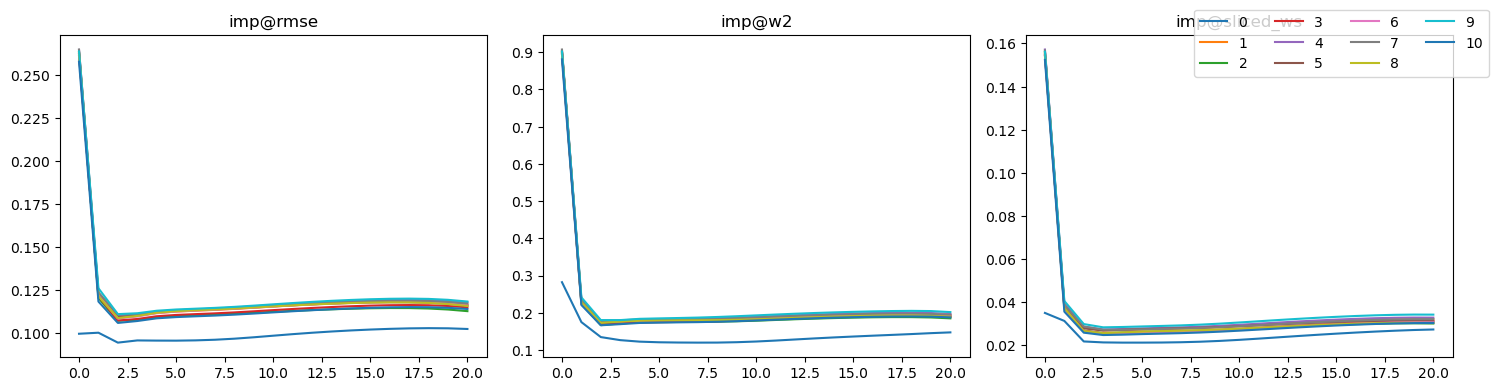

{'imp@rmse': 0.11586773569355435, 'imp@ws': 0.18970102076314835, 'imp@sliced_ws': 0.030813068405751064}


2023-08-01 23:09:29.141 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 0, test_accu: 0.6685, test_f1: 0.5357 test_auroc: 0.6693 train_loss: 0.6379 val_accu: 0.6677 val_f1: 0.4004
2023-08-01 23:10:02.702 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 100, test_accu: 0.9335, test_f1: 0.9343 test_auroc: 0.9804 train_loss: 0.3309 val_accu: 0.8523 val_f1: 0.8239
2023-08-01 23:10:35.249 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 200, test_accu: 0.9280, test_f1: 0.9291 test_auroc: 0.9826 train_loss: 0.3225 val_accu: 0.8495 val_f1: 0.8244
2023-08-01 23:11:07.309 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 300, test_accu: 0.9340, test_f1: 0.9344 test_auroc: 0.9827 train_loss: 0.3197 val_accu: 0.8611 val_f1: 0.8305
2023-08-01 23:11:39.226 | INFO     | src.fed_imp.sub_modules.server.pred_server_ce

0.9415 0.9855837623007317 0.941785346252336


In [27]:
name = 'mnar_lr_codrna_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'codrna'
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

pred_ret = NN_evaluation(
    rets[name], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

### Clients MNAR LR - Balanced

d:\E\miniconda\envs\fed_imp\lib\site-packages\dython\nominal.py:298: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9)
sample-evenly {}
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(2000, 9)


2023-08-01 23:25:29.752 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-01 23:25:29.752 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-01 23:26:20.180 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-01 23:26:20.181 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-01 23:27:18.878 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-01 23:27:18.879 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-01 23:27:24.894 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 119.29137569997692


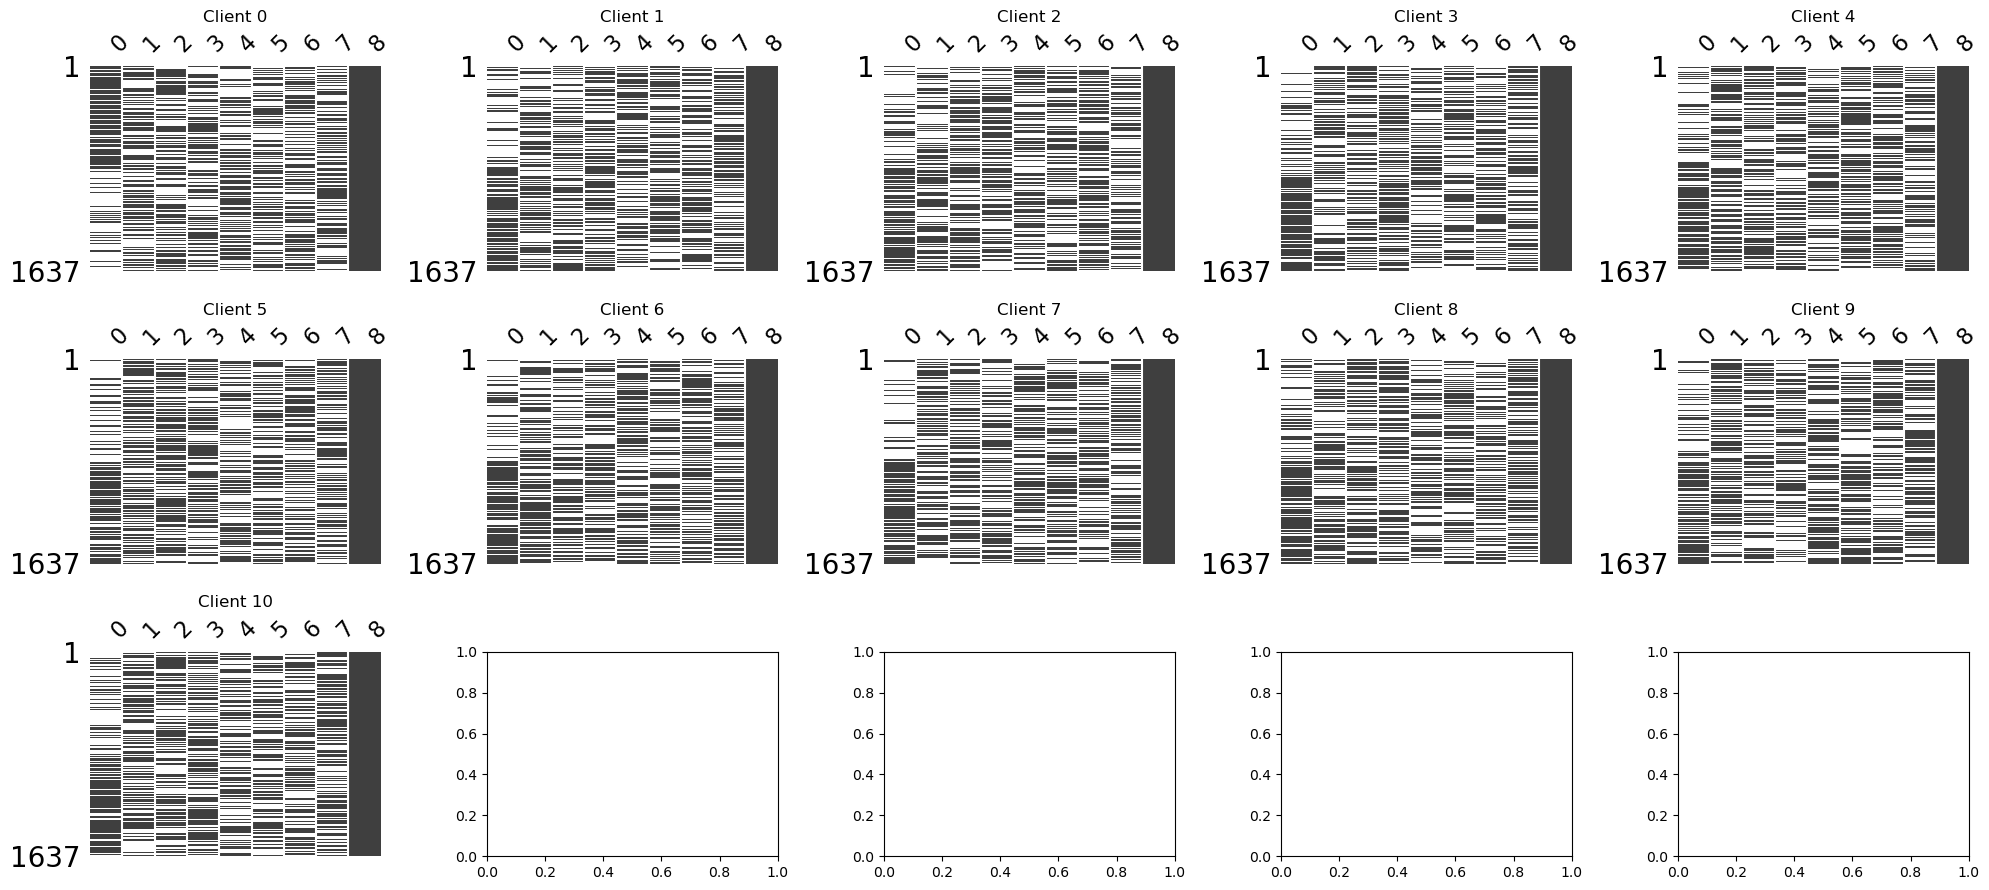

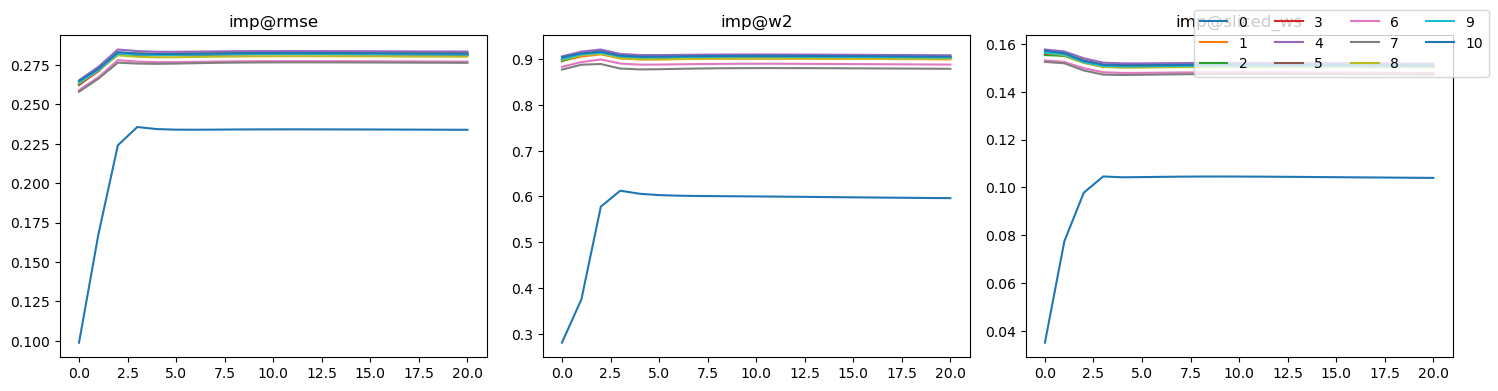

{'imp@rmse': 0.2766938221574742, 'imp@ws': 0.872385524845495, 'imp@sliced_ws': 0.14592132468481242}


2023-08-01 23:27:27.321 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 0, test_accu: 0.5465, test_f1: 0.5037 test_auroc: 0.6430 train_loss: 0.6897 val_accu: 0.5324 val_f1: 0.4149
2023-08-01 23:27:56.906 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 100, test_accu: 0.6270, test_f1: 0.5789 test_auroc: 0.8330 train_loss: 0.5799 val_accu: 0.6752 val_f1: 0.6587
2023-08-01 23:28:29.688 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 200, test_accu: 0.6290, test_f1: 0.5852 test_auroc: 0.7638 train_loss: 0.5571 val_accu: 0.6982 val_f1: 0.6837
2023-08-01 23:29:00.104 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 300, test_accu: 0.6425, test_f1: 0.6015 test_auroc: 0.6138 train_loss: 0.5476 val_accu: 0.7012 val_f1: 0.6970
2023-08-01 23:29:31.892 | INFO     | src.fed_imp.sub_modules.server.pred_server_ce

0.692 0.8566594266377066 0.6719781096563012


In [30]:
name = 'mnar_lr_codrna_fedavg-s'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'codrna_balanced'
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

pred_ret = NN_evaluation(
    rets[name], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

d:\E\miniconda\envs\fed_imp\lib\site-packages\dython\nominal.py:298: RuntimeWarning: Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.
  warnings.warn(


(18000, 9)
sample-evenly {}
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(2000, 9)


2023-08-01 23:30:25.794 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-01 23:30:25.795 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-01 23:31:23.002 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-01 23:31:23.003 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10


KeyboardInterrupt: 

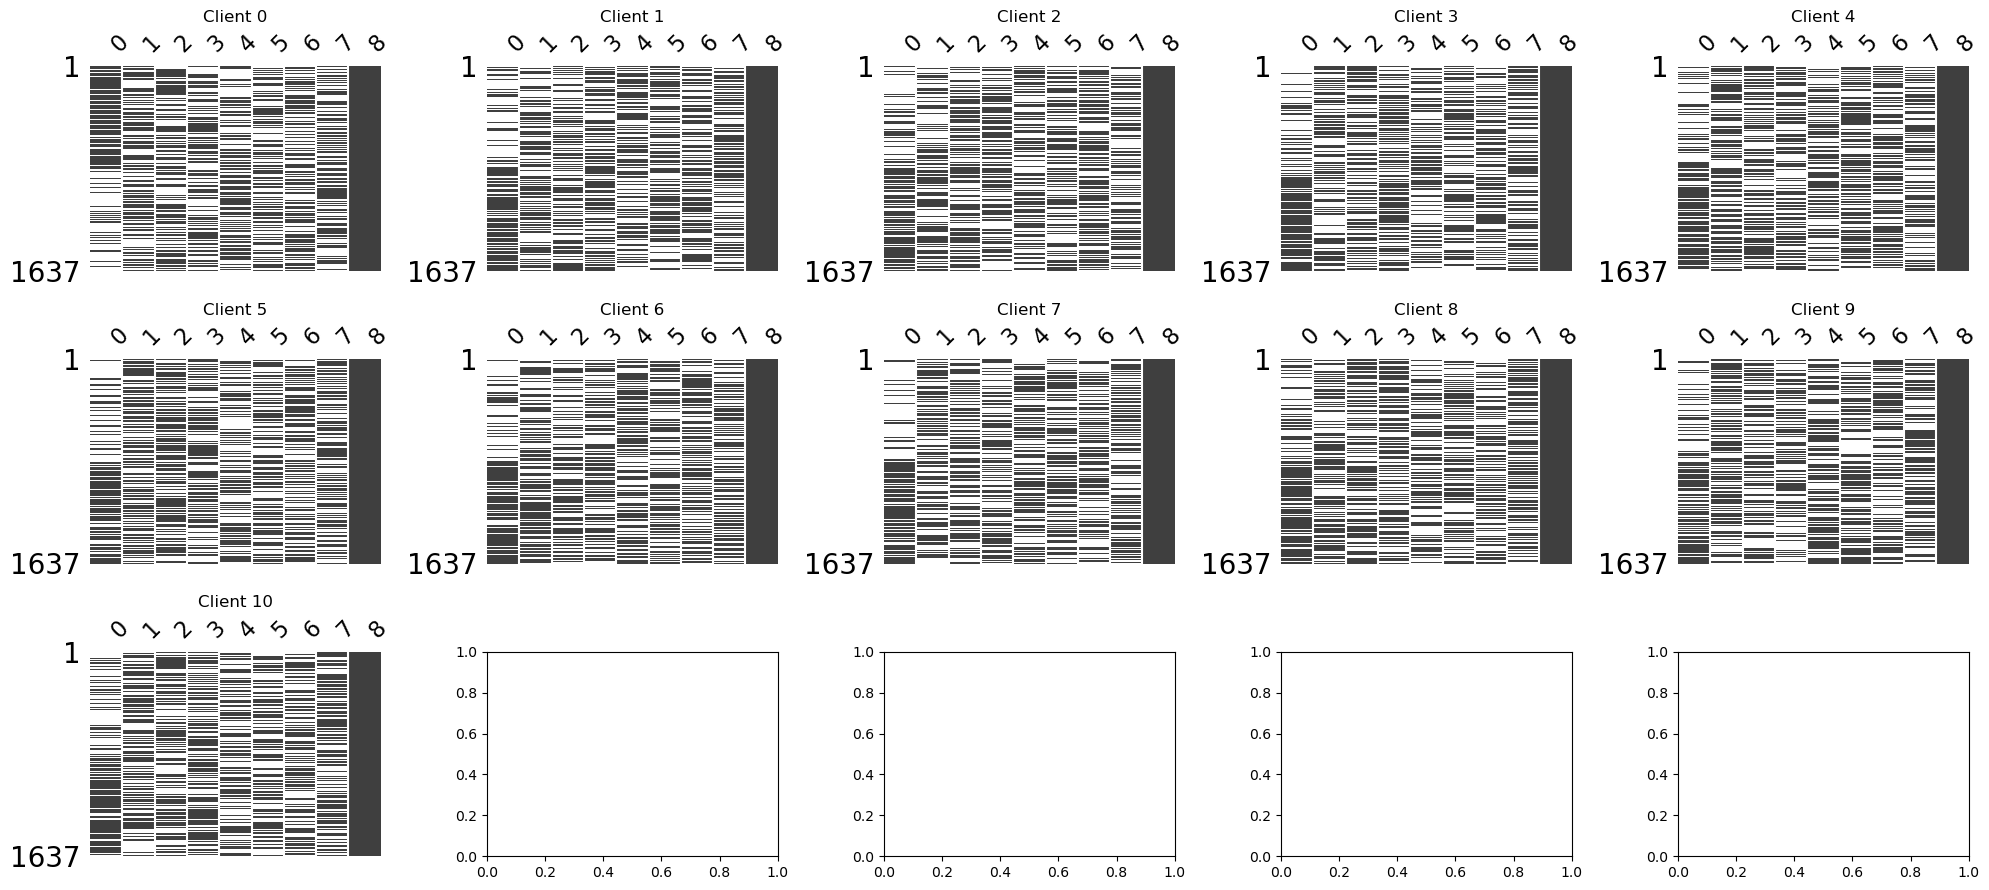

In [31]:
name = 'mnar_lr_codrna_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'codrna_balanced'
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

pred_ret = NN_evaluation(
    rets[name], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

# Skin

In [5]:
trackers = {}
rets ={}
mr_strategy = 'fixed@mr=0.5'

### Clients MNAR LR Raw

(18000, 4) (2000, 4)
(18000, 4)
sample-evenly {}
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(2000, 4)


2023-08-03 17:04:21.690 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-03 17:04:21.691 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-03 17:05:17.599 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-03 17:05:17.599 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-03 17:06:11.929 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-03 17:06:11.930 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-03 17:06:17.387 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 120.34287039999617


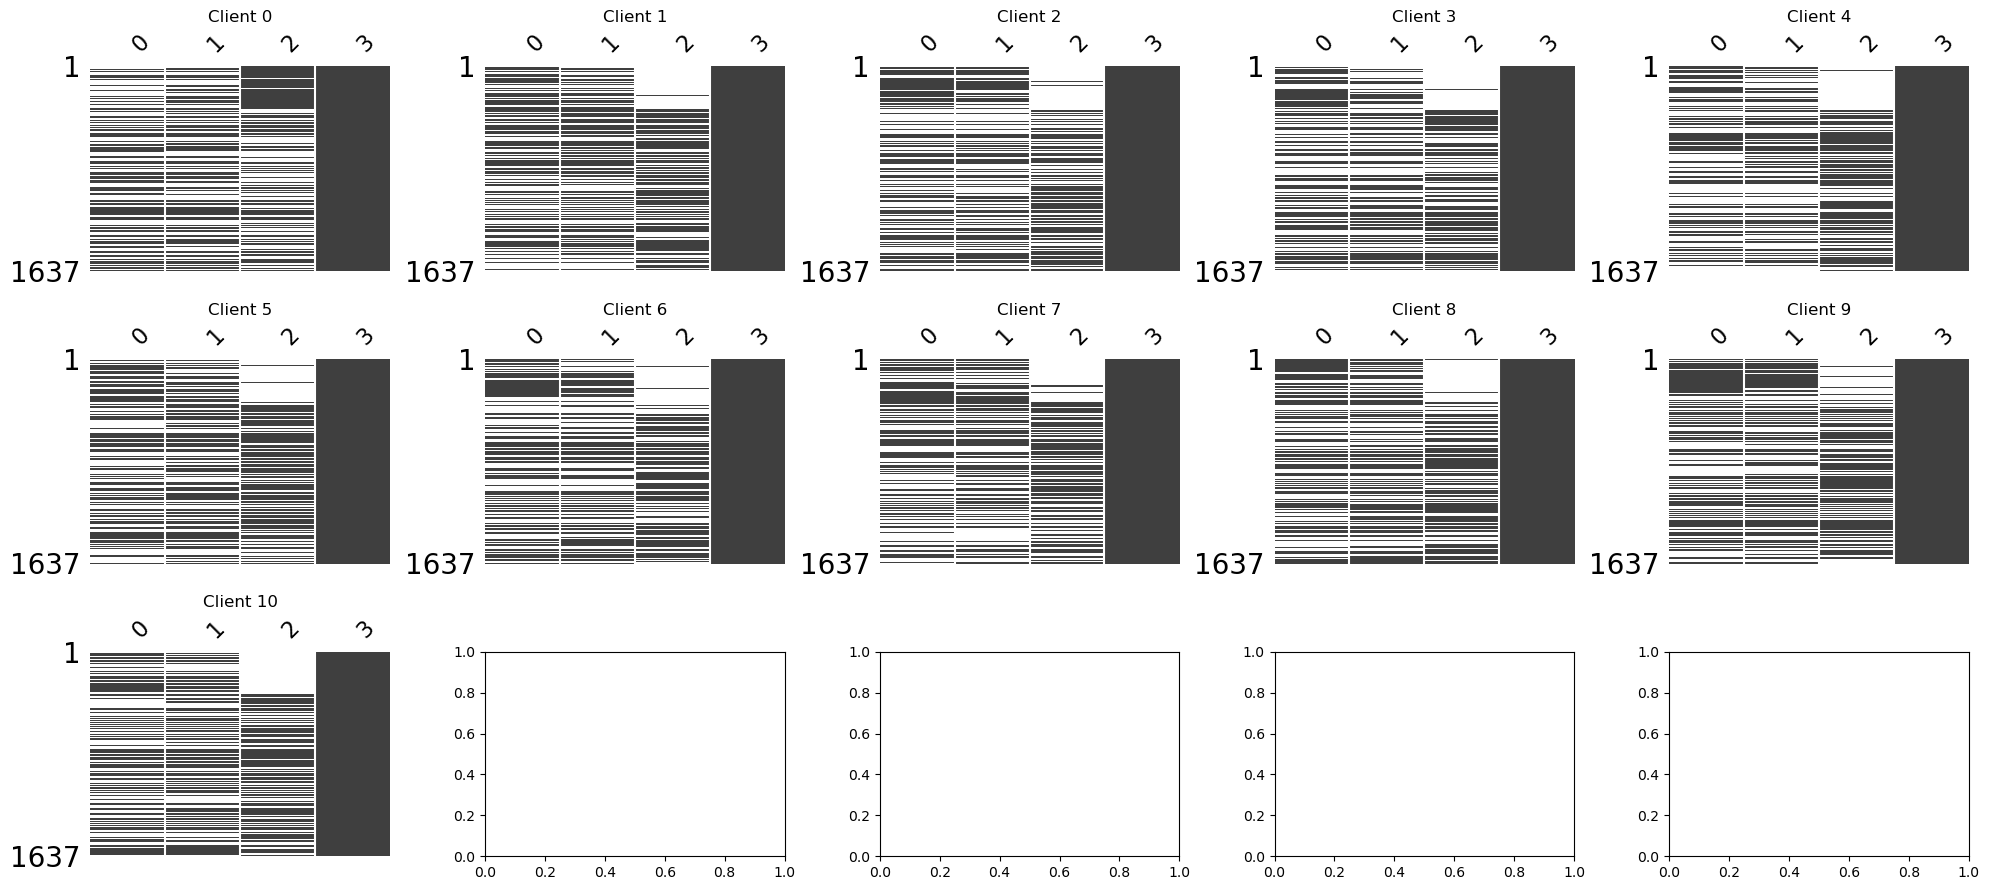

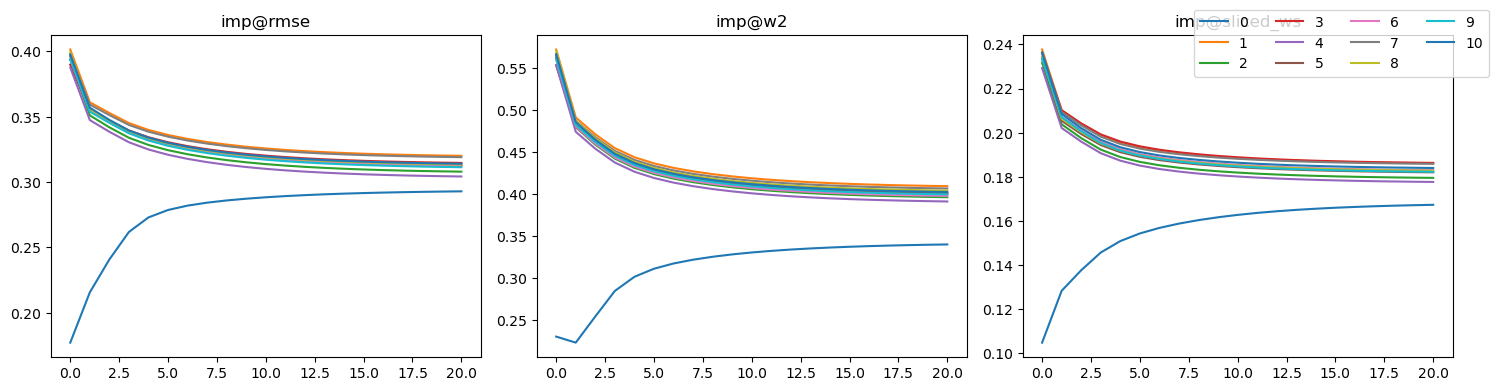

{'imp@rmse': 0.3116160778896943, 'imp@ws': 0.3964372820923634, 'imp@sliced_ws': 0.1816194790056735}


In [35]:
name = 'mnar_lr_skin_fedavg-s'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'skin'
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [40]:
name = 'mnar_lr_skin_fedavg-s'
pred_ret = NN_evaluation(
    rets[name], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)


2023-08-03 17:27:38.467 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:179 - Round: 0, test_accu: 0.9385, test_f1: 0.9162 test_auroc: 0.9551 train_loss: 0.5272 val_accu: 0.6590 val_f1: 0.6505
2023-08-03 17:27:48.923 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:179 - Round: 20, test_accu: 0.9495, test_f1: 0.9301 test_auroc: 0.9617 train_loss: 0.3001 val_accu: 0.8215 val_f1: 0.8187
2023-08-03 17:27:59.660 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:179 - Round: 40, test_accu: 0.9550, test_f1: 0.9372 test_auroc: 0.9599 train_loss: 0.3362 val_accu: 0.8057 val_f1: 0.7996
2023-08-03 17:28:09.331 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:179 - Round: 60, test_accu: 0.9655, test_f1: 0.9511 test_auroc: 0.9660 train_loss: 0.2824 val_accu: 0.8177 val_f1: 0.8121
2023-08-03 17:28:19.777 | INFO     | src.fed_imp.sub_modules.server.pred_server_centr

0.975 0.9811489331720311 0.9636373685672687


(18000, 4) (2000, 4)
(18000, 4)
sample-evenly {}
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(2000, 4)


2023-08-03 17:11:09.740 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-03 17:11:09.741 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-03 17:11:55.667 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-03 17:11:55.667 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-03 17:12:46.582 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-03 17:12:46.583 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-03 17:12:51.861 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 106.55827270000009


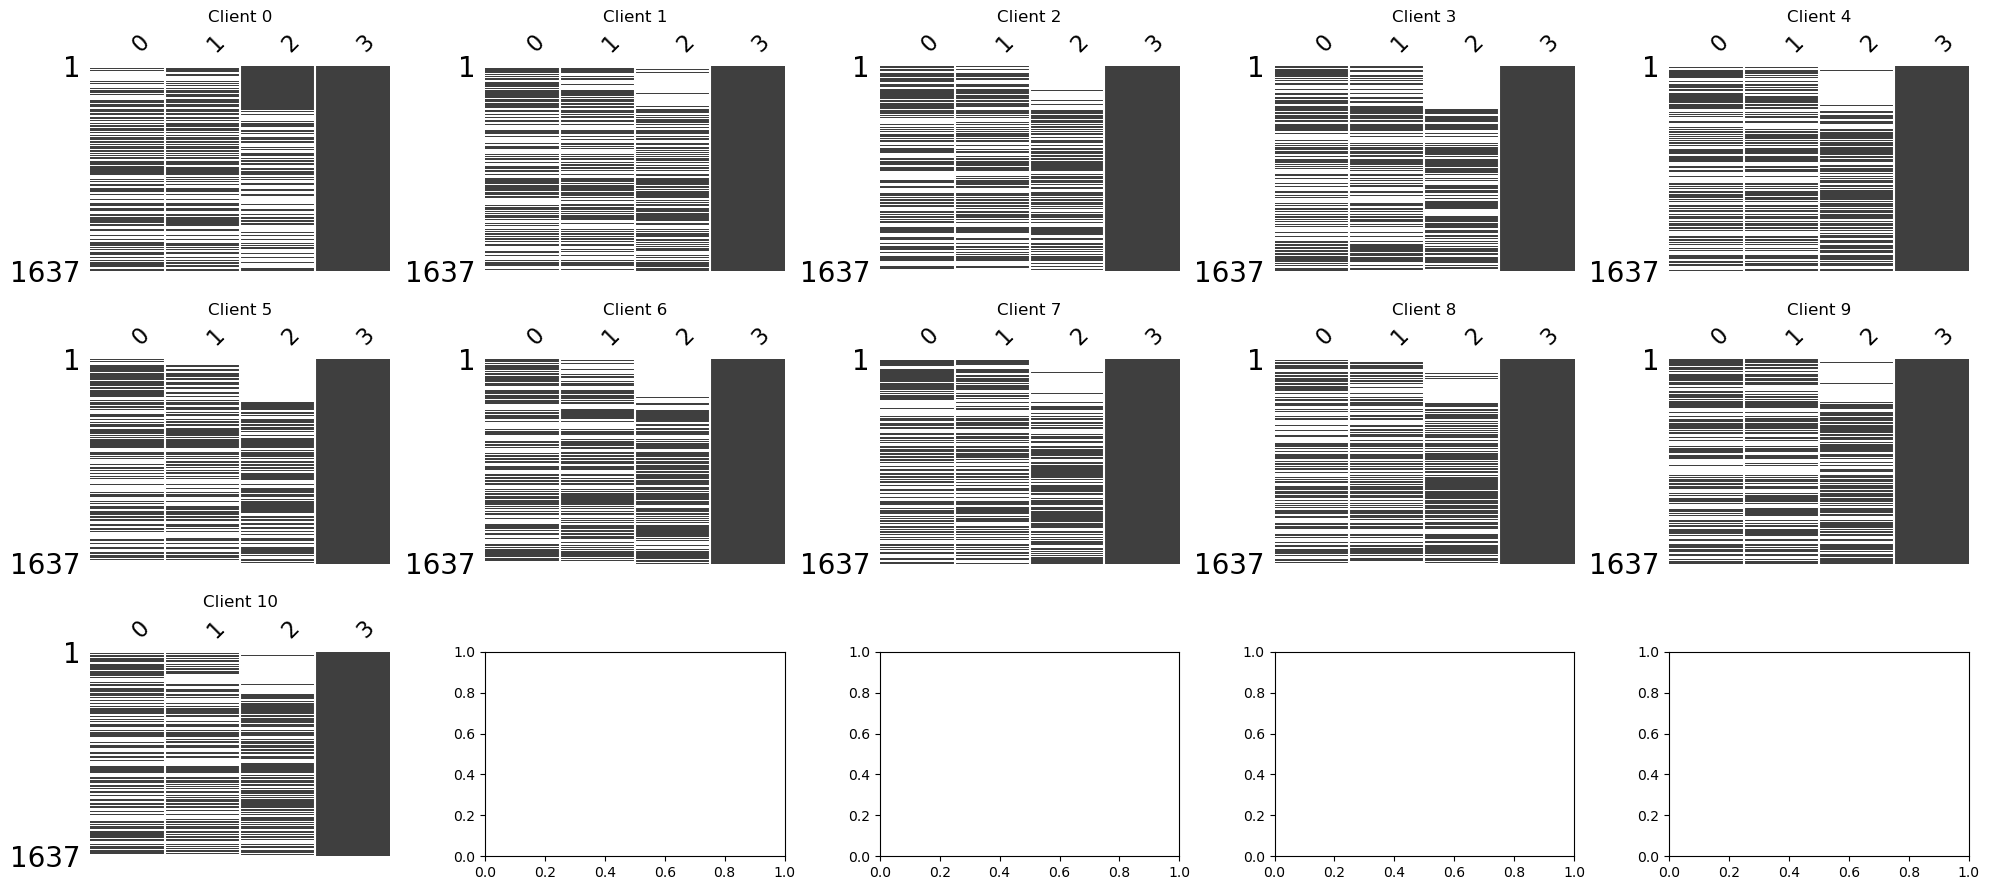

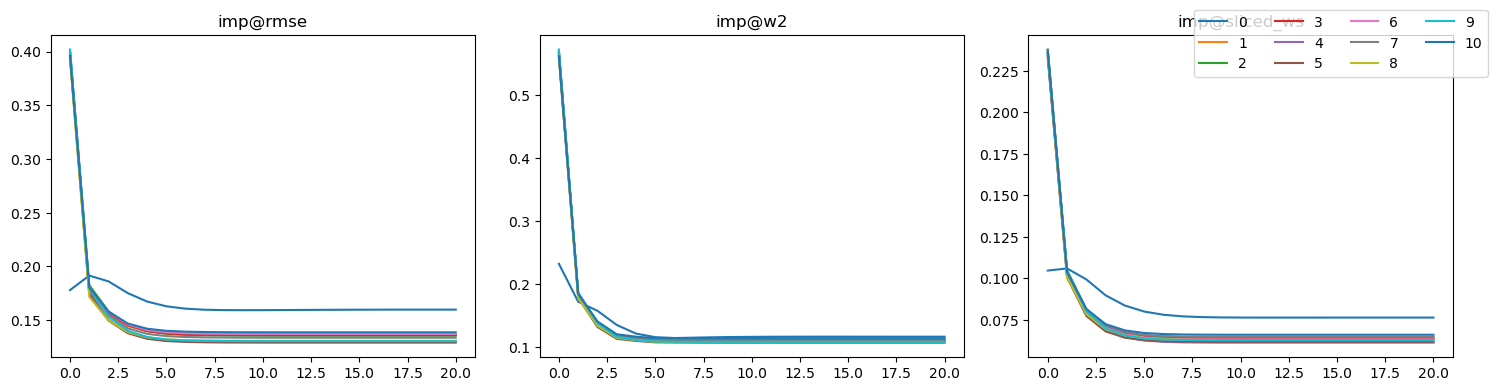

{'imp@rmse': 0.13604810628765834, 'imp@ws': 0.10977185705323872, 'imp@sliced_ws': 0.06426891285482048}


In [37]:
name = 'mnar_lr_skin_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'skin'
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [41]:
name = 'mnar_lr_skin_fedmechw'
pred_ret = NN_evaluation(
    rets[name], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)


2023-08-03 17:32:43.128 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:179 - Round: 0, test_accu: 0.9410, test_f1: 0.9188 test_auroc: 0.9864 train_loss: 0.3259 val_accu: 0.8431 val_f1: 0.8393
2023-08-03 17:32:53.371 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:179 - Round: 20, test_accu: 0.9285, test_f1: 0.9034 test_auroc: 0.9902 train_loss: 0.2545 val_accu: 0.8466 val_f1: 0.8431
2023-08-03 17:33:03.811 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:179 - Round: 40, test_accu: 0.9885, test_f1: 0.9830 test_auroc: 0.9968 train_loss: 0.2483 val_accu: 0.8521 val_f1: 0.8489
2023-08-03 17:33:13.560 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:179 - Round: 60, test_accu: 0.9730, test_f1: 0.9605 test_auroc: 0.9947 train_loss: 0.2478 val_accu: 0.8508 val_f1: 0.8479
2023-08-03 17:33:24.175 | INFO     | src.fed_imp.sub_modules.server.pred_server_centr

0.995 0.9983694996986135 0.9925045459928553


### Clients MNAR LR Balanced

(18000, 4) (2000, 4)
(18000, 4)
sample-evenly {}
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(2000, 4)


2023-08-02 07:42:43.074 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-02 07:42:43.075 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-02 07:43:28.572 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-02 07:43:28.573 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-02 07:44:18.681 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-02 07:44:18.683 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-02 07:44:23.891 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 105.3024771999917


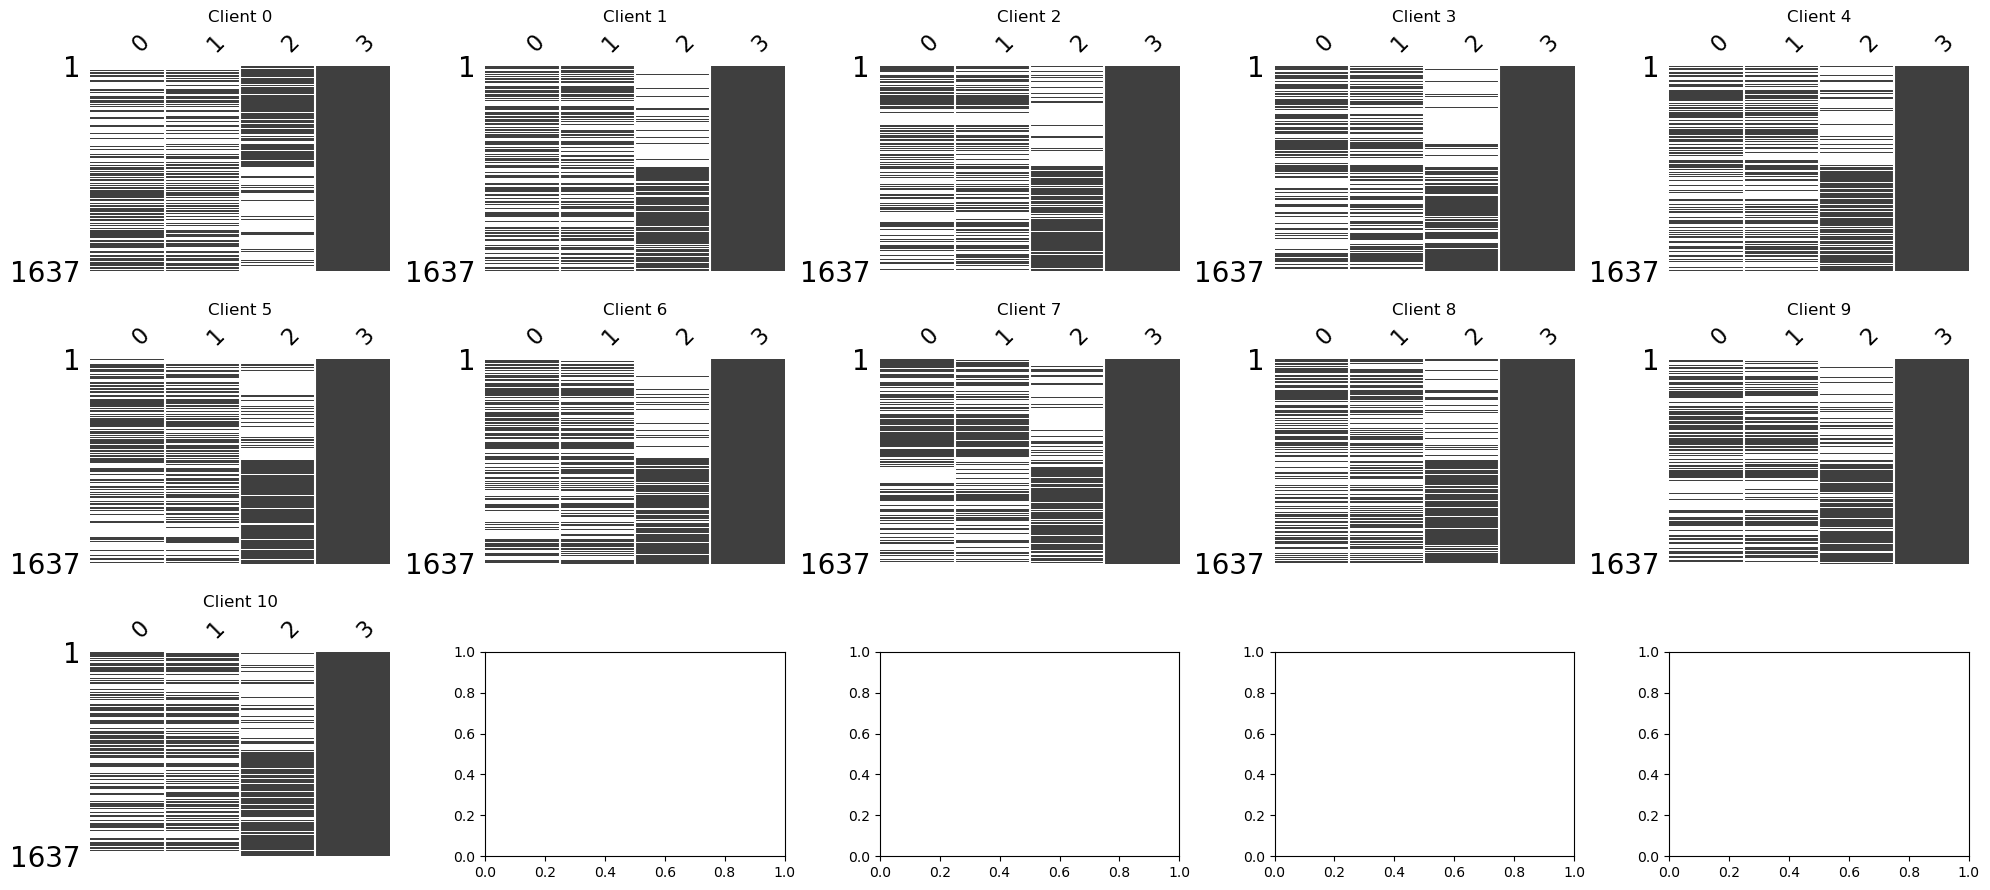

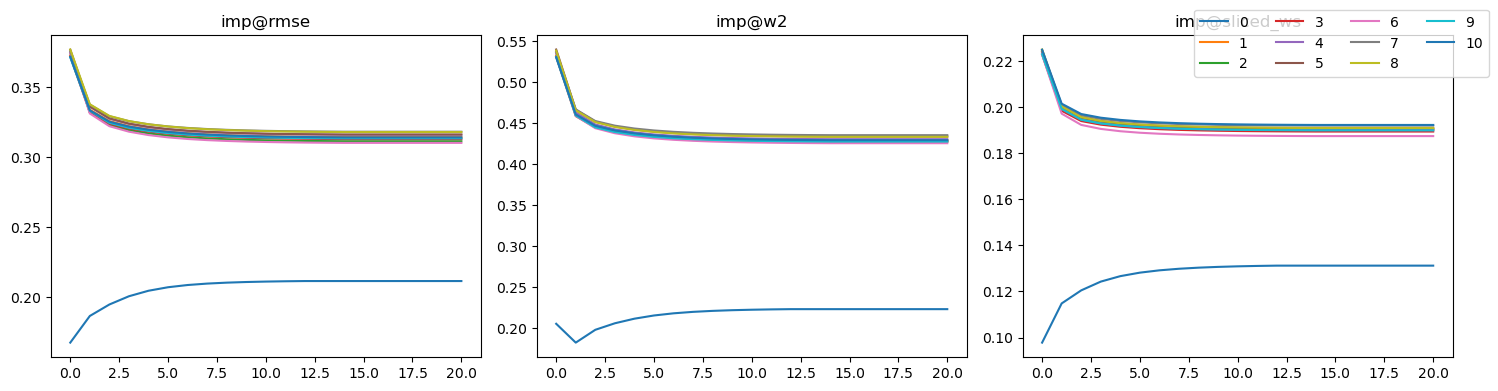

{'imp@rmse': 0.3049032655457182, 'imp@ws': 0.4110403674989737, 'imp@sliced_ws': 0.1850156303977069}


2023-08-02 07:44:25.965 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 0, test_accu: 0.9340, test_f1: 0.9338 test_auroc: 0.9634 train_loss: 0.6139 val_accu: 0.7120 val_f1: 0.6927
2023-08-02 07:44:58.212 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 100, test_accu: 0.9425, test_f1: 0.9425 test_auroc: 0.9665 train_loss: 0.3648 val_accu: 0.8562 val_f1: 0.8545
2023-08-02 07:45:30.525 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 200, test_accu: 0.9290, test_f1: 0.9290 test_auroc: 0.9738 train_loss: 0.3226 val_accu: 0.7744 val_f1: 0.7652
2023-08-02 07:46:02.767 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 300, test_accu: 0.9270, test_f1: 0.9270 test_auroc: 0.9821 train_loss: 0.3067 val_accu: 0.8603 val_f1: 0.8585
2023-08-02 07:46:35.547 | INFO     | src.fed_imp.sub_modules.server.pred_server_ce

0.9665 0.9874281713385512 0.9664809410381929


In [9]:
name = 'mnar_lr_skin_fedavg-s'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'skin_balanced'
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

pred_ret = NN_evaluation(
    rets[name], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

(18000, 4) (2000, 4)
(18000, 4)
sample-evenly {}
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(2000, 4)


2023-08-02 07:47:12.545 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-02 07:47:12.546 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-02 07:47:59.129 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-02 07:47:59.130 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-02 07:48:51.571 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-02 07:48:51.572 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-02 07:48:56.780 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 108.65288740000688


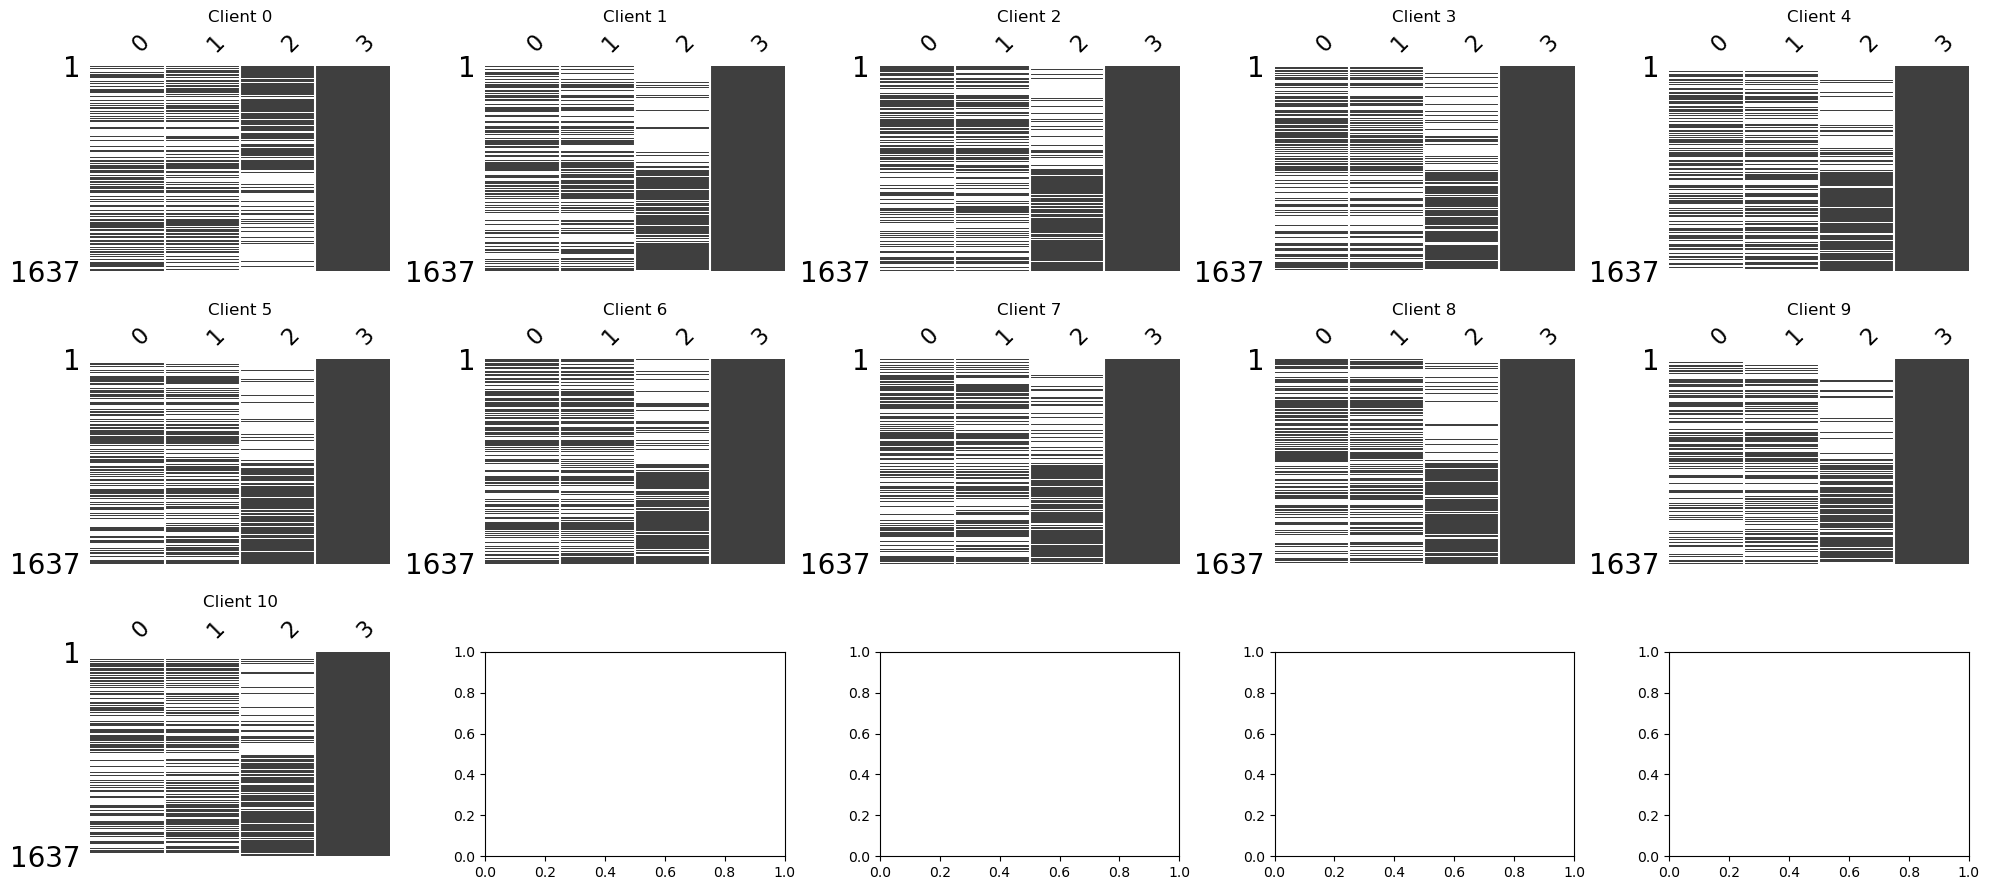

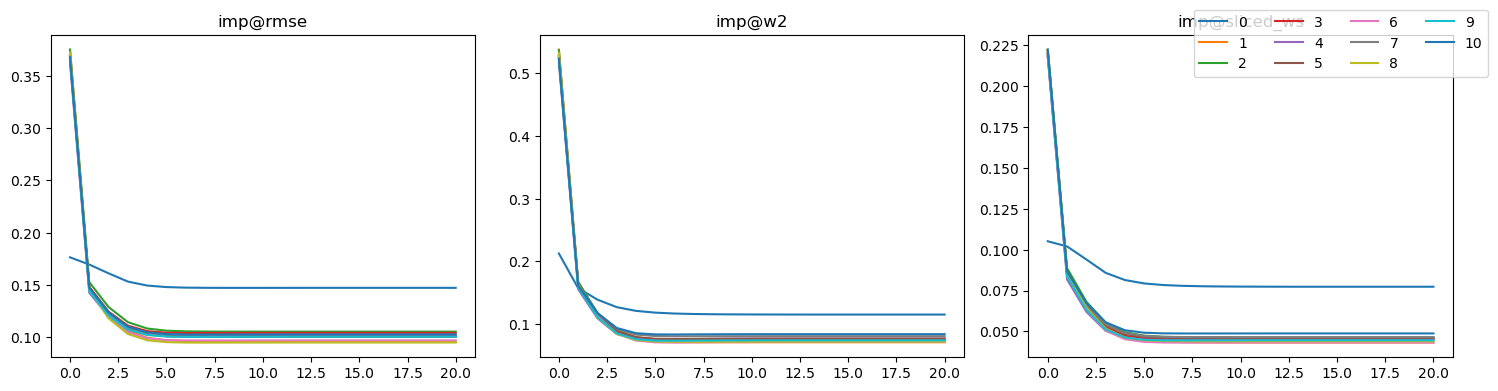

{'imp@rmse': 0.10445517429024381, 'imp@ws': 0.07927942215971757, 'imp@sliced_ws': 0.048169093063679246}


2023-08-02 07:48:58.833 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 0, test_accu: 0.9590, test_f1: 0.9589 test_auroc: 0.9521 train_loss: 0.4749 val_accu: 0.9113 val_f1: 0.9107
2023-08-02 07:49:30.032 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 100, test_accu: 0.9830, test_f1: 0.9830 test_auroc: 0.9940 train_loss: 0.1954 val_accu: 0.9282 val_f1: 0.9279
2023-08-02 07:50:00.744 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 200, test_accu: 0.9860, test_f1: 0.9860 test_auroc: 0.9979 train_loss: 0.1923 val_accu: 0.9310 val_f1: 0.9307
2023-08-02 07:50:38.448 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 300, test_accu: 0.9860, test_f1: 0.9860 test_auroc: 0.9975 train_loss: 0.1905 val_accu: 0.9304 val_f1: 0.9302
2023-08-02 07:51:13.261 | INFO     | src.fed_imp.sub_modules.server.pred_server_ce

0.9915 0.9987058434070523 0.9914985905890714


In [10]:
name = 'mnar_lr_skin_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'skin_balanced'
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

pred_ret = NN_evaluation(
    rets[name], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

# Codon

In [12]:
trackers = {}
rets ={}
mr_strategy = 'fixed@mr=0.5'

### MNAR Clients LR

(13008, 26)
(11707, 26) (1301, 26)
(11707, 26)
sample-evenly {}
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(1301, 26)


2023-08-02 08:30:46.644 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-02 08:30:46.646 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-02 08:31:55.637 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-02 08:31:55.638 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-02 08:33:09.489 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-02 08:33:09.489 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-02 08:33:16.462 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 152.67422590003116


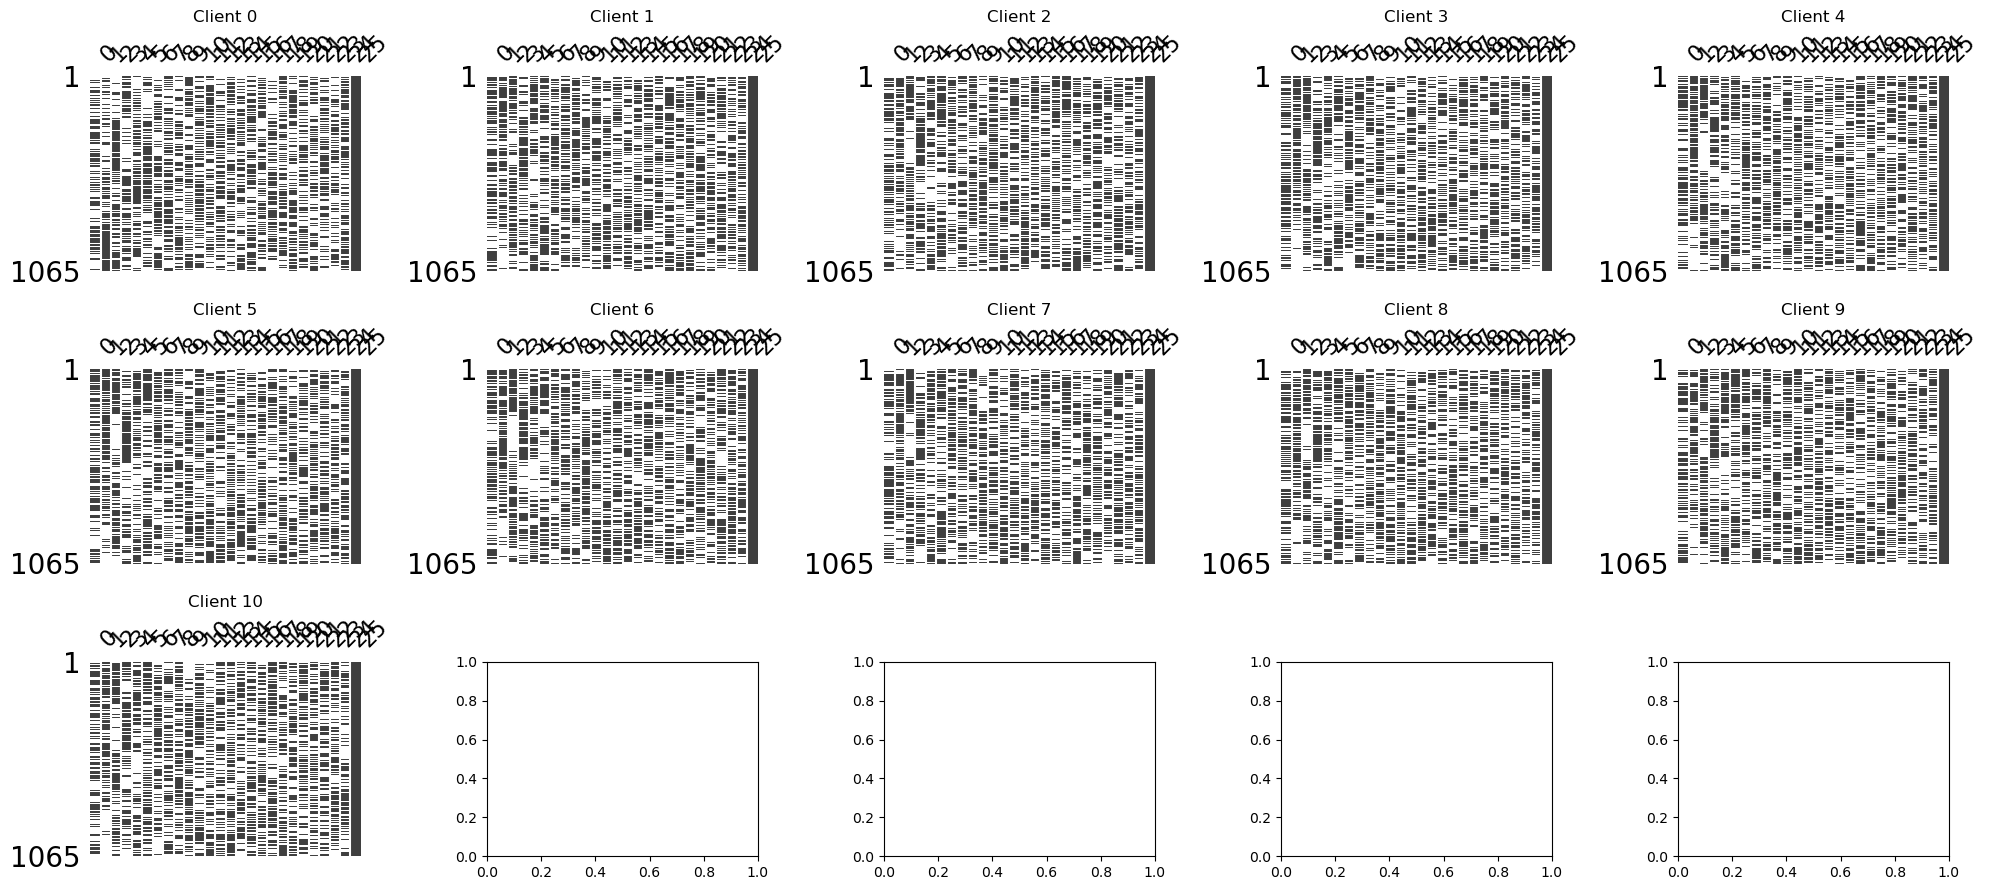

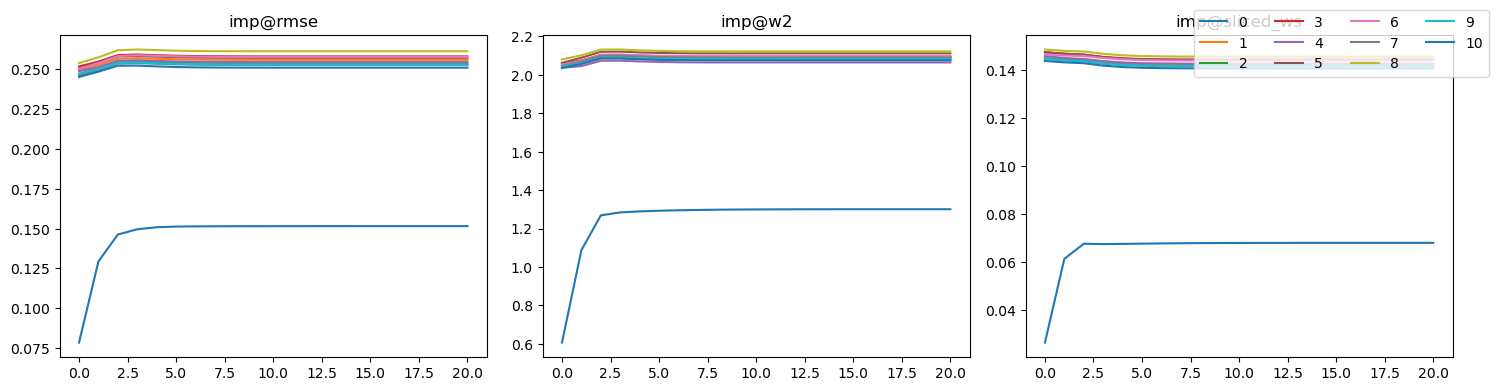

{'imp@rmse': 0.24613234782972357, 'imp@ws': 2.01805463508386, 'imp@sliced_ws': 0.13616762138704153}


2023-08-02 08:33:20.021 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 0, test_accu: 0.2183, test_f1: 0.0806 test_auroc: 0.7852 train_loss: 2.0358 val_accu: 0.2207 val_f1: 0.0404
2023-08-02 08:33:46.392 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 100, test_accu: 0.6826, test_f1: 0.6465 test_auroc: 0.9507 train_loss: 1.2545 val_accu: 0.5625 val_f1: 0.3224
2023-08-02 08:34:12.541 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 200, test_accu: 0.6879, test_f1: 0.6621 test_auroc: 0.9545 train_loss: 1.1059 val_accu: 0.5971 val_f1: 0.3668
2023-08-02 08:34:37.638 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 300, test_accu: 0.6749, test_f1: 0.6480 test_auroc: 0.9501 train_loss: 1.0417 val_accu: 0.6214 val_f1: 0.3882
2023-08-02 08:35:03.689 | INFO     | src.fed_imp.sub_modules.server.pred_server_ce

0.7002305918524212 0.9573200588259659 0.6705442531540108


In [15]:
name = 'mnar_lr_codon_fedavg-s'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'codon'
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

pred_ret = NN_evaluation(
    rets[name], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

(13008, 26)
(11707, 26) (1301, 26)
(11707, 26)
sample-evenly {}
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(1301, 26)


2023-08-02 08:41:54.816 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-02 08:41:54.817 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-02 08:43:06.498 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-02 08:43:06.499 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-02 08:44:18.778 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-02 08:44:18.779 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-02 08:44:26.144 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 154.13708709995262


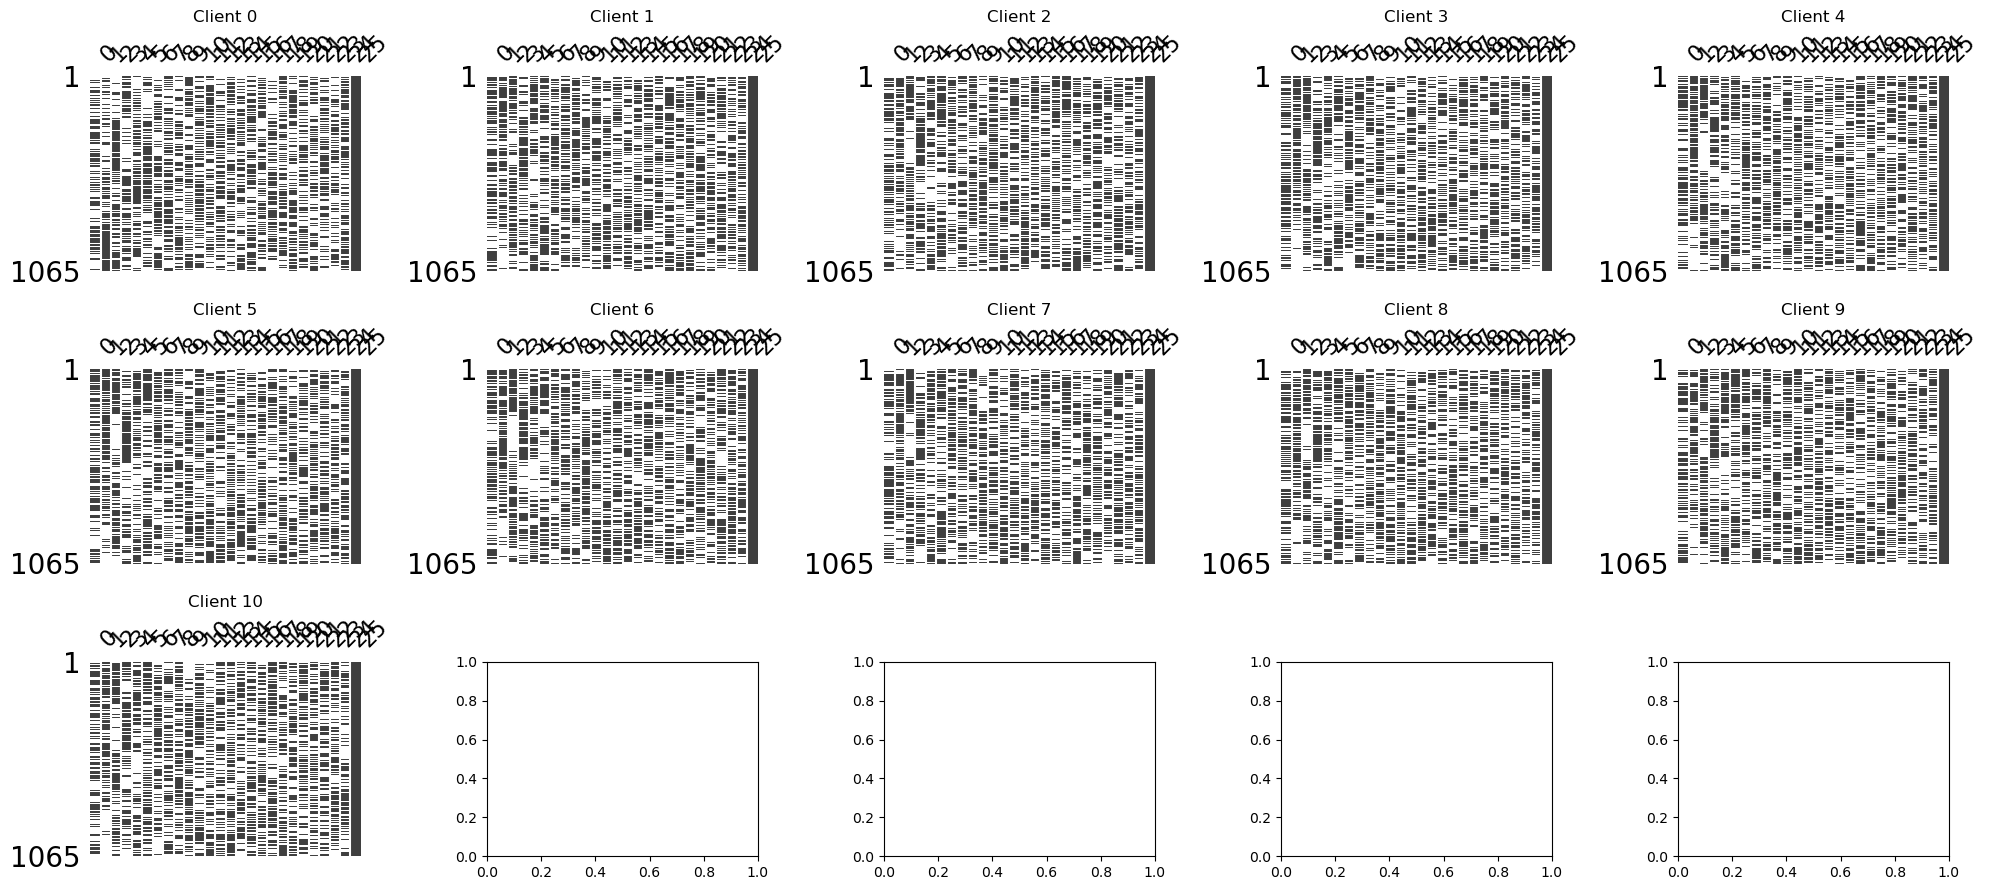

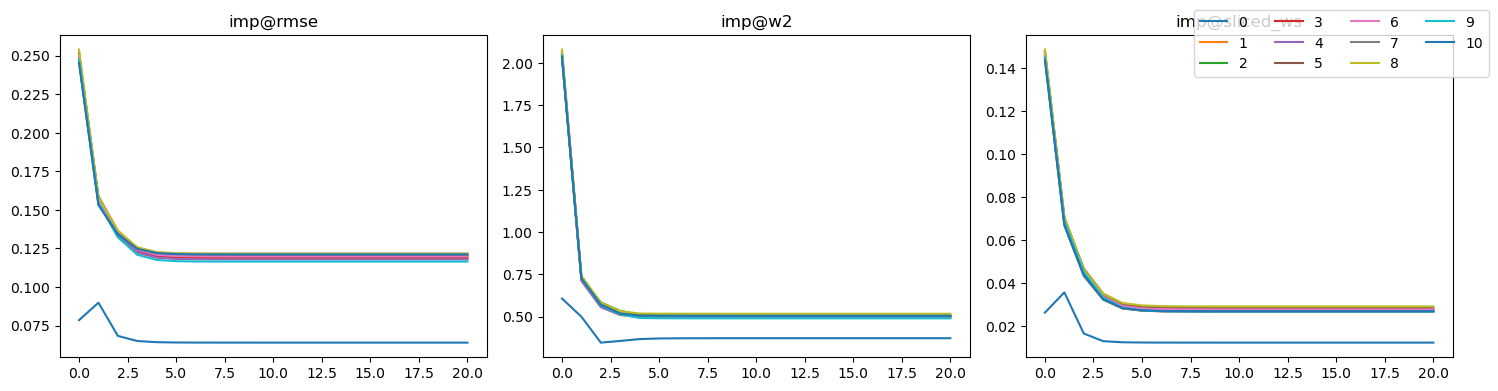

{'imp@rmse': 0.11453043431897561, 'imp@ws': 0.48896923900419104, 'imp@sliced_ws': 0.026248099440013356}


2023-08-02 08:44:29.890 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 0, test_accu: 0.3989, test_f1: 0.2708 test_auroc: 0.8347 train_loss: 2.0237 val_accu: 0.3824 val_f1: 0.1170
2023-08-02 08:44:55.494 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 100, test_accu: 0.8540, test_f1: 0.8440 test_auroc: 0.9889 train_loss: 0.4005 val_accu: 0.8451 val_f1: 0.6733
2023-08-02 08:45:21.018 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 200, test_accu: 0.8601, test_f1: 0.8507 test_auroc: 0.9899 train_loss: 0.3483 val_accu: 0.8592 val_f1: 0.7112
2023-08-02 08:45:47.358 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:169 - Round: 300, test_accu: 0.8640, test_f1: 0.8559 test_auroc: 0.9901 train_loss: 0.3257 val_accu: 0.8609 val_f1: 0.7059
2023-08-02 08:46:13.161 | INFO     | src.fed_imp.sub_modules.server.pred_server_ce

0.8731744811683321 0.9904368089900297 0.8678631432986038


In [16]:
name = 'mnar_lr_codon_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'codon'
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

pred_ret = NN_evaluation(
    rets[name], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

# Sepsis

In [19]:
trackers = {}
rets ={}
mr_strategy = 'fixed@mr=0.5'

(18000, 4) (2000, 4)
(18000, 4)
sample-evenly {}
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(2000, 4)


2023-08-03 16:33:53.472 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-03 16:33:53.473 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-03 16:34:42.577 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-03 16:34:42.578 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-03 16:35:31.371 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-03 16:35:31.372 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-03 16:35:36.502 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 107.35864060005406


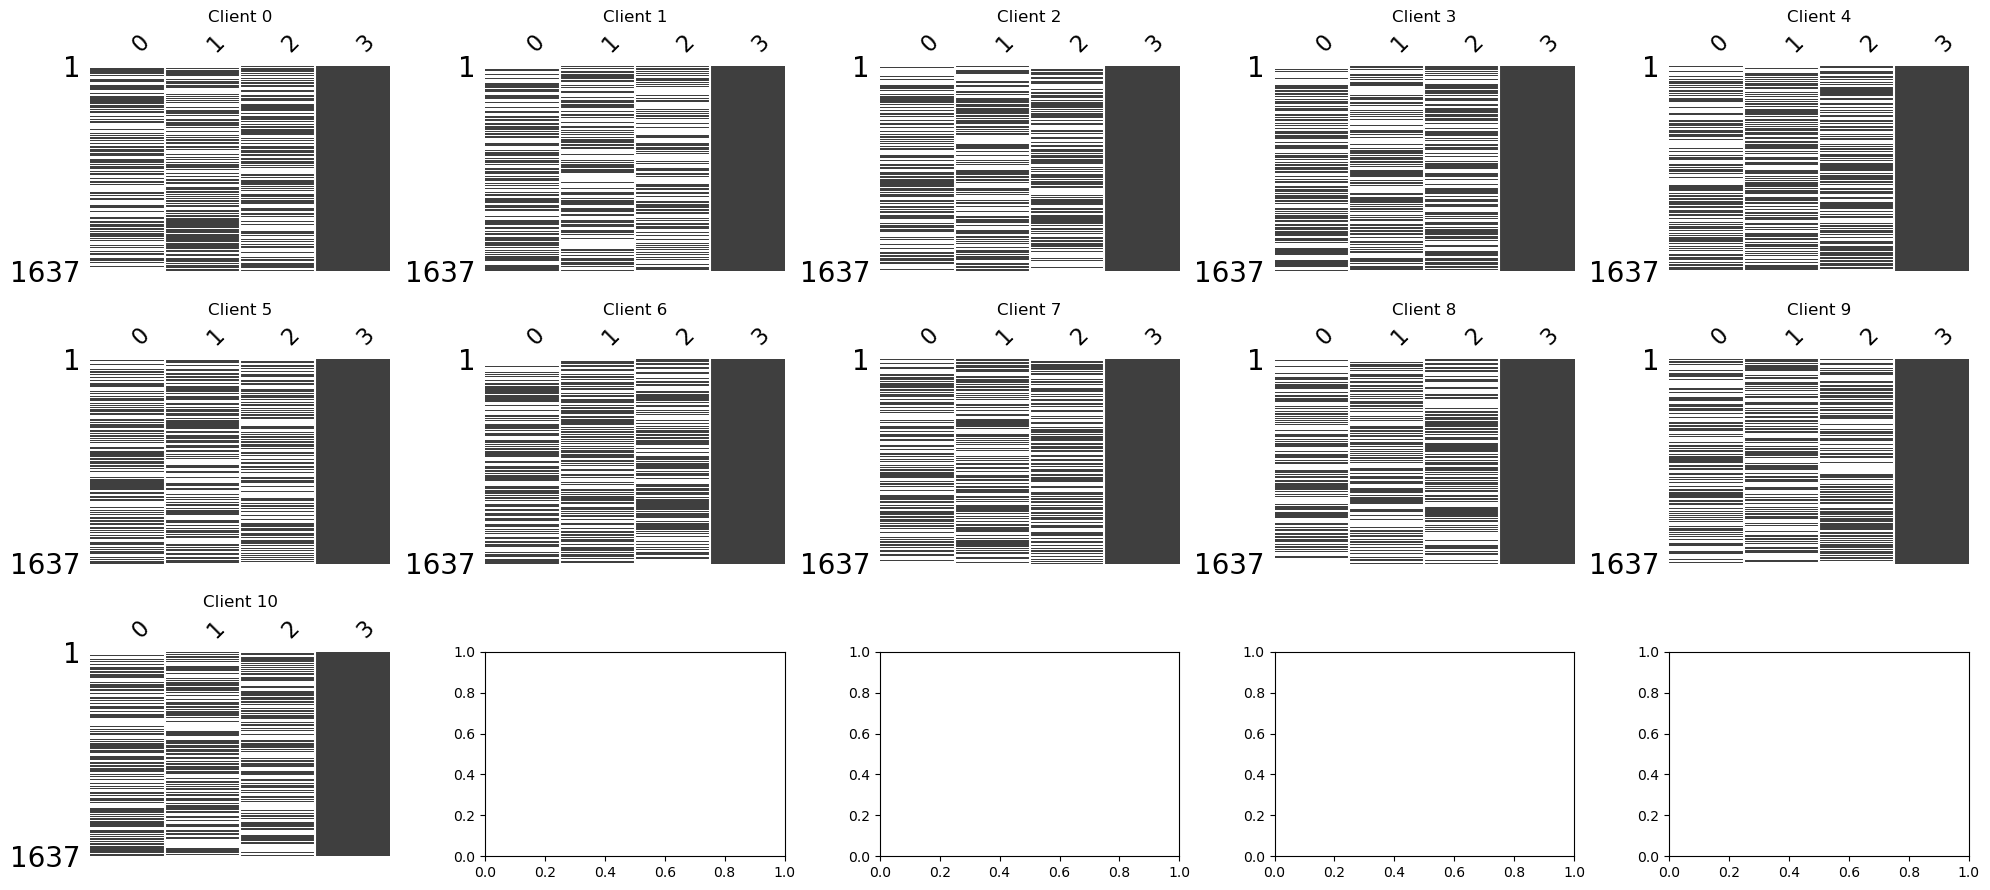

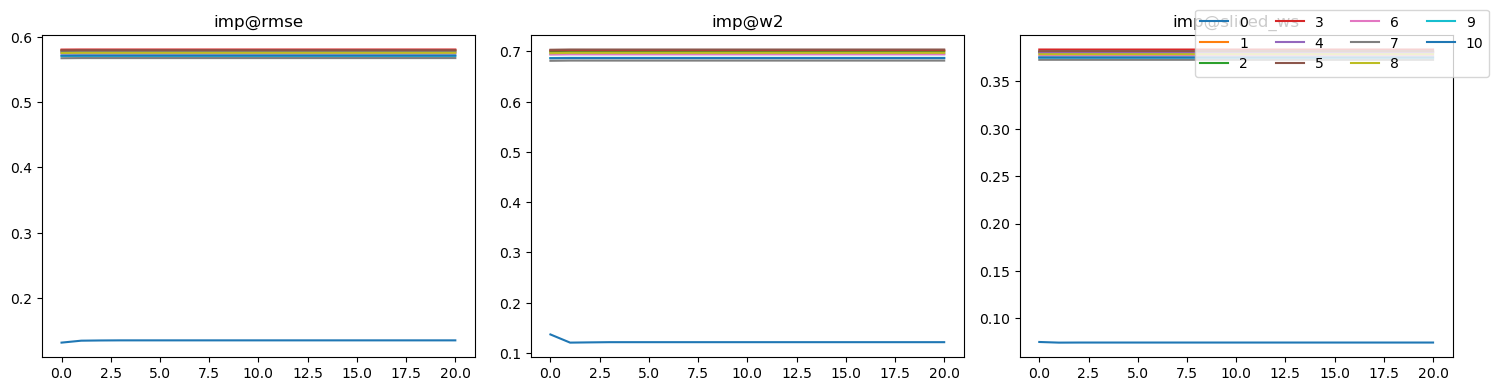

{'imp@rmse': 0.535754296928576, 'imp@ws': 0.6427268798837918, 'imp@sliced_ws': 0.35109666414343205}


In [20]:
name = 'mnar_lr_spesis_fedavg-s'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'sepsis'
# config2['handle_imbalance'] = 'smote'
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [33]:
name = 'mnar_lr_spesis_fedavg-s'
pred_ret = NN_evaluation(
    rets[name], type='fedavg', n_rounds=500, server_config_tmpl = server_config_tmpl
)

(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)


2023-08-03 16:59:05.295 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:140 - Round: 10, test_accu: 0.8735, test_f1: 0.4852, test_roc: 0.5690, val_loss: 0.8596, val_accu: 0.6099, val_f1: 0.6042
2023-08-03 16:59:36.860 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:140 - Round: 20, test_accu: 0.9055, test_f1: 0.4752, test_roc: 0.5826, val_loss: 1.7479, val_accu: 0.6298, val_f1: 0.6153
2023-08-03 17:00:08.145 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:140 - Round: 30, test_accu: 0.8300, test_f1: 0.5192, test_roc: 0.5774, val_loss: 2.3897, val_accu: 0.6373, val_f1: 0.6229
2023-08-03 17:00:39.721 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:140 - Round: 40, test_accu: 0.9045, test_f1: 0.5044, test_roc: 0.5865, val_loss: 3.4173, val_accu: 0.6422, val_f1: 0.6288
2023-08-03 17:01:11.579 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_p

KeyboardInterrupt: 

(18000, 4) (2000, 4)
(18000, 4)
sample-evenly {}
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(2000, 4)


2023-08-03 16:41:40.815 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-03 16:41:40.816 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-03 16:42:32.820 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-03 16:42:32.821 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-03 16:43:22.704 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-03 16:43:22.705 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-03 16:43:28.039 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 111.64027789997635


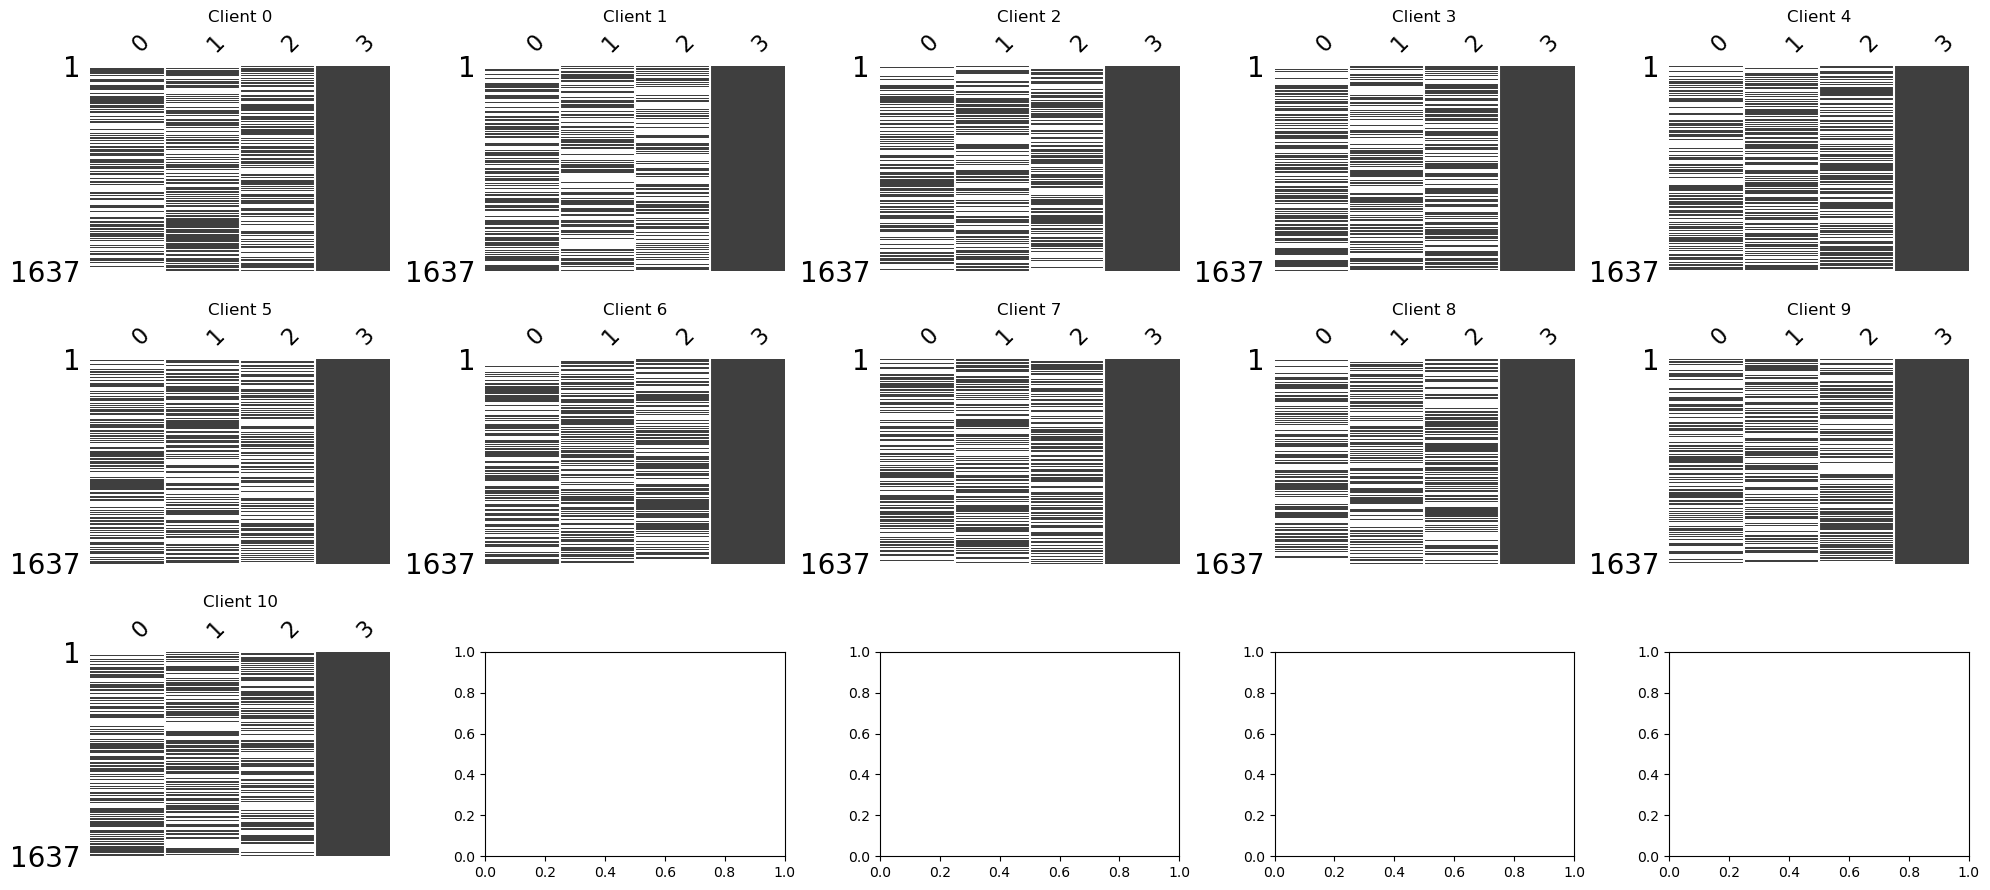

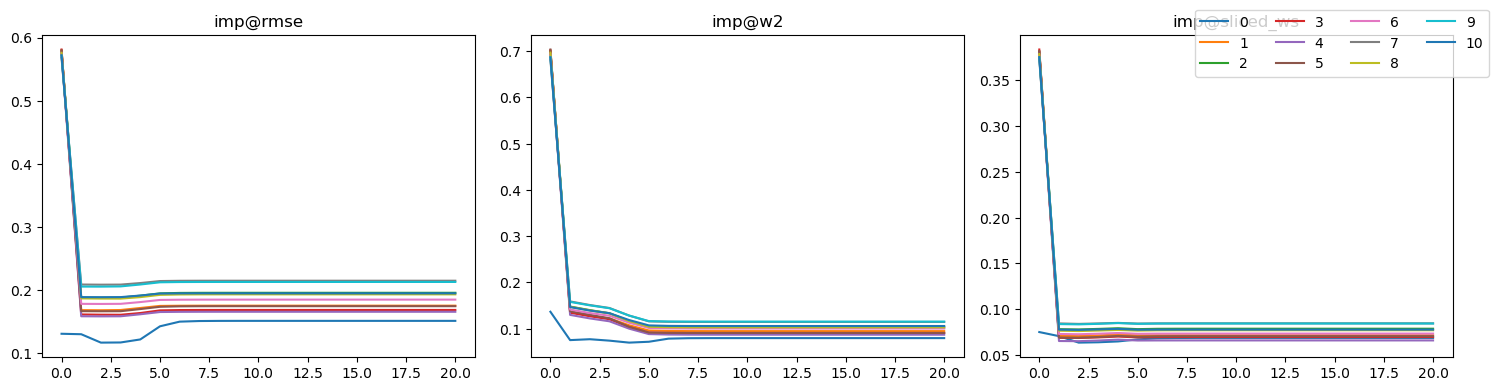

{'imp@rmse': 0.18491430530021327, 'imp@ws': 0.09851575913062263, 'imp@sliced_ws': 0.07457633174269533}


In [24]:
name = 'mnar_lr_codon_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'sepsis'
#config2['handle_imbalance'] = 'smote'
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [32]:
name = 'mnar_lr_codon_fedmechw'
pred_ret = NN_evaluation(
    rets[name], type='fedavg', n_rounds=500, server_config_tmpl = server_config_tmpl
)

(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)
(1637, 3) (1637,)
(1637, 3) (1637,) (2000, 3) (2000,)


2023-08-03 16:55:08.580 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:140 - Round: 10, test_accu: 0.5370, test_f1: 0.4355, test_roc: 0.6957, val_loss: 0.6042, val_accu: 0.6696, val_f1: 0.6544
2023-08-03 16:55:40.144 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:140 - Round: 20, test_accu: 0.5390, test_f1: 0.4385, test_roc: 0.6902, val_loss: 0.6008, val_accu: 0.6698, val_f1: 0.6525
2023-08-03 16:56:11.425 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:140 - Round: 30, test_accu: 0.5760, test_f1: 0.4558, test_roc: 0.6830, val_loss: 0.5965, val_accu: 0.6813, val_f1: 0.6727
2023-08-03 16:56:42.939 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:140 - Round: 40, test_accu: 0.5015, test_f1: 0.4091, test_roc: 0.6298, val_loss: 0.5885, val_accu: 0.6897, val_f1: 0.6818
2023-08-03 16:57:14.591 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_p

KeyboardInterrupt: 

# Diabetic

In [55]:
trackers = {}
rets ={}
mr_strategy = 'fixed@mr=0.5'

(101766, 50)
(69569, 43)
(20000, 40)
(18000, 40) (2000, 40)
(18000, 40)
sample-evenly {}
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(2000, 40)


2023-08-03 23:05:08.053 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-03 23:05:08.054 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-03 23:07:12.092 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-03 23:07:12.093 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-03 23:09:25.990 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-03 23:09:25.991 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-03 23:09:39.947 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 276.5870550000109


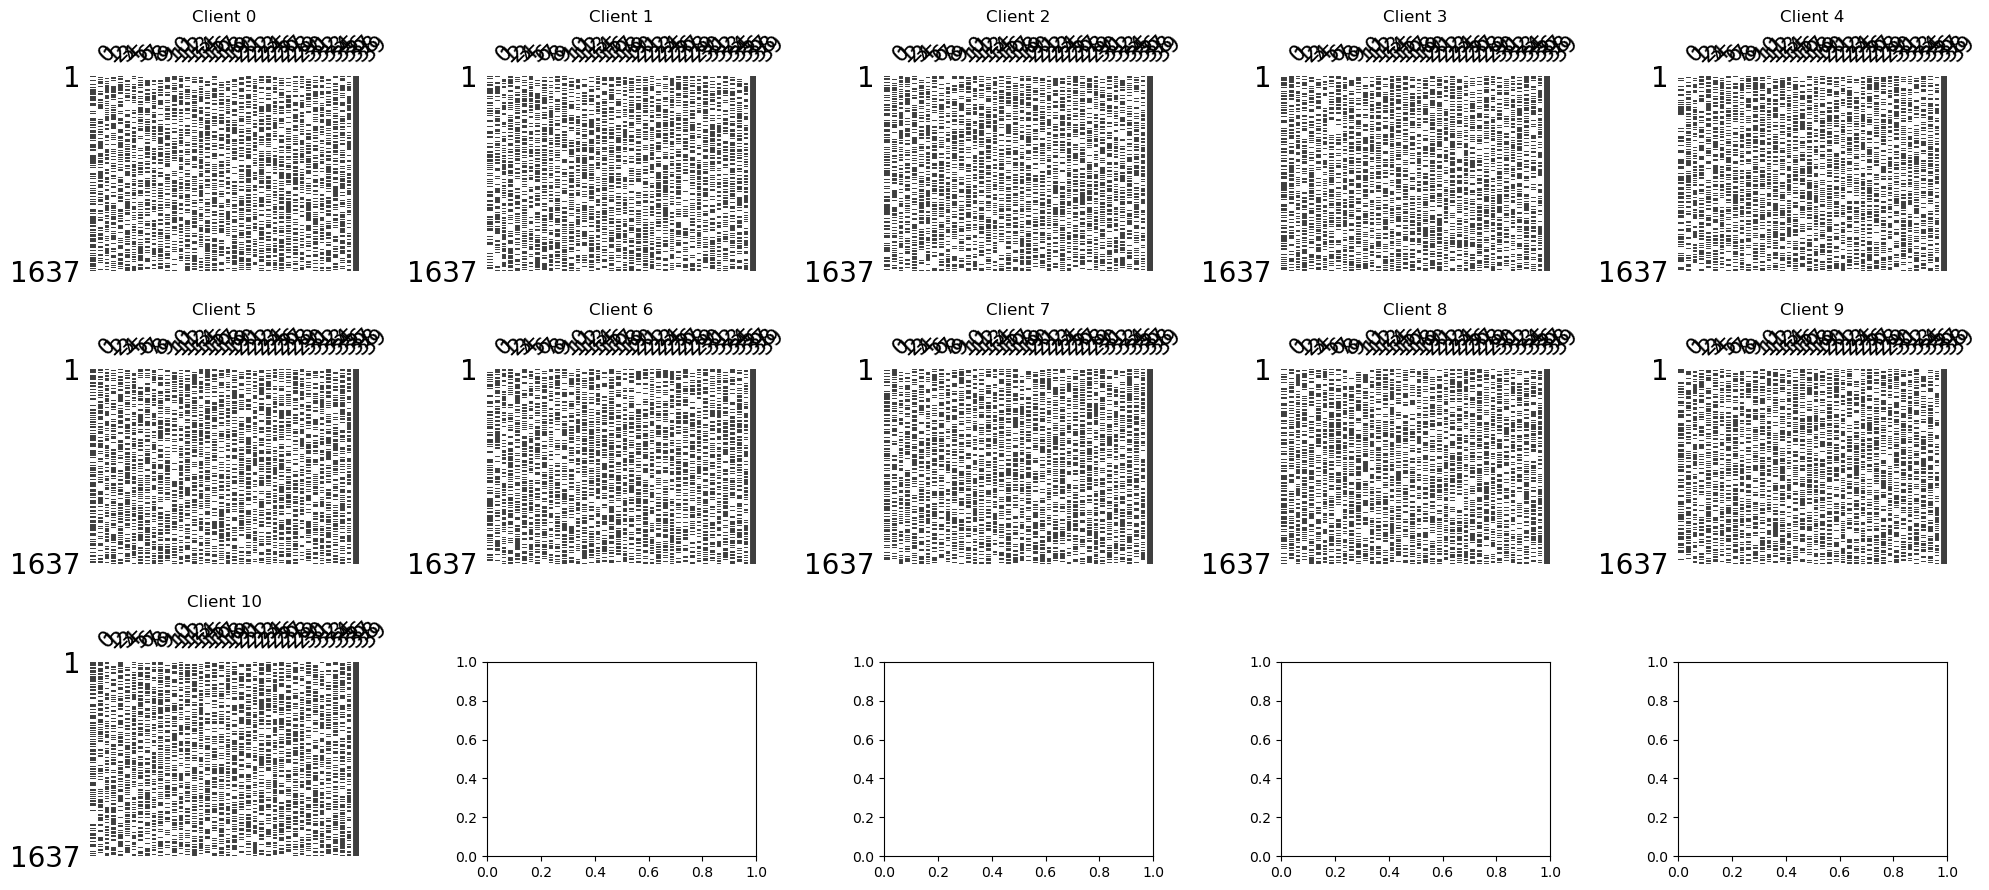

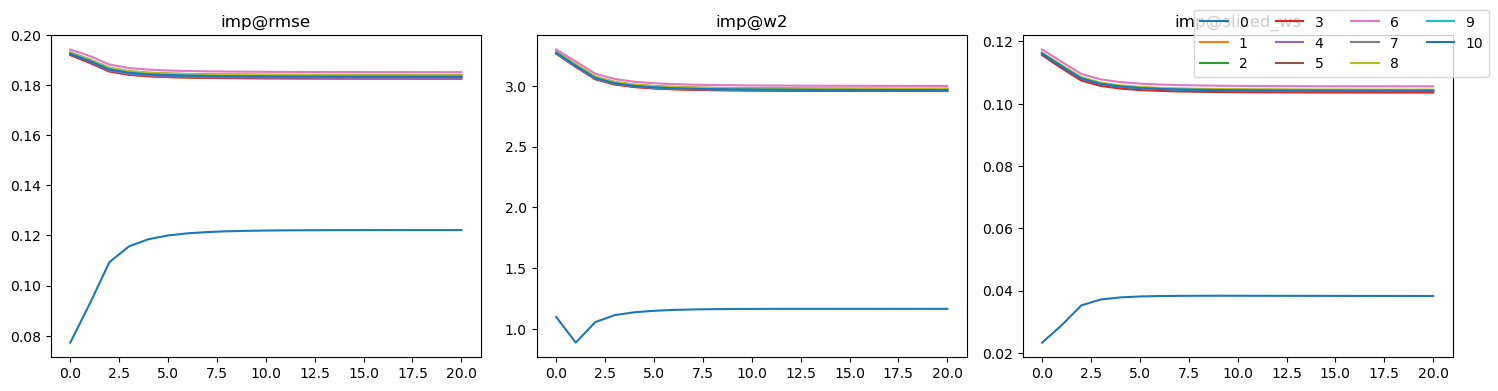

{'imp@rmse': 0.17785227605441362, 'imp@ws': 2.8052270139355606, 'imp@sliced_ws': 0.09829947258850728}


In [56]:
name = 'mnar_lr_diabetic_fedavg-s'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'diabetic'
config2['handle_imbalance'] = None
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [61]:
pred_ret = NN_evaluation(
    rets['mnar_lr_diabetic_fedavg-s'], type='centralized', n_rounds=300, server_config_tmpl = server_config_tmpl
)

d:\E\miniconda\envs\fed_imp\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-08-04 00:13:23.447 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 0, test_accu: 0.9125, test_f1: 0.0000 test_auroc: 0.5758 train_loss: 0.6934 val_accu: 0.5000 val_f1: 0.3333 test recall 0.0000 precision 0.0000 b-accu 0.5000
2023-08-04 00:13:24.094 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 1, test_accu: 0.0890, test_f1: 0.1611 test_auroc: 0.5860 train_loss: 0.6927 val_accu: 0.5006 val_f1: 0.3347 test recall 1.0000 precision 0.0876 b-accu 0.5008
2023-08-04 00:13:24.647 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 2, test_accu: 0.7325, test_

0.9125 0.5859976516634051 0.18122977346278318


(101766, 50)
(69569, 43)
(20000, 40)
(18000, 40) (2000, 40)
(18000, 40)
sample-evenly {}
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(2000, 40)


2023-08-03 23:50:43.437 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-03 23:50:43.437 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-03 23:53:09.197 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-03 23:53:09.198 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-03 23:56:04.105 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-03 23:56:04.106 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-03 23:56:20.313 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 341.4750915999757


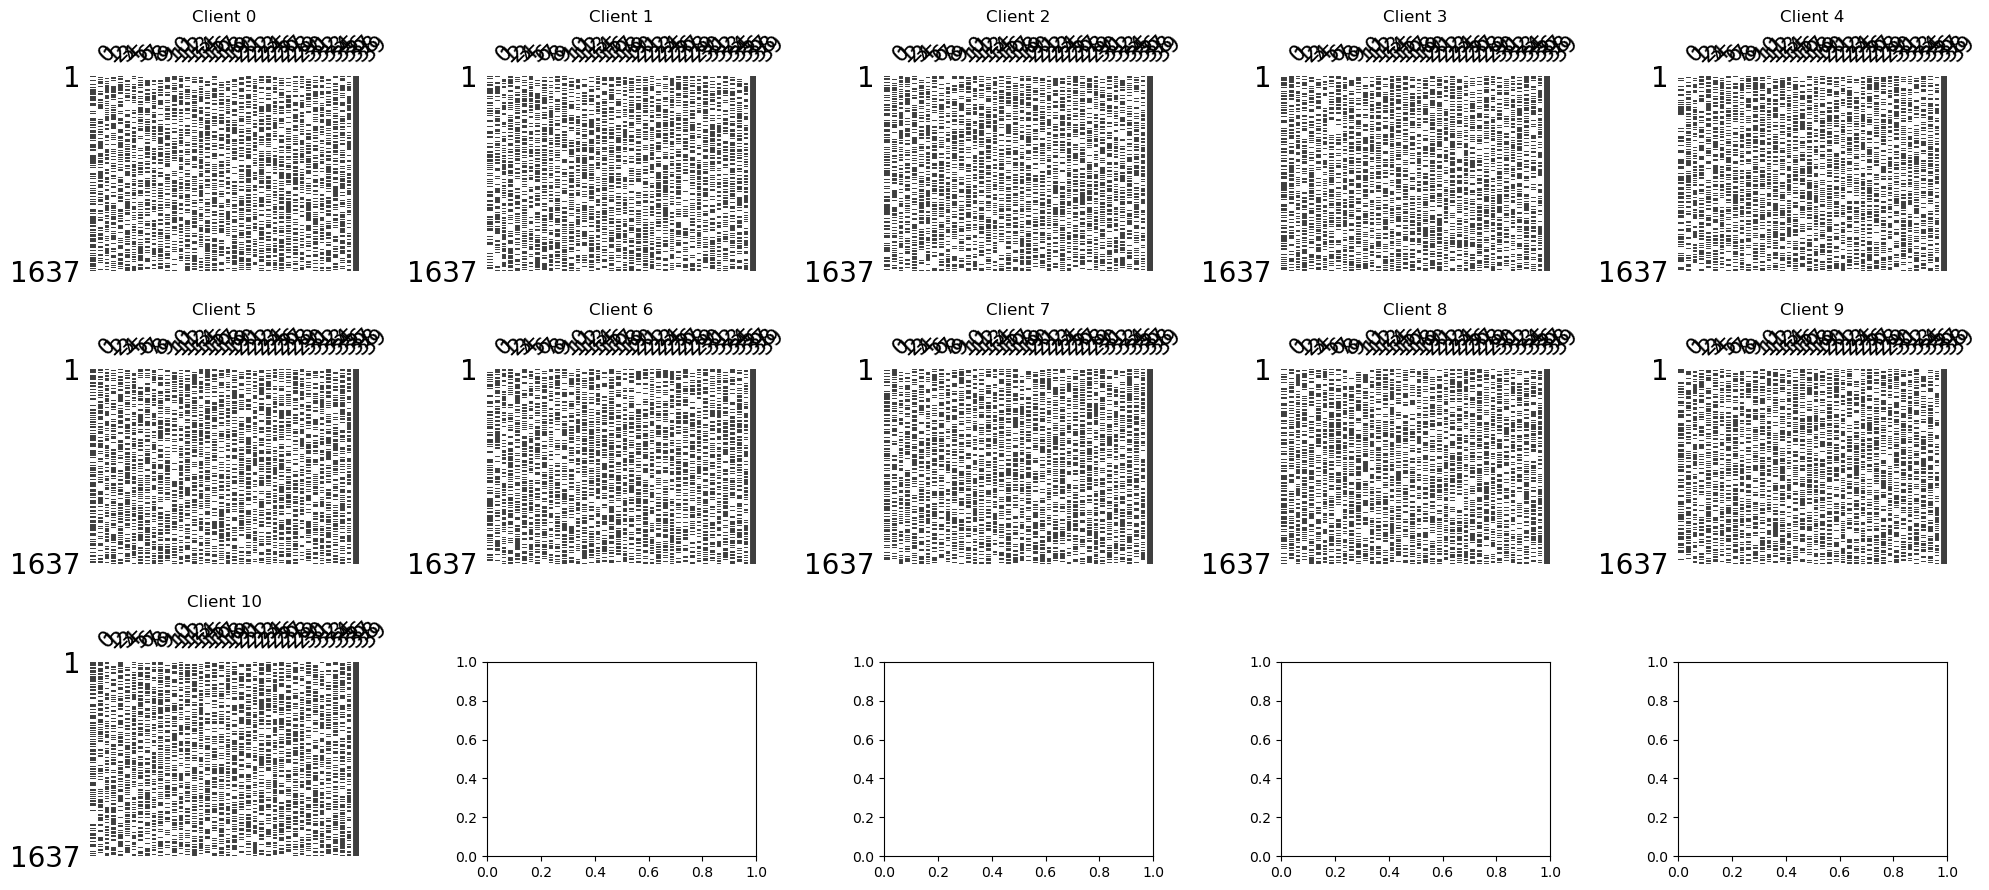

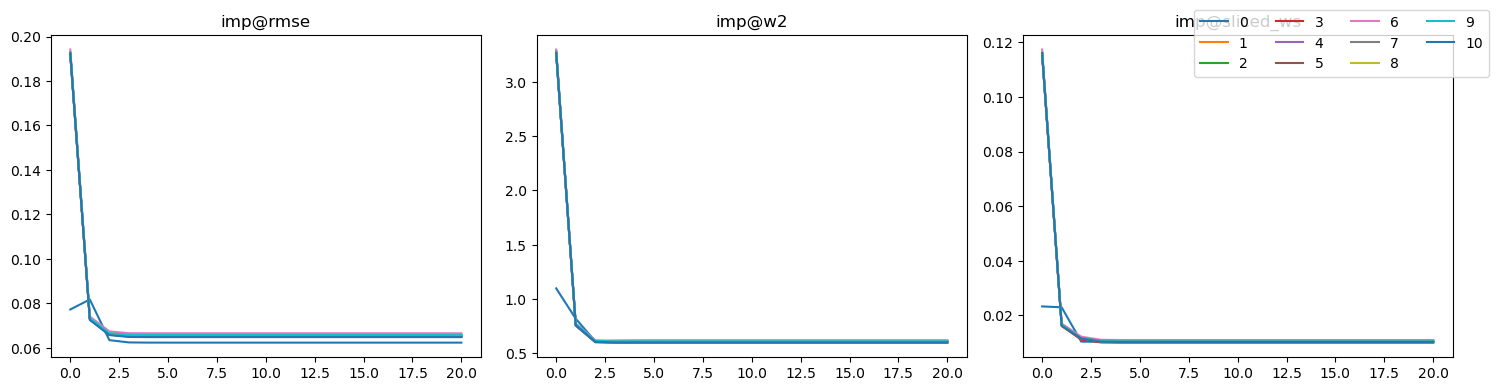

{'imp@rmse': 0.06521828406799376, 'imp@ws': 0.605349901553741, 'imp@sliced_ws': 0.010380750656496792}


In [58]:
name = 'mnar_lr_diabetic_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'diabetic'
config2['handle_imbalance'] = None
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [62]:
pred_ret = NN_evaluation(
    rets['mnar_lr_diabetic_fedmechw'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

2023-08-04 00:21:16.932 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 0, test_accu: 0.3730, test_f1: 0.1847 test_auroc: 0.6069 train_loss: 0.6868 val_accu: 0.5857 val_f1: 0.5361 test recall 0.8114 precision 0.1042 b-accu 0.5712
2023-08-04 00:21:17.563 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 1, test_accu: 0.7220, test_f1: 0.1965 test_auroc: 0.6074 train_loss: 0.6557 val_accu: 0.6324 val_f1: 0.6302 test recall 0.3886 precision 0.1315 b-accu 0.5713
2023-08-04 00:21:18.186 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 2, test_accu: 0.7160, test_f1: 0.1932 test_auroc: 0.6085 train_loss: 0.6344 val_accu: 0.6660 val_f1: 0.6654 test recall 0.3886 precision 0.1285 b-accu 0.5680
2023-08-04 00:21:18.827 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:186 - Round: 3, test_accu: 0.6300, test_f1: 0.1814 test_aur

0.8925 0.6084853228962818 0.19653179190751444


# Cardio

In [42]:
trackers = {}
rets ={}
mr_strategy = 'fixed@mr=0.5'

['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'NEW_AGE', 'NEW_BMI', 'BLOOD_PRESSURE']
(70000, 20)
(70000, 12)
(20000, 12)
11
1.0    10011
0.0     9989
Name: count, dtype: int64
(18000, 12) (2000, 12)
(18000, 12)
sample-evenly {}
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(2000, 12)


2023-08-03 19:15:07.582 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-03 19:15:07.583 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-03 19:16:29.130 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-03 19:16:29.131 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-03 19:17:38.890 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-03 19:17:38.891 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-03 19:17:46.507 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 163.48836580000352


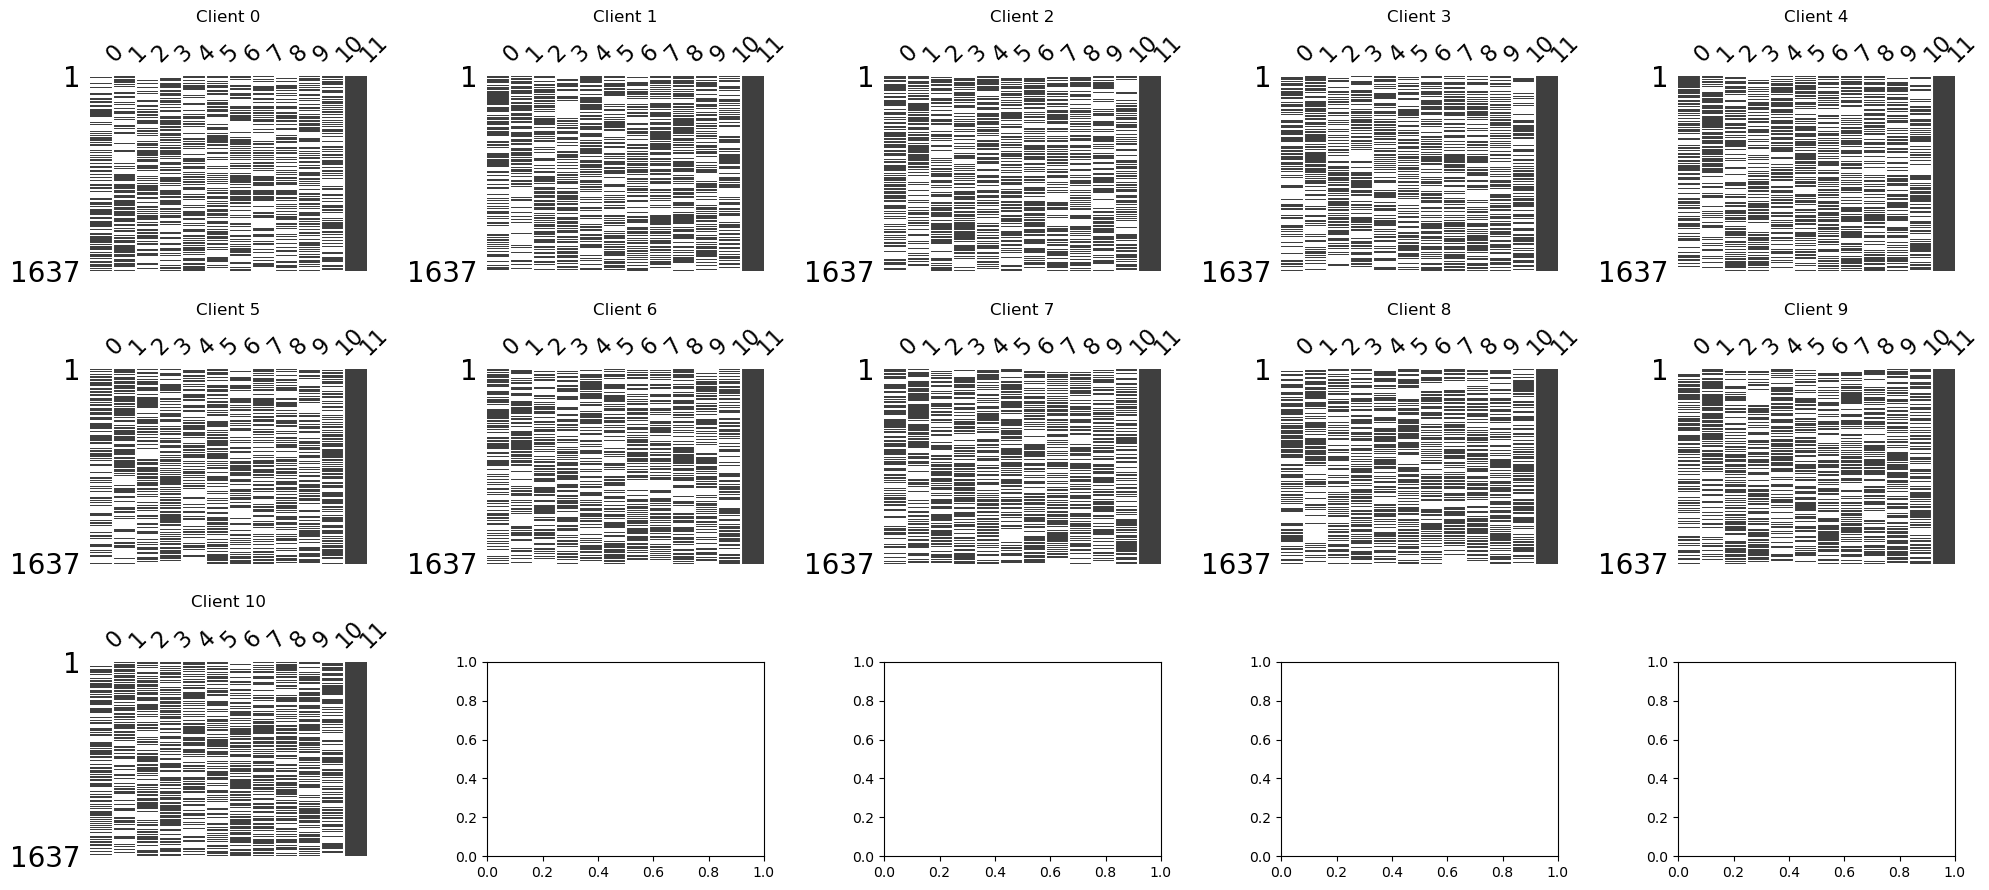

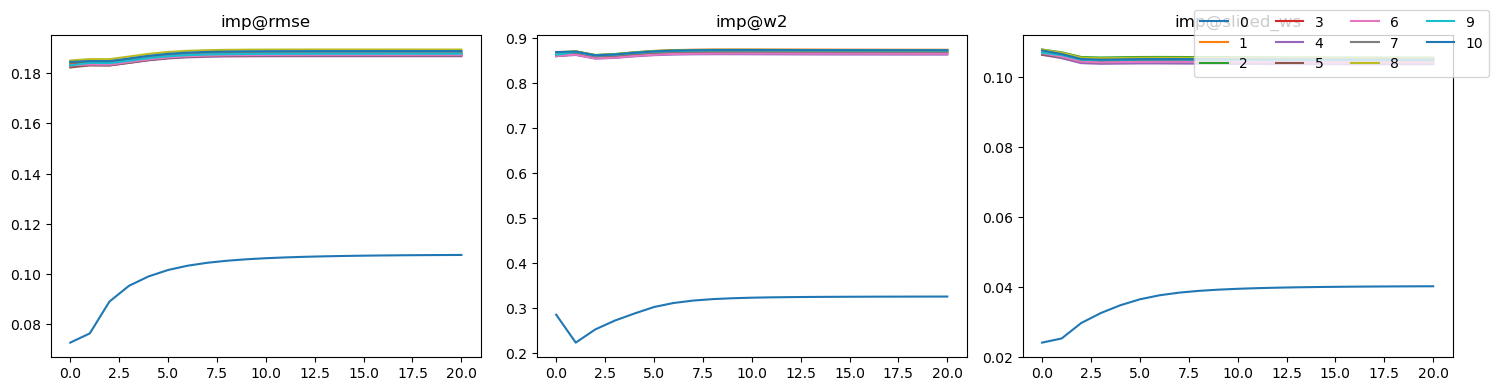

{'imp@rmse': 0.1805928921916503, 'imp@ws': 0.8211636117179579, 'imp@sliced_ws': 0.09885332860512797}


In [45]:
name = 'mnar_lr_cardio_fedavg-s'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'cardio'
config2['handle_imbalance'] = None
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [46]:
pred_ret = NN_evaluation(
    rets['mnar_lr_cardio_fedavg-s'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)


2023-08-03 19:17:49.559 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:179 - Round: 0, test_accu: 0.5410, test_f1: 0.4339 test_auroc: 0.6688 train_loss: 0.6940 val_accu: 0.5017 val_f1: 0.3380
2023-08-03 19:17:57.442 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:179 - Round: 20, test_accu: 0.4995, test_f1: 0.3331 test_auroc: 0.5020 train_loss: 0.6933 val_accu: 0.5000 val_f1: 0.3333
2023-08-03 19:18:05.596 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:179 - Round: 40, test_accu: 0.5005, test_f1: 0.3336 test_auroc: 0.5020 train_loss: 0.6936 val_accu: 0.5000 val_f1: 0.3333
2023-08-03 19:18:13.301 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:179 - Round: 60, test_accu: 0.4995, test_f1: 0.3331 test_auroc: 0.5020 train_loss: 0.6932 val_accu: 0.5000 val_f1: 0.3333
2023-08-03 19:18:20.776 | INFO     | src.fed_imp.sub_modules.server.pred_server_centr

0.5835 0.6825971825971826 0.5403162767494678


['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'NEW_AGE', 'NEW_BMI', 'BLOOD_PRESSURE']
(70000, 20)
(70000, 12)
(20000, 12)
11
1.0    10011
0.0     9989
Name: count, dtype: int64
(18000, 12) (2000, 12)
(18000, 12)
sample-evenly {}
11
[1, 10]
[['mnar_quantile_left']]
[['mnar_quantile_left'], ['mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right', 'mnar_quantile_right']]
['mnar_quantile_left@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5', 'mnar_quantile_right@0.5']
(2000, 12)


2023-08-03 19:21:07.852 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-03 19:21:07.853 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-03 19:22:13.165 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-03 19:22:13.165 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-03 19:23:27.163 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-03 19:23:27.163 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-03 19:23:34.960 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 151.88568760000635


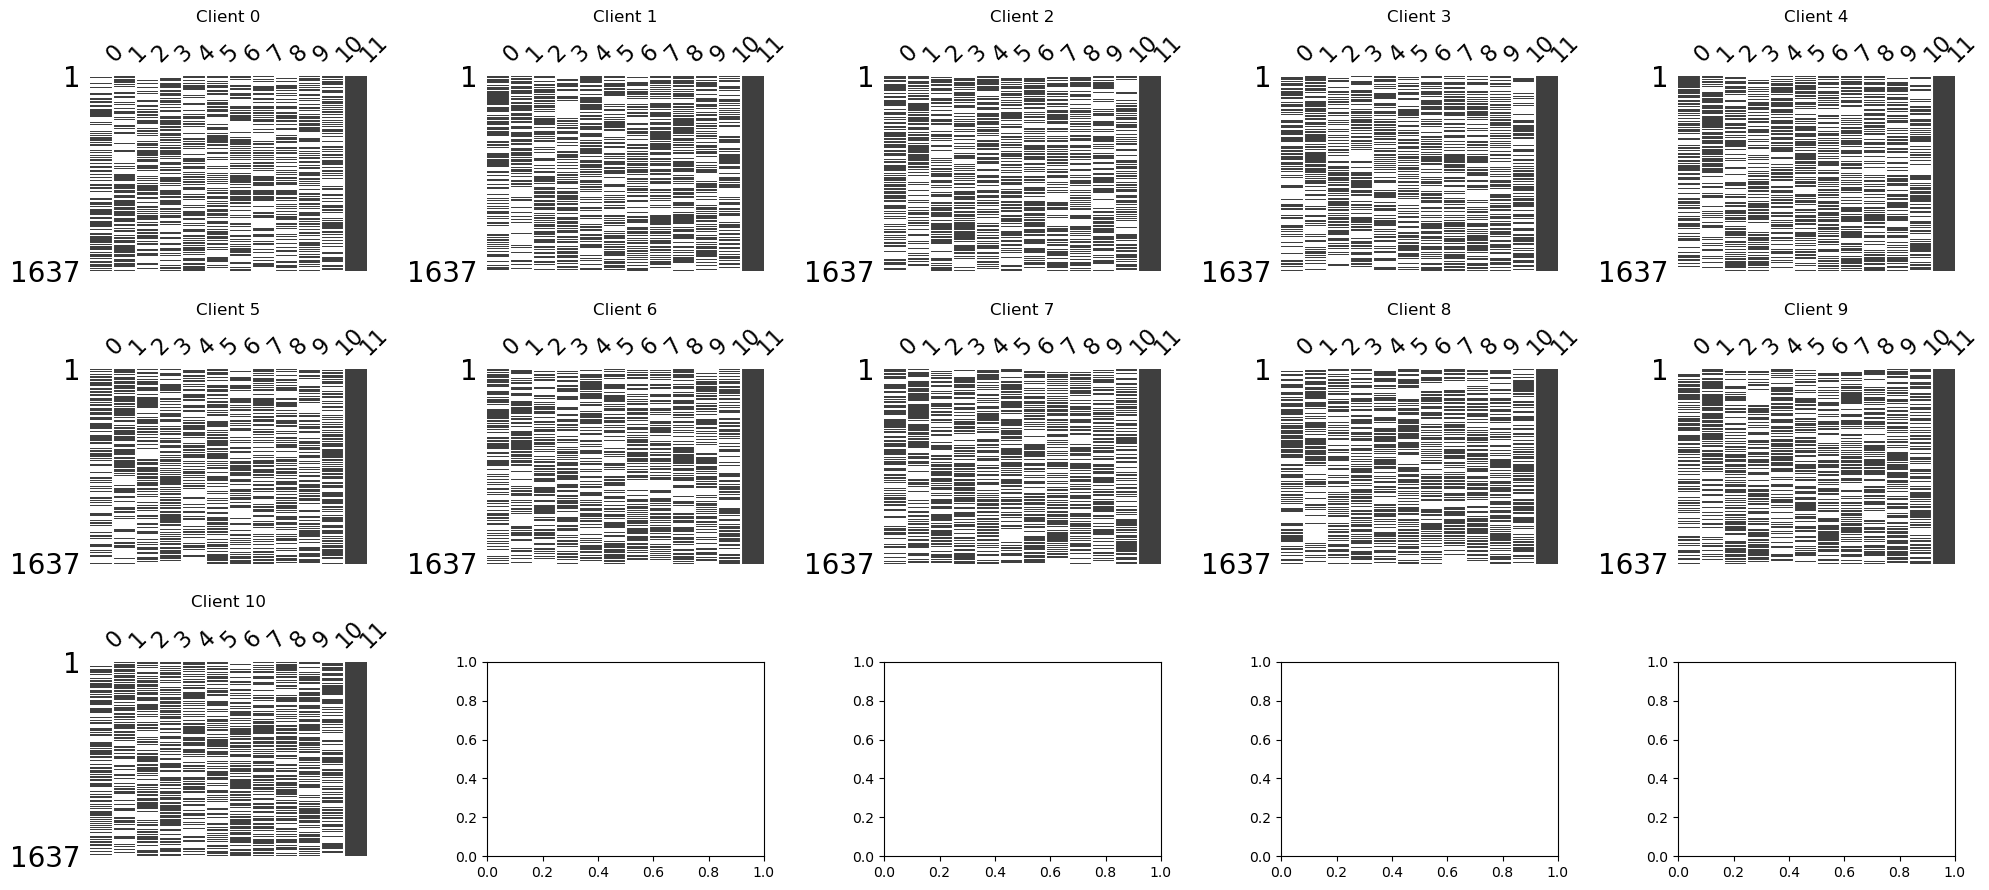

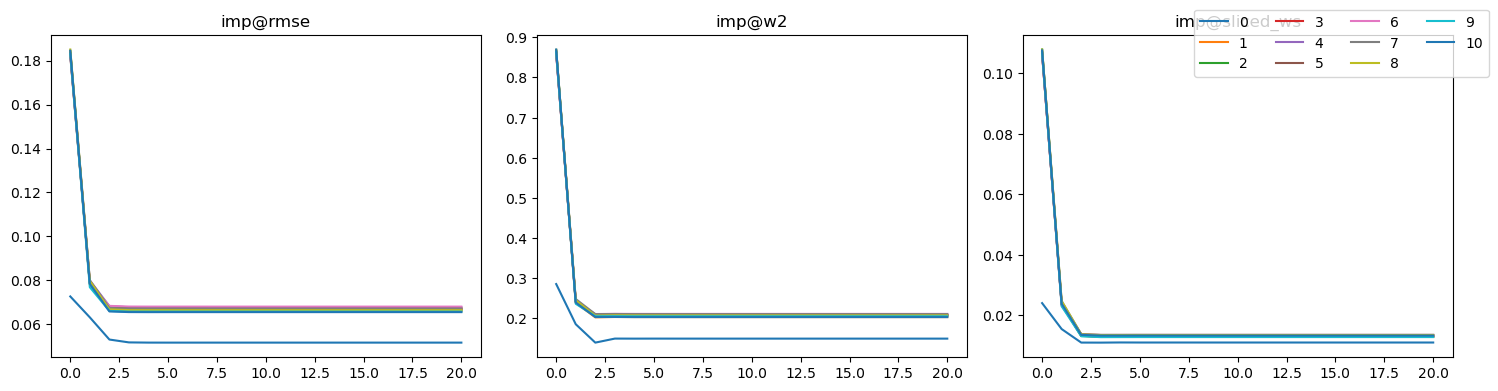

{'imp@rmse': 0.06543817506394098, 'imp@ws': 0.20229980583053633, 'imp@sliced_ws': 0.013060052115186857}


In [47]:
name = 'mnar_lr_cardio_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'cardio'
config2['handle_imbalance'] = None
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremel1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [48]:
pred_ret = NN_evaluation(
    rets['mnar_lr_cardio_fedmechw'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)


2023-08-03 19:23:38.051 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:179 - Round: 0, test_accu: 0.6680, test_f1: 0.6674 test_auroc: 0.7506 train_loss: 0.6565 val_accu: 0.6912 val_f1: 0.6911
2023-08-03 19:23:45.786 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:179 - Round: 20, test_accu: 0.7190, test_f1: 0.7170 test_auroc: 0.7877 train_loss: 0.5774 val_accu: 0.7273 val_f1: 0.7266
2023-08-03 19:23:53.256 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:179 - Round: 40, test_accu: 0.7160, test_f1: 0.7139 test_auroc: 0.7878 train_loss: 0.5737 val_accu: 0.7195 val_f1: 0.7179
2023-08-03 19:24:00.885 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:179 - Round: 60, test_accu: 0.7100, test_f1: 0.7069 test_auroc: 0.7873 train_loss: 0.5709 val_accu: 0.7201 val_f1: 0.7193
2023-08-03 19:24:08.911 | INFO     | src.fed_imp.sub_modules.server.pred_server_centr

0.7265 0.7922517922517921 0.7264999316249829


['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'NEW_AGE', 'NEW_BMI', 'BLOOD_PRESSURE']
(70000, 20)
(70000, 12)
(20000, 12)
11
1.0    10011
0.0     9989
Name: count, dtype: int64
(18000, 12) (2000, 12)
(18000, 12)
sample-evenly {}
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5']
(2000, 12)


2023-08-03 19:27:17.562 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-03 19:27:17.563 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-03 19:28:24.723 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-03 19:28:24.723 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-03 19:29:33.111 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-03 19:29:33.112 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-03 19:29:40.181 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 147.21332359994994


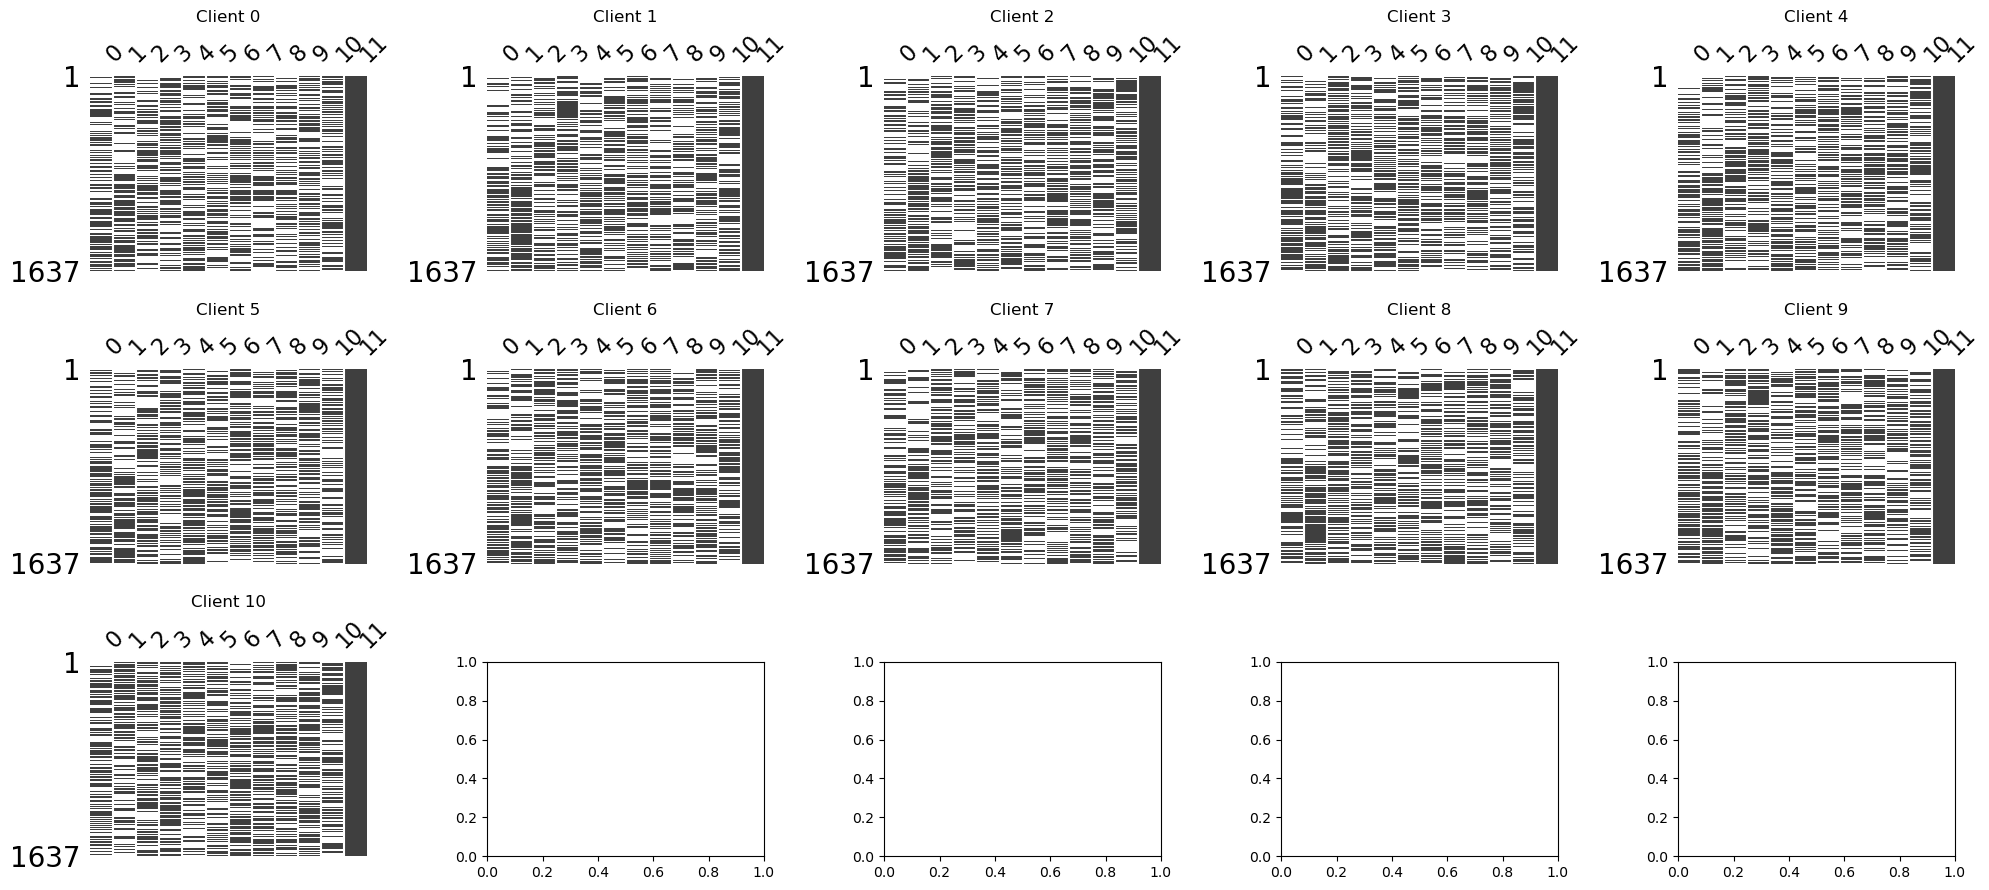

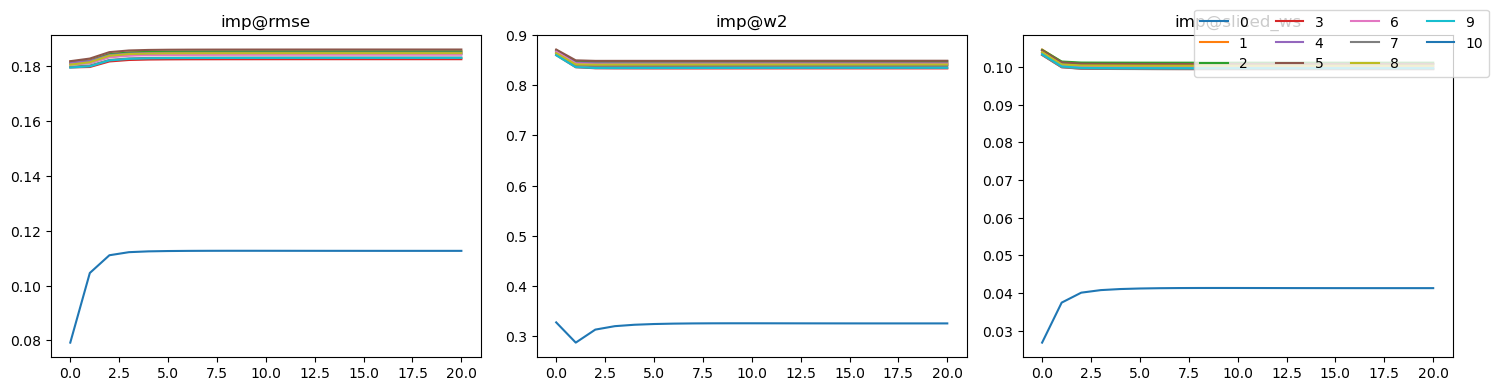

{'imp@rmse': 0.17795875628492033, 'imp@ws': 0.7944499369117158, 'imp@sliced_ws': 0.0949492538761867}


In [49]:
name = 'mnar_rl_cardio_fedavg-s'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'cardio'
config2['handle_imbalance'] = None
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremer1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedavg-s'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [50]:
pred_ret = NN_evaluation(
    rets['mnar_rl_cardio_fedavg-s'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)


2023-08-03 19:29:42.958 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:179 - Round: 0, test_accu: 0.5970, test_f1: 0.5701 test_auroc: 0.6067 train_loss: 0.6906 val_accu: 0.6247 val_f1: 0.6176
2023-08-03 19:29:50.591 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:179 - Round: 20, test_accu: 0.6730, test_f1: 0.6728 test_auroc: 0.7311 train_loss: 0.6363 val_accu: 0.6610 val_f1: 0.6571
2023-08-03 19:29:57.859 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:179 - Round: 40, test_accu: 0.6820, test_f1: 0.6820 test_auroc: 0.7392 train_loss: 0.6270 val_accu: 0.6655 val_f1: 0.6607
2023-08-03 19:30:05.200 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:179 - Round: 60, test_accu: 0.6800, test_f1: 0.6799 test_auroc: 0.7245 train_loss: 0.6230 val_accu: 0.6727 val_f1: 0.6693
2023-08-03 19:30:12.549 | INFO     | src.fed_imp.sub_modules.server.pred_server_centr

0.688 0.745974245974246 0.6879472630874618


['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'NEW_AGE', 'NEW_BMI', 'BLOOD_PRESSURE']
(70000, 20)
(70000, 12)
(20000, 12)
11
1.0    10011
0.0     9989
Name: count, dtype: int64
(18000, 12) (2000, 12)
(18000, 12)
sample-evenly {}
['mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_left@0.5', 'mnar_quantile_right@0.5']
(2000, 12)


2023-08-03 19:32:56.555 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-03 19:32:56.555 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 1
2023-08-03 19:33:59.802 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-03 19:33:59.803 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 10
2023-08-03 19:35:14.830 | INFO     | src.fed_imp.sub_modules.server.base_server:run:148 - ==================================================
2023-08-03 19:35:14.831 | INFO     | src.fed_imp.sub_modules.server.base_server:run:149 - Imputation Round 20
2023-08-03 19:35:22.460 | INFO     | src.fed_imp.sub_modules.server.base_server:run:178 - FL finished in 150.49200660001952


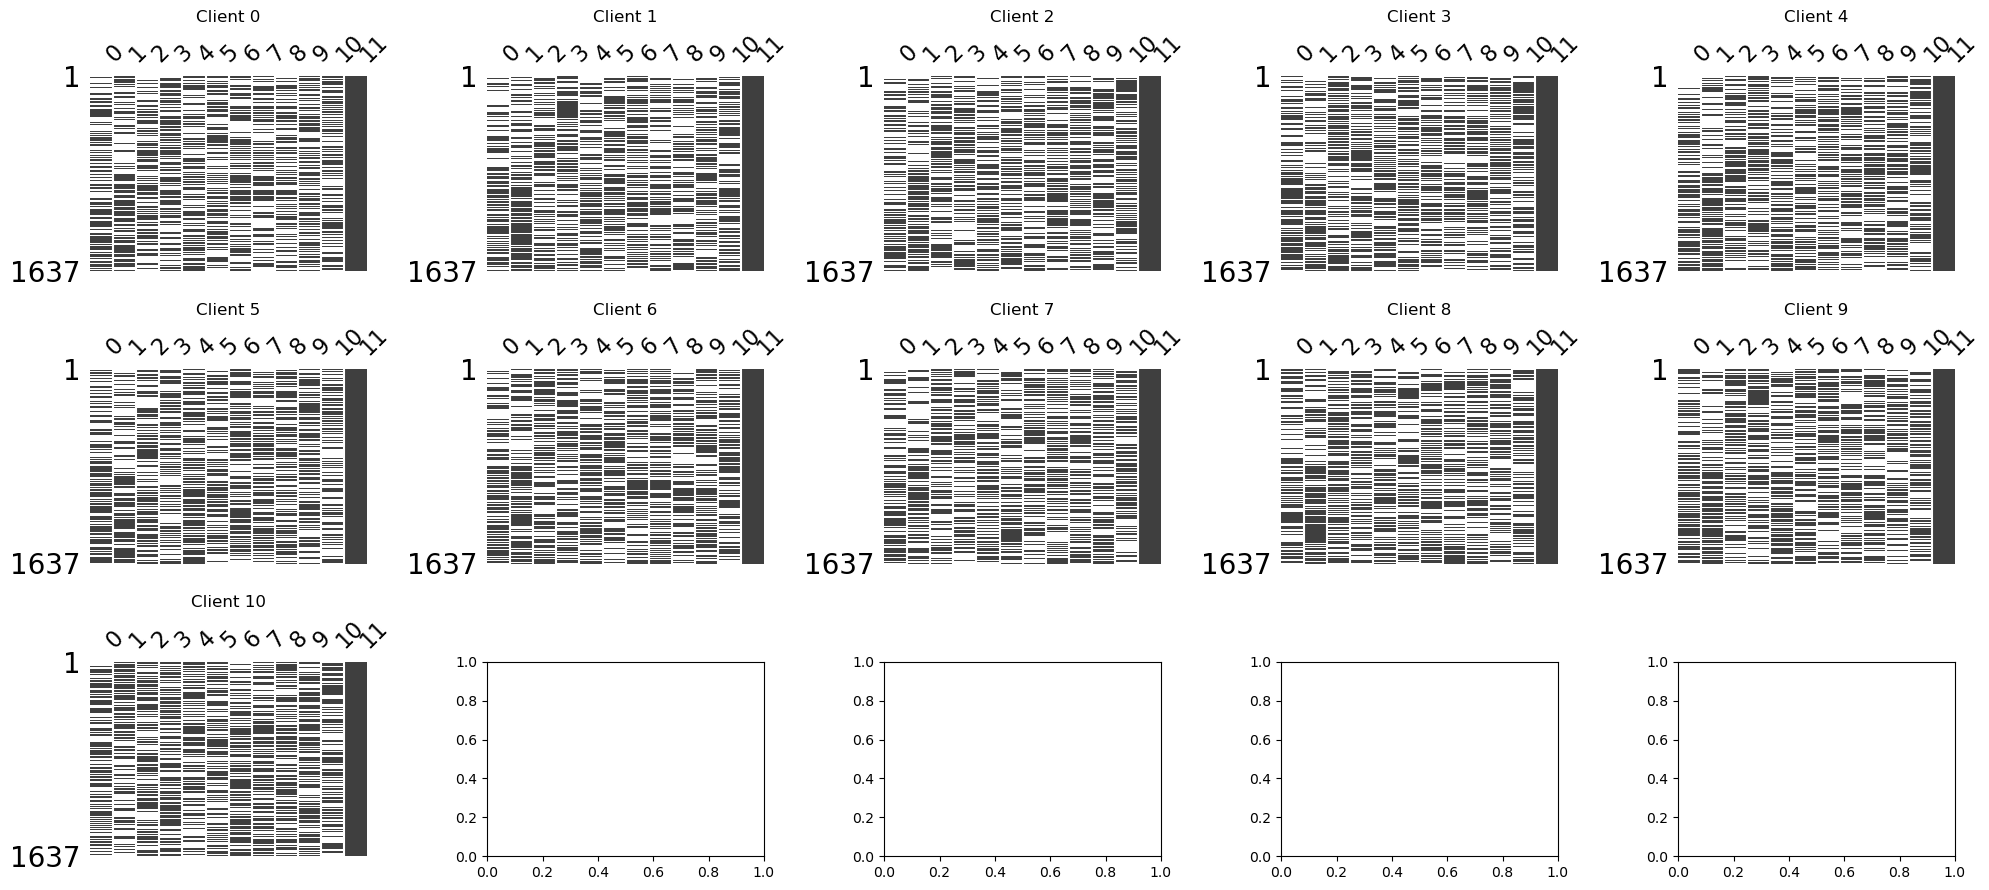

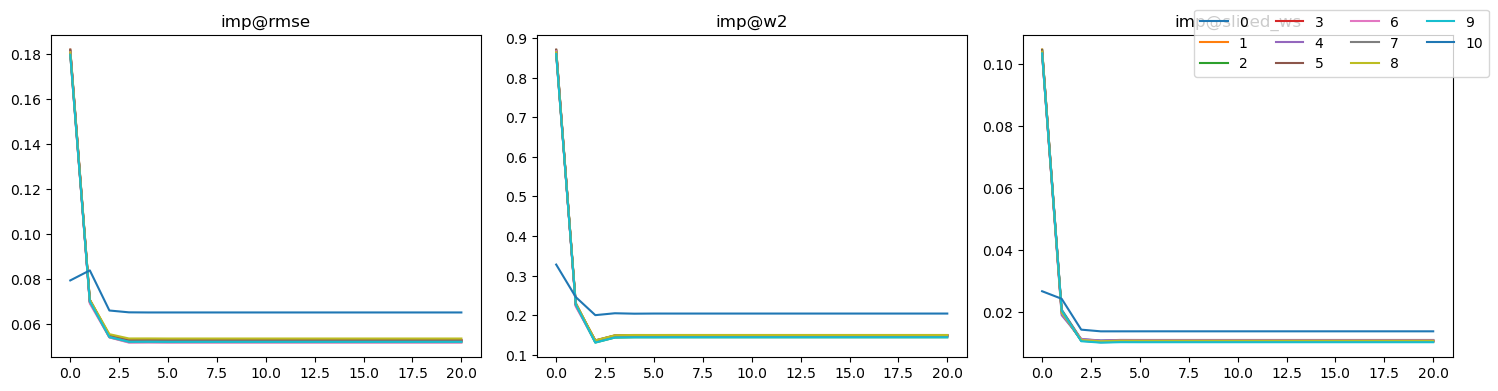

{'imp@rmse': 0.053483969634496406, 'imp@ws': 0.15272740569858834, 'imp@sliced_ws': 0.011088363895667294}


In [51]:
name = 'mnar_rl_cardio_fedmechw'
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'cardio'
config2['handle_imbalance'] = None
config2['num_clients'] = 11
config2['missing_simulate']['mr_strategy'] = mr_strategy
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extremer1'
config2['data_partition']['strategy'] = 'sample-evenly'

config2['agg_strategy_imp']['strategy'] = 'fedmechw'
config2['server_type'] = 'fedavg_pytorch'
config2['prediction'] = False
config2['save_state'] = True
config2['track'] = True

clients, test_data, new_seed = simulate_scenario(config2)
print(test_data.shape)
server, ret = run_simulation(config2, clients, test_data, new_seed)
trackers[name] = copy.deepcopy(server.stats_tracker)
rets[name] = ret.copy()

In [52]:
pred_ret = NN_evaluation(
    rets['mnar_rl_cardio_fedmechw'], type='centralized', n_rounds=500, server_config_tmpl = server_config_tmpl
)

(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)
(1637, 11) (1637,)
(1637, 11) (1637,) (2000, 11) (2000,)


2023-08-03 19:35:25.497 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:179 - Round: 0, test_accu: 0.6895, test_f1: 0.6881 test_auroc: 0.7636 train_loss: 0.6305 val_accu: 0.7043 val_f1: 0.7042
2023-08-03 19:35:32.399 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:179 - Round: 20, test_accu: 0.7160, test_f1: 0.7147 test_auroc: 0.7826 train_loss: 0.5654 val_accu: 0.7226 val_f1: 0.7201
2023-08-03 19:35:40.070 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:179 - Round: 40, test_accu: 0.7130, test_f1: 0.7106 test_auroc: 0.7831 train_loss: 0.5600 val_accu: 0.7201 val_f1: 0.7161
2023-08-03 19:35:48.517 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:179 - Round: 60, test_accu: 0.7170, test_f1: 0.7144 test_auroc: 0.7876 train_loss: 0.5635 val_accu: 0.7192 val_f1: 0.7151
